## Cluster TMAs

**Samples:** 
- JP-TMA-1
- JP-TMA-2 (only 2 ER+, and no survival data)

**Method**: 

- threshold and gate cell types

- marker expression in tumor/stroma

- leiden cluster on good biomarkers for celltypes


In [16]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [5]:
#load libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import scipy
import scanpy as sc
import matplotlib as mpl
from matplotlib import cm
mpl.rc('figure', max_open_warning = 0)
codedir = '/home/groups/graylab_share/Chin_Lab/ChinData/engje/Data/20200000/20200406_JP-TMAs'#'/home/groups/graylab_share/OMERO.rdsStore/engje/Data/20200000/20200406_JP-TMAs'#os.getcwd()
import phenograph
os.chdir('/home/groups/graylab_share/Chin_Lab/ChinData/engje/Data')
from mplex_image import visualize as viz, process, preprocess, normalize, mics, mpimage
np.random.seed(126)

In [6]:
codedir

'/home/groups/graylab_share/Chin_Lab/ChinData/engje/Data/20200000/20200406_JP-TMAs'

In [7]:
#change to correct directory
datadir = f'/home/groups/graylab_share/OMERO.rdsStore/engje/Data/20200000/20200406_JP-TMAs/data'
s_date = '20220408'
os.chdir(codedir)
if not os.path.exists(s_date):
    os.mkdir(s_date)
%matplotlib inline

# Table of contents <a name="contents"></a>
1. [Load annotation](#loadold)
2. [load data](#cluster)
3. [load thresholds](#load)
  [gating](#gating)  [colocalization](#coloc)
4. [bg subtract](#leiden)
5. [single cell Umap](#l7)
6. [Leiden celltypes](#l8)
[annotate leiden celltypes](#lbar)
7. [Tissue means](#tissue)
8. [single variable survival](#surv)
9. [subtyping survival](#subt)
10. [With IMC data: subtyping survival](#subtIMC)
11. [Neighborhoods](#neigh)
[Neighborhood enrichment](#sqpy)
12. [Distances](#dist)

# Load annotation <a name="loadold"></a>

[contents](#contents)

In [32]:
df_cyc_a = pd.read_csv(f'{codedir}/annotation/20210403_JP-TMA1_Annotation+Clinical-Subtype.csv',index_col=0)
df_cyc_a.rename({'ClinicalSubtype':'ID'},axis=1,inplace=True)
#collapse Subtypes
d_replace = {'0':'other','?':'other', np.nan:'other'}
df_cyc_a.ID.replace(d_replace,inplace=True)
df_cyc_a.loc[df_cyc_a.index.str.contains('JP-TMA2-1'),'Accession'] = df_cyc_a.loc[df_cyc_a.index.str.contains('JP-TMA2-1'),'TMA_scene.1']
#add subtype and patient
d_cyc_sub = dict(zip(df_cyc_a.index.tolist(),df_cyc_a.ID.tolist()))
d_cyc_sub['JP-TMA2-1_scene08'] = 'ER+HER2+'
d_patient = dict(zip(df_cyc_a.index,df_cyc_a.Accession))


# JP-TMAs  <a name="cluster"></a>

load and check JP-TMA-2 and JP-TMA-1

filter markers, filter out edge cores (load manual data frame)


[contents](#contents)

In [ ]:
os.chdir(datadir)
#load manual
ls_man = ['20211221_JP-TMA2_ManualPositive.csv','20211207_JP-TMA1_ManualPositive.csv']
df_man = pd.DataFrame()
for s_man in ls_man:
    df_man = df_man.append(pd.read_csv(s_man,index_col=0))
#this version has the cores cropped so the bordering cores are not included
len(df_man)

In [ ]:
#mean int
ls_sample = ['JP-TMA2-1','JP-TMA1-1'] #, 'JP-TMA2-1','JE-TMA-42'
df_mi = pd.DataFrame()
df_xy = pd.DataFrame()
for s_sample in ls_sample:
    df_mi2 = pd.read_csv(f'{datadir}/features_{s_sample}_FilteredMeanIntensity.csv',index_col=0)
    #df_mi2.rename({'slide_scene':'slidescene'},axis=1,inplace=True)
    df_xy2 = pd.read_csv(f'{datadir}/features_{s_sample}_CentroidXY.csv',index_col=0)
    #df_xy['slide_scene'] = [item.split('_cell')[0] for item in df_xy.index]
    df_mi2.columns = [item.replace('_nucleipos','pos') for item in df_mi2.columns]
    #df_mi2['slide'] = s_sample
    #df_xy2['slide'] = s_sample
    df_mi =df_mi.append(df_mi2)
    df_xy =df_xy.append(df_xy2)
    #break

In [ ]:
len(df_mi.loc[df_man.index])

In [ ]:
df_mi = df_mi.loc[df_man.index]

In [ ]:
df_mi.columns

In [ ]:
#synchronize with 20201017_JP-TMAs_cellpose_OutputPositive.iynb - just HER2 and EGFR cell mem 25
ls_drop = ['CD44_nucadj2','AR_nuclei25','EGFR_perinuc5','ER_nuclei25','HER2_cytoplasm','Vim_nucadj2',
          'Ecad_cellmem25','R1c2_perinuc5', 'R5Qc2_perinuc5', 'R5Qc3_perinuc5', 'R5Qc4_perinuc5','R5Qc5_perinuc5'] #
df_mi = df_mi.drop(ls_drop,axis=1)

In [ ]:
#shorten and check
df_mi.columns = [item.split('_')[0] for item in df_mi.columns]
print(len(df_mi.columns))
df_mi.columns[df_mi.columns.duplicated()]

In [ ]:
#thresholds new (with added cores)
ls_sample = ['JP-TMA2-1','JP-TMA1-1'] #, 'JP-TMA2-1','JE-TMA-42'
df_thresh = pd.DataFrame()
for s_sample in ls_sample:
    df = pd.read_csv(f'{codedir}/data/thresh_JE_{s_sample}.csv',index_col=0)
    df['slide'] = s_sample
    df_thresh =df_thresh.append(df)
#se_test = df_thresh.loc['global'].dropna() #drop 'PDGFRa', 'ColI'

In [ ]:
df_mi = df_mi.merge(df_xy,left_index=True, right_index=True)
df_mi.rename({'nuclei_area':'area','nuclei_eccentricity':'eccentricity'},axis=1,inplace=True)

In [ ]:
df_mi.columns

In [ ]:
#save
#s_out = f'{codedir}/data/20211221_JP-TMA2_FilteredMeanIntensity.csv'
s_out = f'{codedir}/data/20220118_JP-TMAs_FilteredMeanIntensity.csv'
if not os.path.exists(s_out):
    print('saving csv')
    df_mi.to_csv(s_out)

# thresholding <a name="load"></a>

load thresholds, apply to get positive/negative

filter out edge cores

JP-TMA1 (?) done in 20211207_JP-TMA_ER_cluster.ipynb

[contents](#contents)

In [ ]:
d_thresh = {}
for s_sample in ['JP-TMA2-1','JP-TMA1-1']
    d_combos = {'Tumor':{'AR', 'EGFR', 'ER', 'Ecad','HER2', 'PgR'},
                'Immune':{'CD20', 'CD3', 'CD4', 'CD44', 'CD45', 'CD68', 'CD8','FoxP3', 'GRNZB','PD1'},
                'Differentiation':{'CK14', 'CK17', 'CK19', 'CK5', 'CK7', 'CK8'},
                'Stroma':{ 'CD31','PDPN',  'Vim', 'aSMA','ColIV'},
                'Nuclear': {'LamAC', 'LamB1','LamB2','H3K27', 'H3K4','Ki67','PCNA'},
                'Signal':{ 'CoxIV',   'Glut1',  'pAKT', 'pERK', 'pHH3', 'pRB', 'pS6RP','BMP2'},
                'DAPI':{'DAPI1','DAPI6','DAPI10','DAPI12'}
                }
    #load manual thresholds
    df_thresh = viz.load_thresh_csv(s_sample)

In [ ]:
#filter
d_filter = {
 #'JP-TMA1-1_scene001':((df_xy.DAPI_Y < 1000) | (df_xy.DAPI_X < 500) | (df_xy.DAPI_X > 4500)| (df_xy.DAPI_Y > 5000)),
 'JP-TMA2-1_scene03': ((df_xy.DAPI_Y > 6000)),
 'JP-TMA2-1_scene04': ((df_xy.DAPI_Y > 5000)),
 'JP-TMA2-1_scene05': ((df_xy.DAPI_Y < 1000)),    
 'JP-TMA2-1_scene06': ((df_xy.DAPI_Y < 1000)),        
 'JP-TMA2-1_scene07': ((df_xy.DAPI_Y < 1000) | (df_xy.DAPI_Y > 6000) | (df_xy.DAPI_X < 1000)),      
 'JP-TMA2-1_scene09': ((df_xy.DAPI_X > 5000)),    
 'JP-TMA2-1_scene10': ((df_xy.DAPI_Y < 1000) | (df_xy.DAPI_X > 6000) | (df_xy.DAPI_X < 1000)),     
 'JP-TMA2-1_scene11': ((df_xy.DAPI_Y < 1000)),     
 'JP-TMA2-1_scene14': ((df_xy.DAPI_Y > 5000)),
 'JP-TMA2-1_scene15': ((df_xy.DAPI_X > 5000)),    
 'JP-TMA2-1_scene16': ((df_xy.DAPI_Y < 1200)),      
 'JP-TMA2-1_scene17': ((df_xy.DAPI_Y > 5000)),
 'JP-TMA2-1_scene18': ((df_xy.DAPI_Y < 800)),  
 'JP-TMA2-1_scene19': ((df_xy.DAPI_X < 800)),  
 'JP-TMA2-1_scene21': ((df_xy.DAPI_Y < 1500)),   
 'JP-TMA2-1_scene27': ((df_xy.DAPI_Y > 4500)),
 'JP-TMA2-1_scene28': ((df_xy.DAPI_Y > 4500)),
 'JP-TMA2-1_scene30': ((df_xy.DAPI_Y < 1500)),  
 'JP-TMA2-1_scene31': ((df_xy.DAPI_Y < 1500)),  
 'JP-TMA2-1_scene32': ((df_xy.DAPI_Y > 4000)), 
}
ls_filter_all = []
for s_scene, filtercon in d_filter.items():
    ls_filter = df_xy[(df_xy.slide_scene==s_scene) & filtercon].index.tolist()
    ls_filter_all = ls_filter_all + ls_filter

In [ ]:
#threshold
d_thresh_record,df_pos = viz.threshold_postive(df_thresh,df_mi2.loc[(~df_mi2.index.isin(ls_filter_all)),(df_mi2.dtypes=='float64') | (df_mi2.columns=='slide_scene')])

In [ ]:
#markers by type
s_type = 'Tumor'
s_type = 'DAPI'
plt.ioff()

ls_fig = viz.plot_positive(s_type,d_combos,df_pos,d_thresh_record,df_xy)

#manual gating
#df_man = pd.read_csv(f'{codedir}/data/20211115_JP-TMAs_GatedPositiveCellNames.csv',index_col=0)
#df_man['celltype3'] = df_man.celltype.replace({'endothelial':'stromal','tumor':'epithelial'})

In [ ]:
for fig in ls_fig:
    plt.show(fig)
    break

In [ ]:
#df_pos.loc[:,['DAPI1_nuclei','DAPI6_nuclei','DAPI10_nuclei','DAPI12_nuclei']].sum()/len(df_pos)
df_pos.loc[:,['DAPI1','DAPI6','DAPI10','DAPI12']].sum()/len(df_pos)

In [ ]:
df_pos_manual = pd.merge(df_pos,df_xy.loc[:,['DAPI_X','DAPI_Y']],left_index=True,right_index=True)

In [ ]:
len(df_pos_manual)

In [ ]:
len(df_pos)

In [ ]:
s_out = '20211221_JP-TMA2_ManualPositive.csv'
if not os.path.exists(s_out):
    print('saving csv')
    df_pos_manual.to_csv(s_out)

### gating <a name="gating"></a>

specify combinations of manual postive/negative to get heiarchically gated call types

[contents](#contents)

In [ ]:
#gating
# library
import os
import pandas as pd
import shutil
from mplex_image import analyze
import numpy as np

# const input output
s_path = "/home/groups/graylab_share/OMERO.rdsStore/engje/Data/20200000/20200406_JP-TMAs/data"

ls_file = ["20211207_JP-TMA1_ManualPositive","20211221_JP-TMA2_ManualPositive"] 
s_out = '20211221_JP-TMAs'

df_data = pd.DataFrame()

for s_file in ls_file:
    print(f'Loading {s_file}')
    df_tt = pd.read_csv(f'{s_path}/{s_file}.csv', index_col=0)
    df_data=df_data.append(df_tt, sort=True)

# do we want slide or scene?
df_data['slide'] = [item.split('_')[0] for item in df_data.index]
df_data['scene'] = [item.split('_')[1] for item in df_data.index]
#call slide_scene "slide"
df_data['slide'] = df_data.slide + '_' + df_data.scene
df_data.drop('scene',axis=1,inplace=True)

In [ ]:
#parameters (as in 20210312_JP_TNP-TMAs_GateCellTypes.pynb)
from mplex_image import gating
# cell types
ls_endothelial = ['CD31']
ls_immune = ['CD45','CD3'] #no 'CD68 for JP-TMA AACR analysis
ls_tumor = ['CK7','CK19','CK5','CK14','Ecad'] 
ls_prolif = ['Ki67']

#tcell/myeloid
s_tcell = 'CD3' 
s_bcell = 'CD20'
s_myeloid = 'CD68'
ls_immune_functional = ['PD1','FoxP3','Ki67','GRNZB'] #

#luminal/basal/mesenchymal
ls_luminal = ['CK19','CK7','CK8'] #
ls_basal = ['CK5','CK14','CK17'] 
ls_mes = ['Vim'] 
ls_tumor_plus = ['EGFR', 'CD44', 'Ecad', 'Lum_all', 'Bas_all', 'Mes_all', 'ER', 'HER2_all']
ls_stromal_function =  ['Vim','aSMA','PDPN','ColI','CD68'] #'CAV1',
ls_tumor_prolif = ['PCNA','Ki67','pHH3']  
ls_tumor_signal = ['CoxIV','pS6RP','LamAC','pRB']#['BCL2','CoxIV','pS6RP']

#index of cell line samples (i.e. 100% tumor)
ls_cellline_index = ['TNP-TMA-7_scene11','TNP-TMA-7_scene13','TNP-TMA-7_scene19',
                    'TNP-TMA-7_scene22','TNP-TMA-7_scene33','TNP-TMA-7_scene38',
                    'TNP-TMA-7_scene42','TNP-TMA-7_scene44','TNP-TMA-7_scene55',
                    'TNP-TMA-7_scene66','TNP-TMA-7_scene77','TNP-TMA-7_scene78',
                    'TNP-TMA-7_scene82','TNP-TMA-7_scene88','JE-TMA-63_scene06',
                    'JE-TMA-63_scene02','JE-TMA-63_scene03','JE-TMA-63_scene05',
                    'JE-TMA-63_scene08','JE-TMA-63_scene09','JE-TMA-63_scene10',
                    'JE-TMA-63_scene11','JE-TMA-63_scene13','JE-TMA-63_scene14',
                    'JE-TMA-42_scene02','JE-TMA-42_scene03','JE-TMA-42_scene05','JE-TMA-42_scene06',
                    'JE-TMA-42_scene08','JE-TMA-42_scene09','JE-TMA-42_scene10',
                    'JE-TMA-42_scene11','JE-TMA-42_scene13','JE-TMA-42_scene14']
d_rename = {'CD4':'CD4_Ring','CD8':'CD8_Ring',
           'HER2':'HER2_Ring','ER':'ER_Nuclei','PgR':'PgR_Nuclei'}
df_data = df_data.rename(d_rename, axis=1)
if df_data.columns.str.contains('PgR_Nuclei').sum() > 0:
    df_data.drop('PgR_Nuclei',axis=1,inplace=True)
df_data.columns

In [ ]:
%%capture
#custom gating
df_data = gating.main_celltypes(df_data,ls_endothelial,ls_immune,ls_tumor,ls_cellline_index)
df_data = gating.proliferation(df_data,ls_prolif)
df_data = gating.immune_types(df_data,s_myeloid,s_bcell,s_tcell)
df_data = gating.immune_functional(df_data,ls_immune_functional)
df_data = gating.cell_prolif(df_data)
df_data = gating.diff_hr_state(df_data,ls_luminal,ls_basal,ls_mes)

In [ ]:
#have to use lum all Bas all 
(df_data.loc[((df_data.celltype=='tumor') & (~df_data.slide_scene.isin(ls_cellline_index))),['Lum_all','Bas_all','Ecad']].sum(axis=1)==0).sum()

In [ ]:
%%capture
#even more tumor states
df_func = analyze.combinations(df_data,ls_tumor_plus)
s_celltype = 'tumor'
s_new_name='TumorDiffPlus'
df_data = df_data.merge(df_func,how='left', left_index=True, right_index=True, suffixes = ('_all',''))
ls_cell_names = df_func.columns.tolist()
analyze.add_celltype(df_data, ls_cell_names, s_new_name)
df_data.loc[df_data[df_data.celltype != s_celltype].index,s_new_name] = np.nan
d_replace = dict(zip(df_data.loc[:,'TumorDiffPlus'].dropna().unique(),[item.replace('_all','') for item in df_data.loc[:,'TumorDiffPlus'].dropna().unique()]))
df_data['TumorDiffPlus'] = df_data.TumorDiffPlus.replace(d_replace)

In [ ]:
%%capture
#general gating
df_data = gating.celltype_gates(df_data,ls_tumor_prolif,s_new_name='TumorProlif',s_celltype='tumor')
#df_data = gating.celltype_gates(df_data,ls_tumor_plus,s_new_name='TumorDiffPlus',s_celltype='tumor')
df_data = gating.celltype_gates(df_data,ls_stromal_function,s_new_name='StromalType',s_celltype='stromal')
df_data = gating.celltype_gates(df_data,ls_tumor_signal,s_new_name='TumorSignal',s_celltype='tumor')
df_data = gating.non_tumor(df_data)

In [ ]:
#check
#df_data.loc[:,df_data.dtypes=='object'].columns

In [ ]:
#drop extra colums
df_gate = df_data.loc[:,df_data.dtypes!='bool']#.drop(['BMP2', 'ColIV', 'Glut1', 'pAKT', 'H3K27', 'LamB1', 'LamB2', 'pERK',
       #'CSF1R', 'CAV1', 'BCL2', 'MUC1', 'CCND1', 'RAD51', 'gH2AX'],axis=1)

In [ ]:
s_out = '20211221_JP-TMAs'
if not os.path.exists(f'{s_out}_GatedPositiveCellNames.csv'):
    print('saving new csv')
    df_gate.to_csv(f'{s_out}_GatedPositiveCellNames.csv')

### load gated 

In [ ]:
os.chdir(datadir)
s_gate = '20211221_JP-TMAs_GatedPositiveCellNames.csv'
df_data = pd.read_csv(s_gate,index_col=0)

### colocalization <a name="coloc"></a>

load pixel coverage per single cell segmentation mask (calculated in 20201005_JP-TMA_Pipeline.py)

calculate manders coeffcients differentiate true double positive cells from false positive caused by lateral bleed through

[contents](#contents)

In [ ]:
df_coloc = pd.DataFrame()
for s_slide in ['JP-TMA1-1','JP-TMA2-1']: #,'JE-TMA-42','TNP-TMA-7','JE-TMA-63',
    df_coloc = df_coloc.append(pd.read_csv(f'{codedir}/data/features_{s_slide}_Colocalization.csv',index_col=0))
    break

In [ ]:
#df_coloc.head()

# Background subtract <a name="leiden"></a>

subtract background intensity defined by manual thresholds

 done in 20211207_JP-TMA_ER_cluster.ipynb


[contents](#contents)

In [ ]:
#s_mi =  f'{codedir}/data/20211221_JP-TMA2_FilteredMeanIntensity.csv'
s_mi =  f'{codedir}/data/20220118_JP-TMAs_FilteredMeanIntensity.csv' #both TMA
df_mi2 = pd.read_csv(s_mi,index_col=0)
df_mi2['slide'] = [item.split('_')[0] for item in df_mi2.slide_scene]

In [ ]:
#subtract background
ls_sample = ['JP-TMA2-1', 'JP-TMA1-1']
df_bg_all = pd.DataFrame()
for s_sample in ls_sample:
    print(s_sample)
    d_bg = df_thresh[df_thresh.slide==s_sample].loc['global'].dropna().drop('slide').to_dict()
    df_bg = df_mi2[df_mi2.slide==s_sample].copy()
    print(len(df_bg))
    for s_marker, i_thresh in d_bg.items():
        df_bg[s_marker] = np.clip(df_mi2.loc[df_mi2.slide==s_sample,s_marker] - i_thresh*256, a_min=0.01, a_max=None) #amin not 0
    df_bg_all = df_bg_all.append(df_bg)
    #break

In [ ]:
df_bg_all.loc[df_bg_all.slide_scene.isin(dd_special.keys()),['CD20','CD44','CD45']].mean()

In [ ]:
df_bg_all.loc[~df_bg_all.slide_scene.isin(dd_special.keys()),['CD20','CD44','CD45']].mean()

In [ ]:
#specicial BG subtract
dd_special = {'JP-TMA1-1_scene105':{'CD20':77,'CD44':9.5}, #8952 cells
 'JP-TMA1-1_scene041':{'CD20':51,'CD44':9}, #6515 cells
             }
for s_scene, d_bg in dd_special.items():
    #print(len(df_mi2[df_mi2.slide_scene==s_scene]))
    for s_marker, i_thresh in d_bg.items():
        #print(df_thresh.loc[df_thresh.slide==s_scene.split('_')[0]].loc['global',s_marker])
        #print(i_thresh)
        df_bg_all.loc[df_mi2.slide_scene==s_scene,s_marker] = np.clip(df_mi2.loc[df_mi2.slide_scene==s_scene,s_marker] - i_thresh*256, a_min=0.01, a_max=None)
        #break

In [ ]:
for s_key in dd_special.keys():
    print(df_bg_all.loc[df_bg_all.slide_scene.isin([s_key]),['CD20','CD44','CD45']].mean())

In [ ]:
df_bg_all.loc[~df_bg_all.slide_scene.isin(dd_special.keys()),['CD20','CD44','CD45']].mean()

In [ ]:
df_bg_all

In [ ]:
#save
s_out = f'{codedir}/data/20220118_JP-TMAs_BGSubtractedMeanIntensity.csv'
if not os.path.exists(s_out):
    print('saving csv')
    df_bg_all.to_csv(s_out)

## Umap <a name="l7"></a>

umap projection of single cells

first use all markers, all subtypes, just to evaluate markers

[contents](#contents)

In [ ]:
import scanpy as sc
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
os.chdir(datadir)
s_sample = '20211221_JP-TMAs'
s_gate = f'{s_sample}_GatedPositiveCellNames.csv'
df_man = pd.read_csv(s_gate,index_col=0)
#df_norm = pd.DataFrame()
#for s_slide in ['20211207_JP-TMA1','20211221_JP-TMA2']:
#    df_norm = df_norm.append(pd.read_csv(f'{s_slide}_BGSubtractedMeanIntensity.csv',index_col=0))
s_sample = '20220118_JP-TMAs'
df_norm  = pd.read_csv(f'{s_sample}_BGSubtractedMeanIntensity.csv',index_col=0) #20220118_JP-TMAs_BGSubtractedMeanIntensity.csv
df_man['celltype3'] = df_man.celltype.replace({'tumor':'epithelial','endothelial':'stromal'})
print(len(df_norm))

In [ ]:
d_replace = {'Basal like Cells':'TNBC', 'Claudin-Low Cells':'TNBC', 'Colon Cancer':'other', #'ER+',
 'HER2 Cells':'HER2+', #'HER2+',
 'Luminal A Cells':'ER+', 'Luminal B Cells':'ER+',
 #'Normal Breast', #'Normal Tonsil',
 'Pancreas':'other', 'Smooth muscle':'other',
 #'TNBC','other'
            }

In [ ]:
#ER+
df_exclude = pd.read_csv('exclude_JP-TMA-1_ER+_34markers_leiden0.6_20.csv',index_col=0)

ls_exclude = ['JP-TMA1-1_scene038_cell6690', 'JP-TMA1-1_scene038_cell6694','JP-TMA1-1_scene038_cell6697', 'JP-TMA1-1_scene038_cell6698',  'JP-TMA1-1_scene038_cell6700', 'JP-TMA1-1_scene038_cell6701',
       'JP-TMA1-1_scene038_cell6702', 'JP-TMA1-1_scene038_cell6703', 'JP-TMA1-1_scene038_cell6704', 'JP-TMA1-1_scene038_cell6705',    'JP-TMA1-1_scene038_cell6706', 'JP-TMA1-1_scene038_cell6707',
       'JP-TMA1-1_scene038_cell6708', 'JP-TMA1-1_scene038_cell6709',       'JP-TMA1-1_scene038_cell6710', 'JP-TMA1-1_scene038_cell6711',       'JP-TMA1-1_scene038_cell6712', 'JP-TMA1-1_scene038_cell6713',       'JP-TMA1-1_scene038_cell6714', 'JP-TMA1-1_scene038_cell6715',
       'JP-TMA1-1_scene038_cell6716', 'JP-TMA1-1_scene038_cell6717',       'JP-TMA1-1_scene038_cell6718', 'JP-TMA1-1_scene038_cell6719',       'JP-TMA1-1_scene038_cell6720', 'JP-TMA1-1_scene038_cell6721',       'JP-TMA1-1_scene038_cell6722', 'JP-TMA1-1_scene038_cell6723',
       'JP-TMA1-1_scene038_cell6724', 'JP-TMA1-1_scene038_cell6725',       'JP-TMA1-1_scene038_cell6726', 'JP-TMA1-1_scene038_cell6727',       'JP-TMA1-1_scene038_cell6728', 'JP-TMA1-1_scene038_cell6729',       'JP-TMA1-1_scene038_cell6730', 'JP-TMA1-1_scene038_cell6731',
       'JP-TMA1-1_scene038_cell6732', 'JP-TMA1-1_scene038_cell6733',       'JP-TMA1-1_scene038_cell6734', 'JP-TMA1-1_scene038_cell6735',       'JP-TMA1-1_scene038_cell6736', 'JP-TMA1-1_scene038_cell6737',       'JP-TMA1-1_scene038_cell6738', 'JP-TMA1-1_scene038_cell6739',
       'JP-TMA1-1_scene038_cell6740', 'JP-TMA1-1_scene038_cell6741',       'JP-TMA1-1_scene038_cell6742', 'JP-TMA1-1_scene038_cell6743',       'JP-TMA1-1_scene038_cell6744', 'JP-TMA1-1_scene038_cell6745',       'JP-TMA1-1_scene038_cell6746', 'JP-TMA1-1_scene038_cell6747',
       'JP-TMA1-1_scene038_cell6748', 'JP-TMA1-1_scene038_cell6749',       'JP-TMA1-1_scene038_cell6750', 'JP-TMA1-1_scene038_cell6751',       'JP-TMA1-1_scene038_cell6752', 'JP-TMA1-1_scene038_cell6753',       'JP-TMA1-1_scene038_cell6754', 'JP-TMA1-1_scene038_cell6755',
       'JP-TMA1-1_scene038_cell6756', 'JP-TMA1-1_scene038_cell6757',       'JP-TMA1-1_scene038_cell6758', 'JP-TMA1-1_scene038_cell6759',       'JP-TMA1-1_scene038_cell6760', 'JP-TMA1-1_scene038_cell6761',       'JP-TMA1-1_scene038_cell6762', 'JP-TMA1-1_scene038_cell6763',
       'JP-TMA1-1_scene038_cell6764', 'JP-TMA1-1_scene038_cell6765',       'JP-TMA1-1_scene038_cell6766', 'JP-TMA1-1_scene038_cell6767',       'JP-TMA1-1_scene038_cell6768', 'JP-TMA1-1_scene038_cell6769',       'JP-TMA1-1_scene038_cell6770', 'JP-TMA1-1_scene038_cell6771',
       'JP-TMA1-1_scene038_cell6772', 'JP-TMA1-1_scene038_cell6773',       'JP-TMA1-1_scene038_cell6774', 'JP-TMA1-1_scene038_cell6775',       'JP-TMA1-1_scene038_cell6776', 'JP-TMA1-1_scene038_cell6777',       'JP-TMA1-1_scene038_cell6778', 'JP-TMA1-1_scene038_cell6779',
       'JP-TMA1-1_scene038_cell6780', 'JP-TMA1-1_scene038_cell6781',       'JP-TMA1-1_scene038_cell6782', 'JP-TMA1-1_scene038_cell6783',       'JP-TMA1-1_scene038_cell6784', 'JP-TMA1-1_scene038_cell6785',       'JP-TMA1-1_scene038_cell6786', 'JP-TMA1-1_scene038_cell6787',
       'JP-TMA1-1_scene038_cell6788', 'JP-TMA1-1_scene038_cell6789',       'JP-TMA1-1_scene038_cell6790', 'JP-TMA1-1_scene038_cell6791',       'JP-TMA1-1_scene038_cell6792',
        'JP-TMA1-1_scene038_cell3327', 'JP-TMA1-1_scene080_cell1795',       'JP-TMA1-1_scene038_cell574', 'JP-TMA1-1_scene009_cell5642',
       'JP-TMA1-1_scene038_cell3278', 'JP-TMA1-1_scene092_cell4080'  #HER2
             ]
ls_exclude_all = sorted(set(df_norm[df_norm.loc[:,'PD1'] > 1365].loc[:,'PD1'].index.tolist()).union(set(ls_exclude))) #PD1
df_exclude = df_exclude.append(pd.DataFrame(index=ls_exclude_all,columns=df_exclude.columns))
df_exclude_er = df_exclude.copy()
print(len(df_exclude_er))

In [ ]:
#manual TNBCs
df_exclude = pd.read_csv('exclude_JP-TMA1-1_scene029.csv',index_col=0)#pd.DataFrame() #pd.read_csv('exclude_JP-TMA-1_ER+_34markers_leiden0.6_20.csv',index_col=0)
df_exclude = df_exclude.append(pd.read_csv('exclude_JP-TMA1-1_scene070.csv',index_col=0))
df_exclude = df_exclude.append(pd.read_csv('exclude_JP-TMA1-1_scene017.csv',index_col=0))
df_exclude = df_exclude.append(pd.read_csv('exclude_JP-TMA-1_TNBC_32markers_leiden0.6_31.csv',index_col=0))
df_exclude = df_exclude.append(pd.read_csv('exclude_JP-TMA-1_TNBC_30markers_leiden0.4_25.csv',index_col=0))

ls_index_tn = df_norm.slide_scene.map(d_cyc_sub).loc[df_exclude_er.index][df_norm.slide_scene.map(d_cyc_sub).loc[df_exclude_er.index]=='TNBC'].index
print(len(df_exclude) + len(df_exclude_er))
df_exclude = df_exclude.append(df_exclude_er)
print(len(df_exclude))
print(df_exclude.index.duplicated().sum()) #but duplictes don't matter

In [ ]:
#32 features
s_type = 'all'
ls_col = ['EGFR', 'HER2', 'BMP2', 'CD20', 'CD3', 'CD31', 'CD4', 'CD44', 'CD45',
       'CD68', 'CD8',  'ColIV', 'CoxIV', 'Glut1', 'PD1', #'PDGFRa','ColI',
       'PDPN',  'R1c2', 'Vim', 'aSMA',
        'pS6RP', 'CK14', 'CK17',  'CK5', 'CK7', 'CK8',# 'Ecad','CK19',
       'AR', 'DAPI11', 'ER', 'FoxP3', 'GRNZB', 'H3K27', 'H3K4',  'Ki67', 'LamAC',
       'LamB1', 'LamB2', 'PCNA', 'PgR', 'area', #'cPARP', 'gH2AX', 'pERK', 'pHH3', 'pRB','HIF1a','pAKT','DAPI_Y', 'DAPI_X',
        'eccentricity']
#almost same features as IMC
ls_col = [ 'CD31', 'CD44', 'CD45','CD20','CD3','CD4','CD8',#
        'CK14','CK5','EGFR', 'CK19',  'CK8','CK7','Ecad',  #
       'Ki67','ER','PgR','CD68', 'aSMA','ColI','HER2', #i wish we had 'FN', it would be similar to Colagen I...
        'Vim','area'] #
print(len(ls_col))
#adata = sc.AnnData(df_norm.merge(df_both.loc[:,['area','eccentricity']],left_index=True,right_index=True).loc[:,ls_col])
adata = sc.AnnData(df_norm.loc[((df_norm.DAPI12pos) & (~df_norm.index.isin(df_exclude.index))),ls_col]) #487449 cells versus 602881
adata.obs['slide_scene'] = [item.split('_cell')[0] for item in adata.obs.index]
adata.obs['subtype'] = adata.obs.slide_scene.map(d_cyc_sub).fillna('other').replace(d_replace)
#two subtypes
adata.obs['TMA'] = [item.split('_')[0] for item in adata.obs.index]
adata.obs['celltype'] = df_man.loc[adata.obs.index,'celltype']
if s_type == 'all':
    adata = adata[adata.obs.subtype.isin(['TNBC', 'ER+','HER2+','ER+HER2+','Normal Breast'])]
else:
    adata = adata[adata.obs.subtype.isin(['TNBC', 'ER+'])]  
print(len(adata))

In [ ]:
#include two TNBC TMAs
print(adata.obs['TMA'].unique())
print(adata.obs['subtype'].unique())

In [ ]:
#raw
b_scale = True
adata.raw = adata
#reduce dimensionality
sc.tl.pca(adata, svd_solver='auto')
fig,ax=plt.subplots(figsize=(3.5,5))
sc.pl.highest_expr_genes(adata, n_top=48,ax=ax,save=f'Expression_{len(ls_col)}.png')
plt.tight_layout()
sc.pl.pca_variance_ratio(adata,n_pcs=32, log=True)

if b_scale:
    sc.pp.scale(adata, zero_center=False, max_value=20)
    s_sample = s_sample + '_s'

In [ ]:
len(ls_col)

In [ ]:
#umap
for n_neighbors in [30,15]:
    results_file = f'{s_sample}_{n_neighbors}neighbors_{s_type}_{len(ls_col)}markers.h5ad'
    if not os.path.exists(results_file):
        print('calc umap')
        # calculate neighbors 
        sc.pp.neighbors(adata, n_neighbors=n_neighbors) #, method='rapids'
        sc.tl.umap(adata)
    else:
        print('loading umap')
        adata = sc.read_h5ad(results_file)
        adata.obs['slide_scene'] = [item.split('_cell')[0] for item in adata.obs.index]
        adata.obs['subtype'] = adata.obs.slide_scene.map(d_cyc_sub).fillna('other').replace(d_replace)
        adata.obs['celltype'] = df_man.loc[adata.obs.index,'celltype']
    #save results

    #color by markers
    #figname = f"Umap{s_sample}_markers_{n_neighbors}neighbors_{len(ls_col)}markers.png"
    #sc.pl.umap(adata, color=ls_col,vmin='p1.5',vmax='p98.5',save=figname,ncols=6)
    #color by TMA
    figname = f"Umap{s_sample}_TMA_{n_neighbors}neighbors_{s_type}_{len(ls_col)}markers.png"
    fig,ax = plt.subplots(figsize=(3,2), dpi=200)
    sc.pl.umap(adata, color='TMA',wspace=.25,save=figname,ax=ax)
    
    figname = f"Umap{s_sample}_subtype_{n_neighbors}neighbors_{s_type}_{len(ls_col)}markers.png"
    fig,ax = plt.subplots(figsize=(3,2), dpi=200)
    sc.pl.umap(adata, color='subtype',wspace=.25,save=figname,ax=ax)
    
    figname = f"Umap{s_sample}_celltype3_{n_neighbors}neighbors_{s_type}_{len(ls_col)}markers.png"
    fig,ax = plt.subplots(figsize=(3,2), dpi=200)
    sc.pl.umap(adata, color='celltype',wspace=.25,save=figname,ax=ax,legend_loc='on data')
    
    if not os.path.exists(results_file):
        print("writing")
        adata.write(results_file)
    break


In [ ]:
figname = f"Umap{s_sample}_subtype_{n_neighbors}neighbors_{s_type}_{len(ls_col)}markers.png"
fig,ax = plt.subplots(figsize=(3,2), dpi=200)
palette  = {'ER+':'C0','ER+HER2+':'C1','HER2+':'C2','TNBC':'C3','Normal Breast':'C4'}
sc.pl.umap(adata, color='subtype',wspace=.25,save=figname,ax=ax,palette=palette)

##  Cluster Leiden <a name="l8"></a>

cluster umap projection of single cells


[contents](#contents)

In [ ]:
#cluster
s_sample = '20220118_JP-TMAs_s'#'20211221_JP-TMAs_s'
n_neighbors = 30 #15 #30 #16
n_markers = 23 #22 #32 # 34 #32 #40 #34
s_type = 'all' #'2sub'
resolution = 0.4
results_file = f'{s_sample}_{n_neighbors}neighbors_{n_markers}markers_{s_type}_leiden{resolution}.h5ad'
if not os.path.exists(results_file):
    print('clustering')
    sc.tl.leiden(adata,resolution=resolution)
    adata.write(results_file)
else:
    print('loading leiden')
    adata = sc.read_h5ad(results_file)

fig,ax = plt.subplots(figsize=(3,2),dpi=200)
figname=f'leiden_{n_neighbors}_{n_markers}_{resolution}_{s_type}_nolegend.png'
sc.pl.umap(adata, color='leiden',ax=ax,save=figname,title=figname.split('.png')[0].replace('_',' '),legend_loc=None)


#fig,ax = plt.subplots(figsize=(3,2),dpi=200)
#figname=f'leiden_{n_neighbors}_{n_markers}_{resolution}_{s_type}.png'
#sc.pl.umap(adata, color='leiden',ax=ax,save=figname,title=figname.split('.png')[0].replace('_',' '))

In [ ]:
#merge
'''
if results_file == '20211207_JP-TMA1_16neighbors_34markers_ER+_leiden0.8.h5ad':
    print('annotating')
    ls_merge = ['17', '12', '14','20','10','4']
    adata[adata.obs.leiden.isin(ls_merge)].to_df().to_csv('annotated_JP-TMA1-1_unmarked_stroma.csv')
elif results_file == '20211207_JP-TMA1_15neighbors_30markers_TNBC_leiden0.4.h5ad':
    print('annotating')
    ls_merge = ['24','20','23','25']
    adata[adata.obs.leiden.isin(ls_merge)].to_df().to_csv(f'annotated_JP-TMA1-1_unmarked_stroma_{s_type}.csv')
elif results_file == '20211221_JP-TMAs_s_30neighbors_21markers_2sub_leiden0.5.h5ad':
    #none  '36', '41', '33', '37' # colI '28', '34', '35', '38', #vim '19', '21' no #Ecad '32', '17' no
    print('annotating')
    ls_merge = ['34', '35', '38','36', '41', '33', '37','28']
    adata[adata.obs.leiden.isin(ls_merge)].to_df().to_csv(f'annotated_JP-TMAs_unmarked_stroma_{s_type}.csv')
'''

In [ ]:
#viz
'''
ls_merge = ['34', '35', '38','36', '41', '33', '37','28'] # merge into 28? #39? #33 is in tumor a bit
adata.obs['test'] = (adata.obs.leiden.isin(ls_merge)).replace({True:1,False:0})
sc.pl.umap(adata, color='test',title='merged')
#ls_merge = ['28'] #16
#adata.obs['test'] = (adata.obs.leiden.isin(ls_merge)).replace({True:1,False:0})
#sc.pl.umap(adata, color='test',title=ls_merge[0])
'''

In [ ]:
sc.pl.umap(adata, color='Vim',vmin='p1.5',vmax='p98.5')
sc.pl.umap(adata, color='ColI',vmin='p1.5',vmax='p98.5')
sc.pl.umap(adata, color='Ecad',vmin='p1.5',vmax='p98.5')

## Annotate Leiden <a name="lbar"></a>

annotate epitelial, immune a stroma cell types

also visualize cluster results on tissue scatter plots. Additional visualization done using 20201018_JP-TMAs_napari.py,
to visualize ome.tiff created in 20201005_JP-TMA_Pipeline.py


[contents](#contents)

In [8]:
os.chdir(f'{codedir}/data')

In [9]:
s_sample_man = '20211221_JP-TMAs'
s_gate = f'{s_sample_man}_GatedPositiveCellNames.csv'
df_man = pd.read_csv(s_gate,index_col=0)
df_man['celltype3'] = df_man.celltype.replace({'tumor':'epithelial','endothelial':'stromal'})


In [10]:
s_sample_norm = '20220118_JP-TMAs'
df_norm  = pd.read_csv(f'{s_sample_norm}_BGSubtractedMeanIntensity.csv',index_col=0) #20220118_JP-TMAs_BGSubtractedMeanIntensity.csv
print(len(df_norm))

745279


In [11]:
#load leiden
s_sample = '20211221_JP-TMAs'
s_gate = f'{s_sample}_GatedPositiveCellNames.csv'
df_man = pd.read_csv(s_gate,index_col=0)

s_sample = '20220118_JP-TMAs_s'#'20211221_JP-TMAs_s'
n_neighbors = 30 #15 #30 #16
n_markers = 23 #22 #32 # 34 #32 #40 #34
s_type = 'all' #'2sub'
resolution = 0.4
results_file = f'{s_sample}_{n_neighbors}neighbors_{n_markers}markers_{s_type}_leiden{resolution}.h5ad'
adata = sc.read_h5ad(results_file)

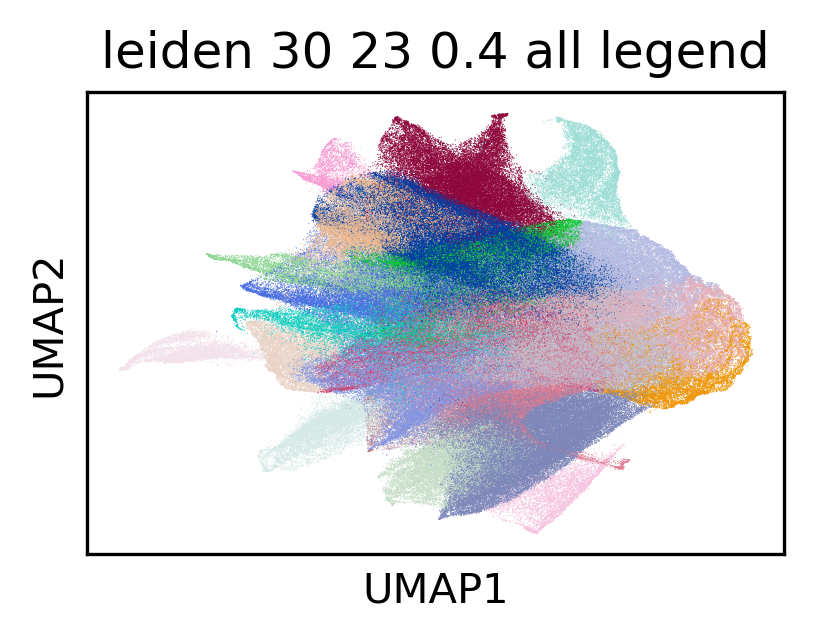

'20220118_JP-TMAs_s_30neighbors_23markers_all_leiden0.4.h5ad'

In [47]:
#unmarked stroma
#df_str = pd.read_csv(f'annotated_JP-TMA1-1_unmarked_stroma_{s_type}.csv',index_col=0)
#df_str = pd.read_csv(f'annotated_JP-TMAs_unmarked_stroma_{s_type}.csv',index_col=0)
fig,ax = plt.subplots(figsize=(3,2),dpi=300)
figname=f'leiden_{n_neighbors}_{n_markers}_{resolution}_{s_type}_legend.pdf'
sc.pl.umap(adata, color='leiden',ax=ax,save=figname,legend_loc=None,title=figname.split('.pdf')[0].replace('_',' '))
results_file

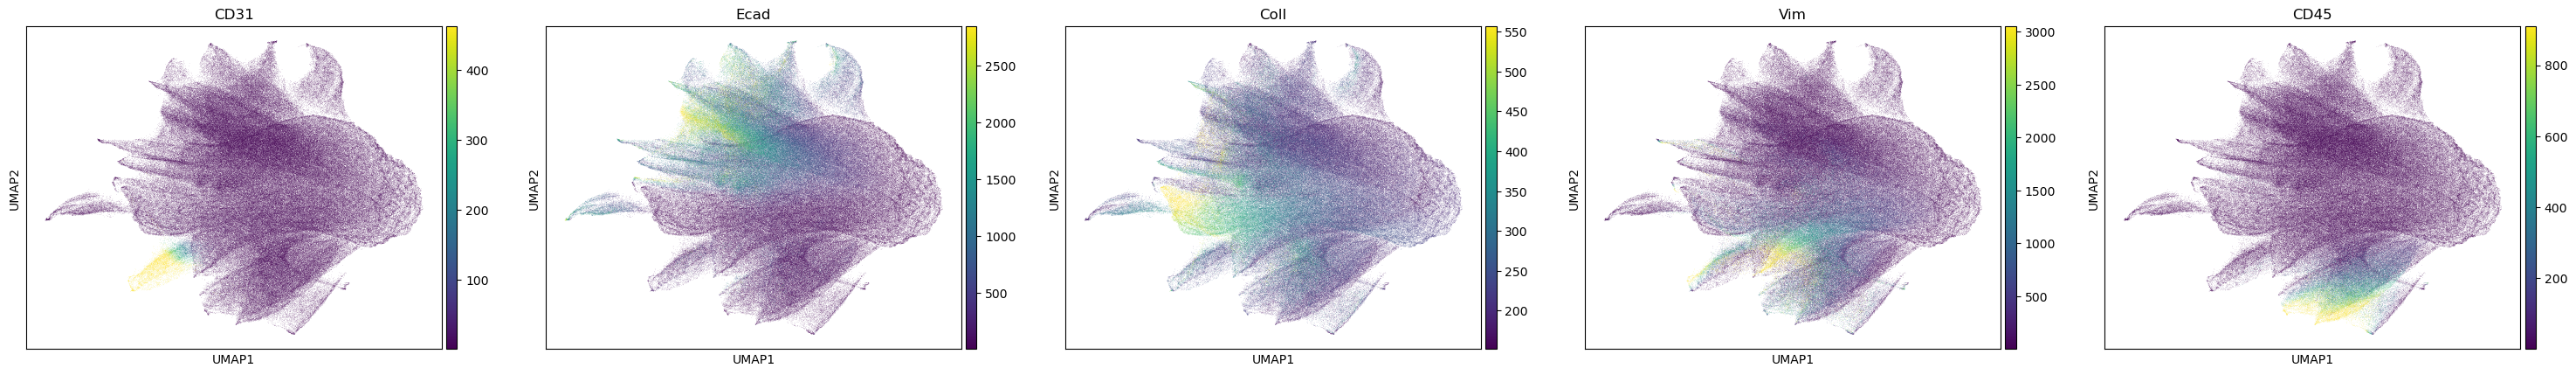

In [13]:
ls_col = ['CD31','Ecad','ColI','Vim','CD45']
figname = f"Umap_markers_{n_neighbors}neighbors_{len(ls_col)}markers_{s_type}.png"
title=figname.split('.png')[0].replace('_',' ')
sc.pl.umap(adata, color=ls_col,vmin='p1.5',vmax='p99',ncols=5,save=figname)

In [14]:
# annotate
df_p = adata.to_df()
df_p['leiden'] = adata.obs['leiden'].astype('str')

'''OLD #df_p = pd.DataFrame(data=adata.X,index=adata.obs.index,columns=adata.var.index)
#ls_merge = ['17', '12', '14','20','10','4']
#df_p.loc[df_p.leiden.isin(ls_merge),'leiden'] = '20'
if results_file == '20211207_JP-TMA1_15neighbors_30markers_TNBC_leiden0.4.h5ad':
    print('merging')
    df_p.loc[df_p.index.isin(df_str.index),'leiden'] = '20'
elif results_file == '20211207_JP-TMA1_30neighbors_30markers_TNBC_leiden0.4.h5ad':
    print('merging')
    df_p.loc[df_p.leiden.isin(['16','18','20']),'leiden'] = '16'
'''
if results_file =='20211207_JP-TMA1_30neighbors_33markers_ER+_leiden0.4.h5ad':
    tum_clust = ['8', '9', '10', '0', '11', '4', '13','12','3']
    str_clust = ['15', '5', '7','14'] #14 is macrophage
    imm_clust = ['1','2'] 
    endo_clust = ['6']
elif results_file == '20211207_JP-TMA1_15neighbors_32markers_TNBC_leiden0.4.h5ad': #10 is in epithelial half (caused by laminAC)
    tum_clust=['21','17','14', '20','2','3', '11', '9', '13', '18', '8', '7','5']
    str_clust = ['0', '1', '10', '12',  '15',  '19',   '22', '6'] 
    imm_clust = ['4','16'] #0 is macrophage
    endo_clust = ['12']
elif results_file == '20211207_JP-TMA1_15neighbors_30markers_TNBC_leiden0.4_old.h5ad':
    tum_clust=['21','14','4','2', '9', '18', '11', '5', '7', '15', '20', '3', '19', '10',]
    str_clust = ['0', '1', '12',  '16', '17',  '22', '23', '24', '25', '26',  '8'] 
    imm_clust = ['6','13'] # 0 macrophage
    endo_clust = ['1','20','8']
elif results_file == '20211207_JP-TMA1_16neighbors_30markers_TNBC_leiden0.4.h5ad':
    tum_clust=[ '18', '11', '5',  '3', '19', '10', '1', '13', '14',  '6', '8','7']
    str_clust = ['17','20','0',  '12',  '16',  '21', '22', '23', '24', '25'] 
    imm_clust = ['4','15'] # 0 macrophage
    endo_clust = ['2','9']  
elif results_file == '20211207_JP-TMA1_15neighbors_30markers_TNBC_leiden0.4.h5ad':
    tum_clust=['5','21','17','4', '10', '12', '13', '7', '15', '6', '3', '19', '9']#17 and 21 split
    str_clust = ['0',  '11', '16',  '18', '20',    '22',  ] #'23', '24', '25', 
    imm_clust = ['2','14'] # 0 macrophage
    endo_clust = ['1','8']
elif results_file =='20211207_JP-TMA1_30neighbors_30markers_TNBC_leiden0.4.h5ad':
    tum_clust = ['15','1', '7', '11', '3', '19', '5', '4', '17','6', '9']
    str_clust = ['0', '10', '12', '13',  '16', '18', '2', '20', ] #16 18 20 unmarked
    imm_clust = ['14','8']
    endo_clust = ['2','10']
elif results_file == '20211221_JP-TMAs_30neighbors_30markers_TNBC_leiden0.4.h5ad':
    ls_merge = ['30', '26', '29', '28', '31', '33',]
    df_p.loc[df_p.leiden.isin(ls_merge),'leiden'] = '26'
    ls_merge = ['21', '34',]
    df_p.loc[df_p.leiden.isin(ls_merge),'leiden'] = '21'
    tum_clust = []
    str_clust = [ ] #16 18 20 unmarked
    imm_clust = []
    endo_clust = []    
elif results_file =='20211221_JP-TMAs_30neighbors_30markers_TNBC_leiden0.3.h5ad':
    ls_merge = ['17', '22', '20', '24',]
    df_p.loc[df_p.leiden.isin(ls_merge),'leiden'] = '17'
    ls_merge = ['25','1']
    df_p.loc[df_p.leiden.isin(ls_merge),'leiden'] = '1'
    #ls_merge = ['19','26']
    #df_p.loc[df_p.leiden.isin(ls_merge),'leiden'] = '19'
    tum_clust = ['7','13','5', '26', '4', '11', '25', '19', '1', '6', '12', '10', '9', '16', '21', '14',] #7 is tum
    str_clust = [ '15', '17', '2',  '23',  '3',  '8'] 
    imm_clust = ['0','18']
    endo_clust = ['23']   
elif results_file == '20211221_JP-TMAs_s_30neighbors_21markers_2sub_leiden0.5.h5ad':
    print('both')
    #unmarked stroma
    ls_merge = ['34', '35', '38','36', '41', '33', '37','28','19'] #include 19
    df_p.loc[df_p.leiden.isin(ls_merge),'leiden'] = '19'
    ls_merge = ['32','17']
    #low expressing tumor
    df_p.loc[df_p.leiden.isin(ls_merge),'leiden'] = '17'
    #some colI
    ls_merge = ['29','39']
    df_p.loc[df_p.leiden.isin(ls_merge),'leiden'] = '29'
elif results_file == '20220118_JP-TMAs_s_30neighbors_22markers_2sub_leiden0.5.h5ad':
    tum_clust = ['13', '15', '27', '16', '0', '11', '24', '5', '1', '3', '9',
                  '4', '14', '20', ] 
    str_clust = [] 
    imm_clust = ['2','6','25'] # 8 is macrophage
    endo_clust = ['22']   
elif results_file == '20220118_JP-TMAs_s_30neighbors_22markers_2sub_leiden0.4.h5ad':
    print('good one')
    tum_clust = ['22', '17', '24', '1', '11',  '6', '20', '0', '14', '3', '15',  '2t','10',] #2 is t/str '21'and 24, merege to 1
    str_clust = ['12', '13', '16', '18', '7', '8', '2s'] 
    imm_clust = ['4','5','23','9'] # 9 is macrophage
    endo_clust = ['19']  
    fb_clust = ['7','8','12']
    #split 2 into tum and stroma
    df_p= df_p.merge(df_man.loc[:,['celltype']],left_index=True,right_index=True)
    df_p.leiden = df_p.leiden.astype('str')
    df_p.loc[((df_p.leiden=='2')& (df_p.celltype!='tumor')),'leiden'] = '2s'
    df_p.loc[((df_p.leiden=='2')& (df_p.celltype=='tumor')),'leiden'] = '2t'
    #print((df_p.leiden=='24').sum())
    #pgr not good ab
    ls_merge = ['24','21','17','1']
    df_p = df_p.drop('PgR',axis=1)
    df_p.loc[df_p.leiden.isin(ls_merge),'leiden'] = '1'
    #colI+ vim+ FB
    ls_merge = ['18','8'] #13 is colI-
    df_p.loc[df_p.leiden.isin(ls_merge),'leiden'] = '8'
    #merge lum t
    ls_merge = ['22','0'] 
    df_p.loc[df_p.leiden.isin(ls_merge),'leiden'] = '0'
    #merge CK lo t
    ls_merge = ['14','3','16'] 
    df_p.loc[df_p.leiden.isin(ls_merge),'leiden'] = '3'
    #fix prolif
    df_p.loc[((df_p.index.str.contains('JP-TMA1-1')) & (df_p.Ki67 > 0.2)),'leiden'] = '6'
elif results_file == '20220118_JP-TMAs_s_30neighbors_23markers_all_leiden0.4.h5ad':
    print('good one all subtypes')
    #split CD44 into tum and stroma
    df_p= df_p.merge(df_man.loc[:,['celltype']],left_index=True,right_index=True)
    df_p.leiden = df_p.leiden.astype('str')
    df_p.loc[((df_p.leiden=='3')& (df_p.celltype!='tumor')),'leiden'] = '3s'
    df_p.loc[((df_p.leiden=='3')& (df_p.celltype=='tumor')),'leiden'] = '3t'
    tum_clust = ['4', '12', '15', '18','5', '20','17','3t','0','11','7','22'] #11 ck lo 7 ecad lo
    str_clust = ['16', '8']
    imm_clust = ['13','1','21','9'] #9 is macrophage
    endo_clust = ['19']
    fb_clust = ['14','6','10','2','3s']
    
#df_p.groupby('leiden').mean().Ecad.sort_values(ascending=False).index
#set(df_p.groupby('leiden').mean().CK19.sort_values(ascending=False).index) - set(tum_clust + imm_clust )
#set(tum_clust)

good one all subtypes


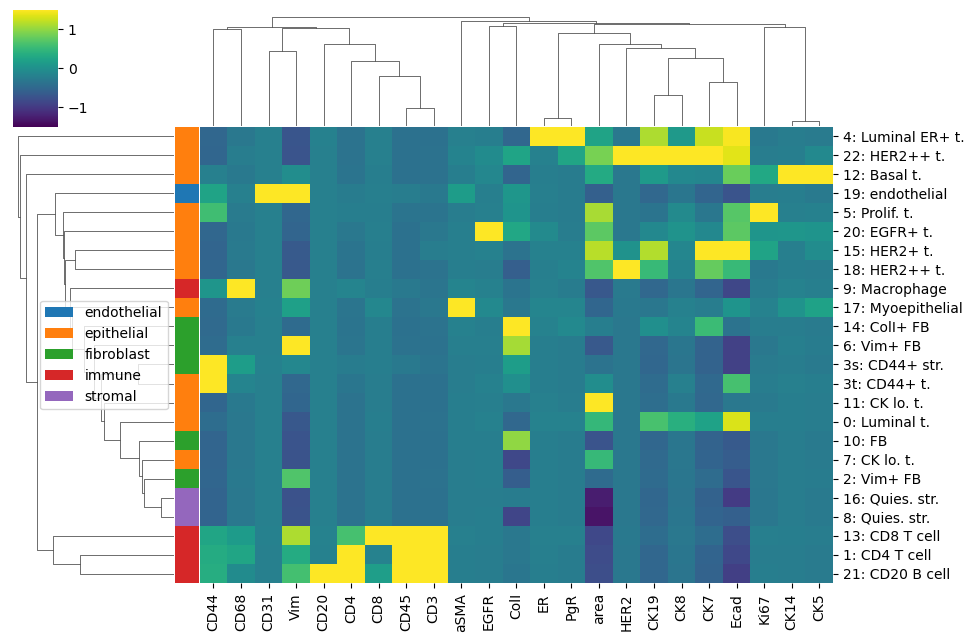

In [21]:
#clustermap
b_annot = True

d_named = {'4':'Luminal ER+ t.', '12':'Basal t.', '15':'HER2+ t.', '18':'HER2++ t.','22':'HER2++ t.', '19':'endothelial', '20':'EGFR+ t.', '5':'Prolif. t.',
 '9':'Macrophage', '17':'Myoepithelial', '14':'ColI+ FB', '6':'Vim+ FB', '10':'FB', '16':'Quies. str.', '8':'Quies. str.',
 '2':'Vim+ FB', '7':'CK lo. t.', '3s':'CD44+ str.', '3t':'CD44+ t.', '0':'Luminal t.', '11':'CK lo. t.', '13':'CD8 T cell',
 '1':'CD4 T cell', '21':'CD20 B cell'}

d_replace = {}
d_replace.update(dict(zip(tum_clust,[f'epithelial' for item in tum_clust])))
d_replace.update(dict(zip(str_clust,[f'stromal' for item in str_clust])))
d_replace.update(dict(zip(imm_clust,[f'immune' for item in imm_clust])))
d_replace.update(dict(zip(endo_clust,[f'endothelial' for item in endo_clust])))
d_replace.update(dict(zip(fb_clust,[f'fibroblast' for item in fb_clust])))
df_plot = df_p.groupby('leiden').mean()

df_plot.index.name = f'leiden {resolution}'
d_color = dict(zip(['endothelial', 'epithelial', 'fibroblast', 'immune', 'stromal'],sns.color_palette()[0:5]))
if b_annot:
    row_colors = df_plot.index.astype('str').map(d_replace).map(d_color)
    g = sns.clustermap(df_plot,z_score=1,figsize=(9,6.5),cmap='viridis',row_colors=row_colors,#method='single',
                   vmin=-1.5,vmax=1.5)
    for label in d_color.keys():
        g.ax_row_dendrogram.bar(0, 0, color=d_color[label],
                                label=label, linewidth=0)
    g.ax_row_dendrogram.legend(loc="right", ncol=1)
    g.ax_heatmap.set_ylabel('')
    marker_genes = df_plot.iloc[:,g.dendrogram_col.reordered_ind].columns.tolist()
    categories_order = df_plot.iloc[g.dendrogram_row.reordered_ind,:].index.tolist()
    labels = [f"{item}: {d_named[item]}" for item in categories_order]
    g.ax_heatmap.set_yticklabels(labels)
else:
    g = sns.clustermap(df_plot,z_score=1,figsize=(9,6),cmap='viridis',#row_colors=row_colors,#method='single',
                   vmin=-1.5,vmax=1.5)
g.savefig(f'{codedir}/{s_date}/{s_sample}_clustermap_{n_neighbors}_{n_markers}markers_{s_type}_leiden{resolution}.pdf',dpi=300)


In [18]:
s_date

'20220408'

In [22]:
#ER+ leiden 0.6 notes 34 markers
#look for artifact: REMOVE: 20
#20 scene35 - most of this tissue is faint AF in EGFR,HER2,PDPN. take out 20, but sacrifice scene 35
#20 scene 108 most of tumor lost, maybe analysis @ an ealier round would be better?, looks like R1c1 AF
#21 looks like a patch of smooth muscle in 42, myoepithelial in 98
#15 is endothelial
#24 are immune CD20, out of focus. Could merge with 5
#19 is tumor with PD1 bright dots: need to exclude cells with extremely high PD1 (scene007 and 073)
#10 grnzb in a few cells. could merge with 1 and 23. take out grnzb from clustering
# 8 small cells because of unfocesed DAPI in scene 32. remove area? 
#22 is very PgR bright.
#23 is tumor, segmentation not great - lots of eccentricity. can't trust morphology much in some of these cores
#plan: recluster: take out PD1, GRNZ, area, eccentricity, DAPI11 cluster 20 

#ER+ 32 markers leiden 0.6 notes
# 17 is real, take out R1 c2
#don't understand 12. HER2 driven?? filter outliers HER2 q=.99999
#filter ouliters PD1: real PD1 is maximum 800-maybe 1300,use q=.9993.  artifact is 1600+
#28 Ki67 ... weird

#20220408
#15 and 18 are her2+


s_clust = '17'
df_p['slide_scene'] = [item.split('_cell')[0] for item in df_p.index]
df_p.groupby(['leiden','slide_scene']).count().loc[s_clust].iloc[:,1].sort_values(ascending=False)[0:30]

slide_scene
JP-TMA2-1_scene32     1693
JP-TMA1-1_scene070     901
JP-TMA1-1_scene121     799
JP-TMA2-1_scene12      587
JP-TMA2-1_scene31      383
JP-TMA1-1_scene042     288
JP-TMA1-1_scene077     263
JP-TMA1-1_scene098     261
JP-TMA2-1_scene04      252
JP-TMA2-1_scene33      228
JP-TMA1-1_scene071     174
JP-TMA1-1_scene106     164
JP-TMA1-1_scene095     157
JP-TMA1-1_scene017     156
JP-TMA2-1_scene28      155
JP-TMA2-1_scene29      143
JP-TMA1-1_scene025     138
JP-TMA1-1_scene039     137
JP-TMA1-1_scene011     122
JP-TMA1-1_scene080     116
JP-TMA1-1_scene119     112
JP-TMA1-1_scene029     111
JP-TMA2-1_scene10      107
JP-TMA2-1_scene40       98
JP-TMA2-1_scene19       92
JP-TMA1-1_scene032      89
JP-TMA1-1_scene044      87
JP-TMA2-1_scene08       84
JP-TMA1-1_scene081      82
JP-TMA1-1_scene109      74
Name: CD44, dtype: int64

In [23]:
from mplex_image import analyze
df_data = df_norm
colors = mpl.cm.tab20b.colors + mpl.cm.tab20c.colors

df_pos = analyze.celltype_to_bool(df_p,'leiden')
df_pos.columns = [str(item) for item in df_pos.columns]

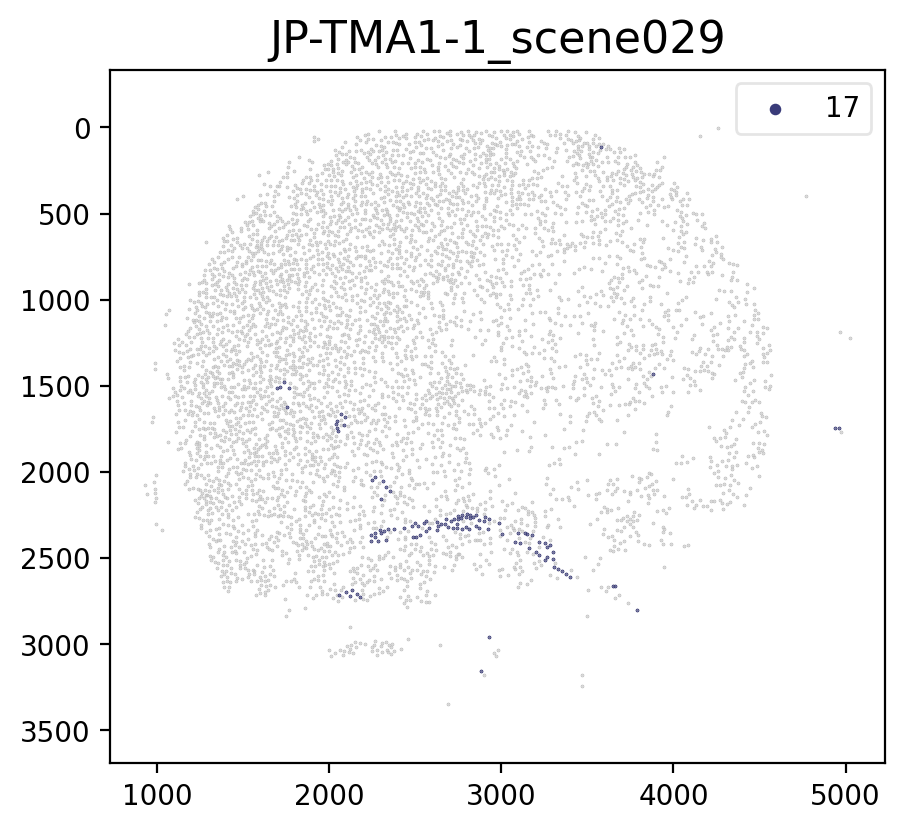

In [24]:
#plot all groups spatially - leiden 
for s_slide in sorted(set(df_p.slide_scene)):
    s_slide = 'JP-TMA1-1_scene029'#JP-TMA1-1_scene055'#'JP-TMA1-1_scene068'#'JP-TMA1-1_scene039'#'JP-TMA1-1_scene055'#'JP-TMA1-1_scene041'#'JP-TMA1-1_scene036'#'JP-TMA1-1_scene048'#'JP-TMA1-1_scene034'#'JP-TMA1-1_scene029'#'JP-TMA1-1_scene007'#'JP-TMA1-1_scene021'
    #s_slide = 'JP-TMA2-1_scene24' #'JP-TMA1-1_scene099'#'JP-TMA1-1_scene082'#'JP-TMA2-1_scene24'
    fig,ax = plt.subplots(figsize=(5,4.5),dpi=200)
    #plot negative cells
    df_scene = df_data[df_data.index.str.contains(s_slide)]
    ax.scatter(data=df_scene,x='DAPI_X',y='DAPI_Y',color='silver',s=0.1,label=f'')
    #for idxs, s_color_int in enumerate(range(len(df_pos.columns))):
    for idxs, s_color in enumerate(df_pos.columns):
        s_color = s_clust
        s_color = str(s_color)
        if len(df_p[(df_p.slide_scene==s_slide) & (df_pos.loc[:,s_color])])>=1:
            #plot positive cells
            ls_index = df_p[(df_p.slide_scene==s_slide) & (df_pos.loc[:,s_color])].index
            ax.scatter(data=df_data.loc[ls_index],x='DAPI_X',y='DAPI_Y',label=f'{s_color}',s=0.1,color=colors[idxs])
        break
    ax.set_title(f"{s_slide}", fontsize=16) # \n {d_a[s_slide]}
    ax.axis('equal')
    ax.set_ylim(ax.get_ylim()[::-1])
    #ax.set_xticklabels('')
    #ax.set_yticklabels('')
    #break
    plt.legend(markerscale=10,framealpha=.5) 
    #fig.savefig(f'{codedir}/{s_date}/{s_slide}_leiden{resolution}_scatterplot.pdf')
    break

/home/exacloud/gscratch/Chin_Lab/engje/bin/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'leiden' as categorical


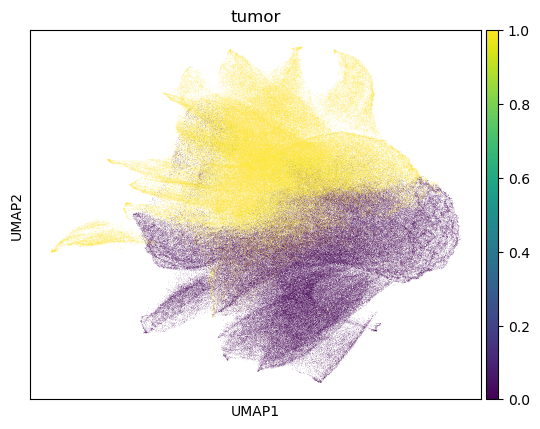

0.5058237816858506


In [25]:
ls_merge = tum_clust# fb_clust #tum_clust #['0','12'] #16
adata.obs.leiden = df_p.leiden
adata.obs['test'] = (adata.obs.leiden.isin(ls_merge)).replace({True:1,False:0})
sc.pl.umap(adata, color='test',title='tumor')
print(sum(adata.obs['test'])/len(adata))

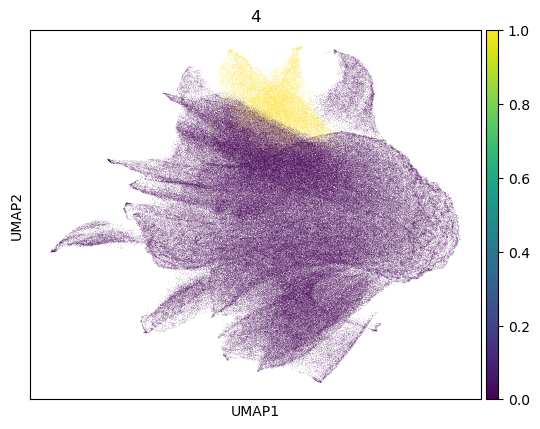

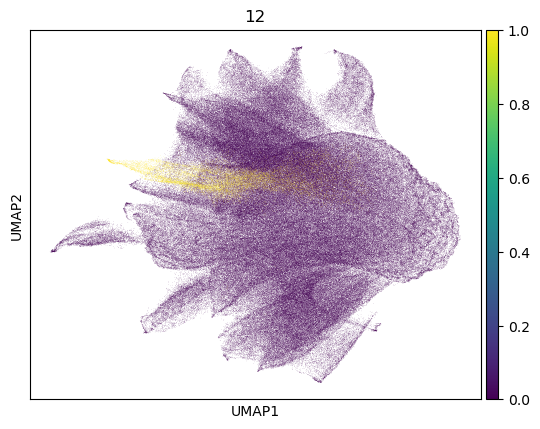

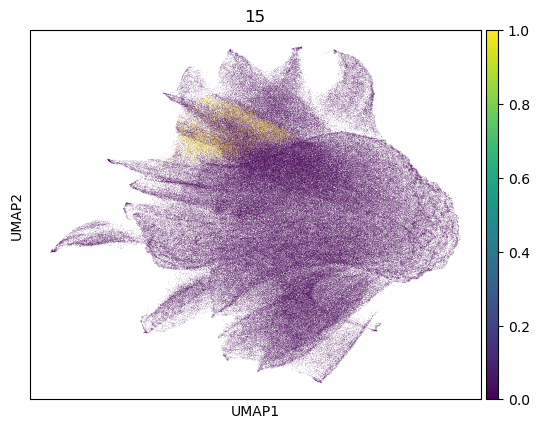

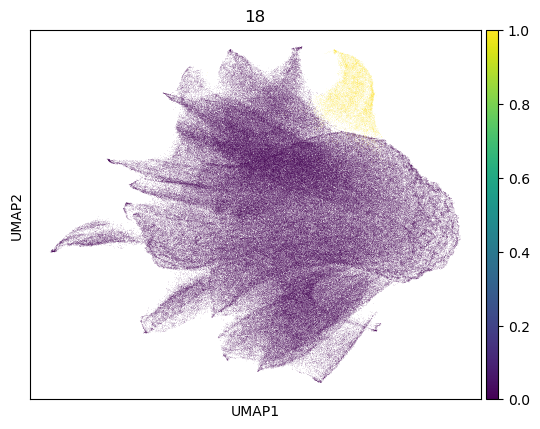

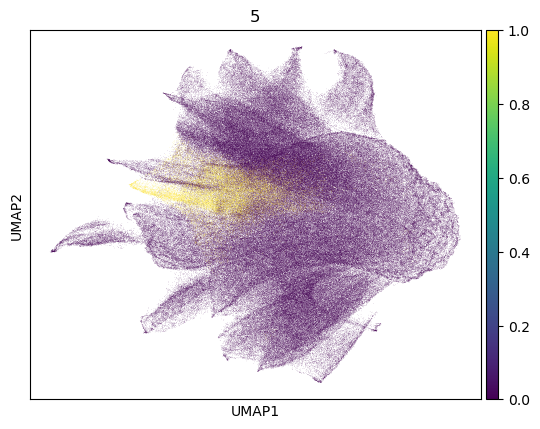

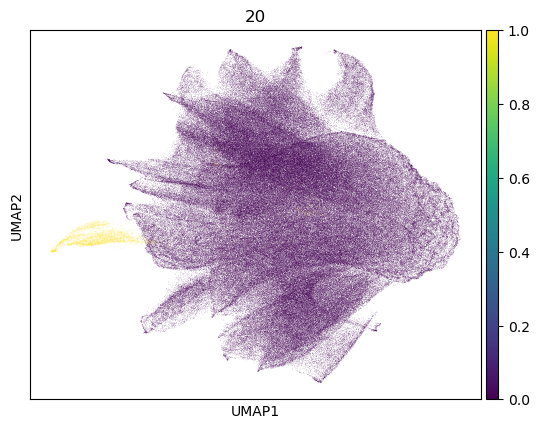

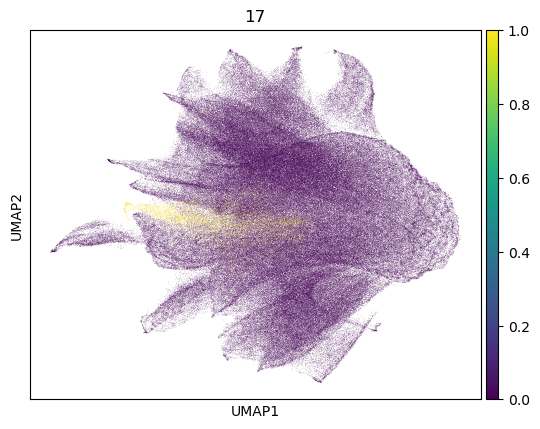

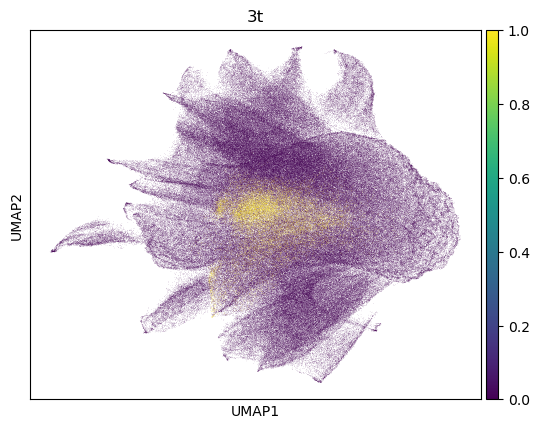

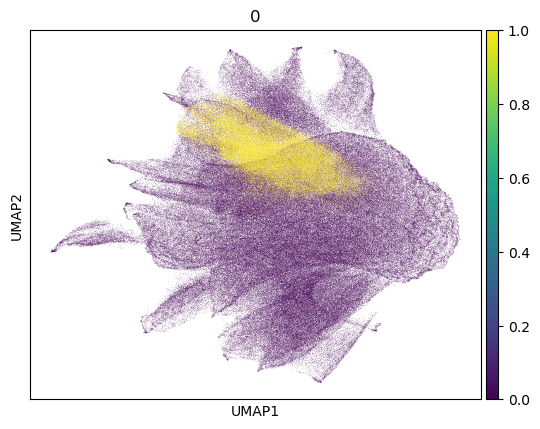

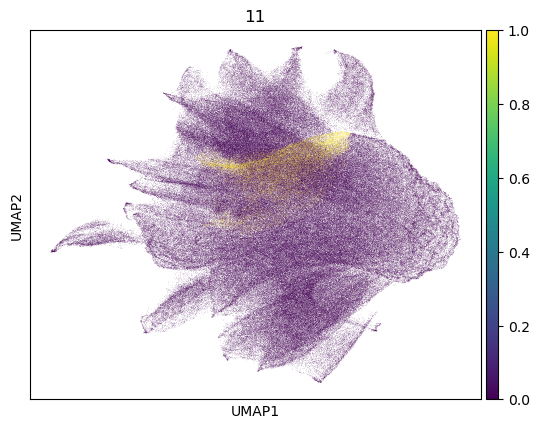

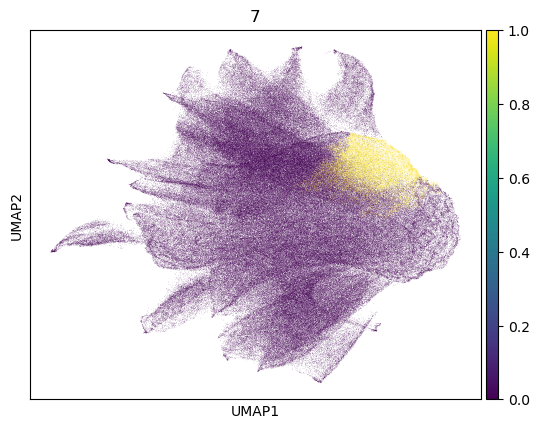

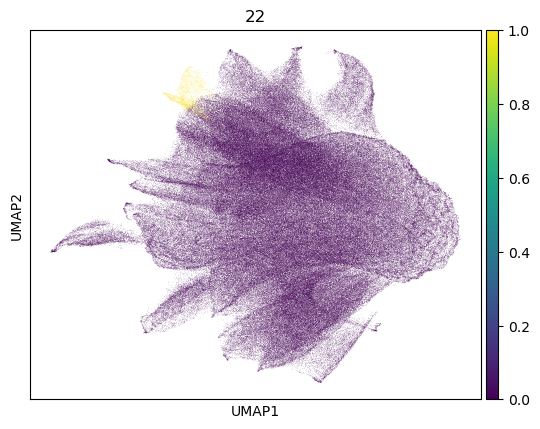

In [26]:
for s_merge in tum_clust:
    ls_merge = [s_merge]
    adata.obs['test'] = (adata.obs.leiden.isin(ls_merge)).replace({True:1,False:0})
    sc.pl.umap(adata, color='test',title=s_merge)

/home/exacloud/gscratch/Chin_Lab/engje/bin/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'leiden' as categorical


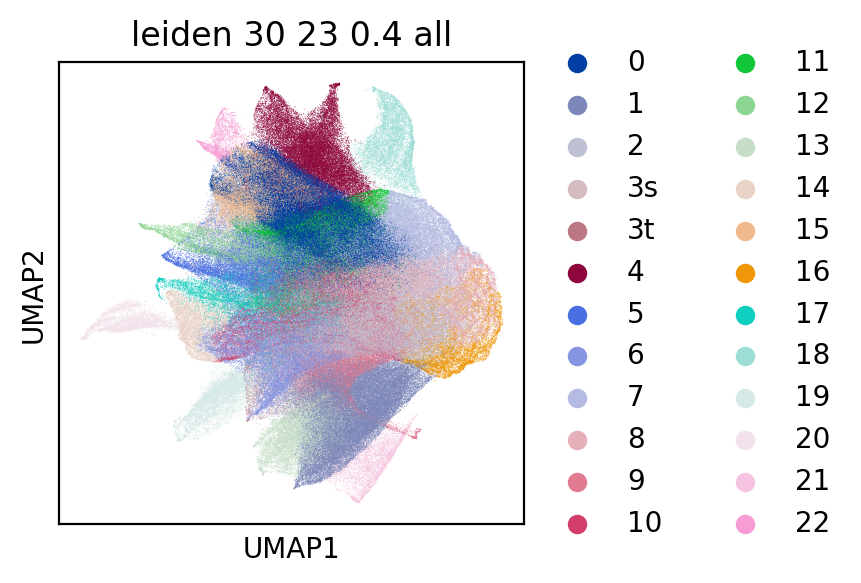

In [27]:
adata.obs['leiden'] = df_p['leiden']
fig,ax = plt.subplots(figsize=(3,3),dpi=200)
figname=f'leiden_{n_neighbors}_{n_markers}_{resolution}_{s_type}.png'
sc.pl.umap(adata, color='leiden',ax=ax,save=figname,title=figname.split('.png')[0].replace('_',' '))

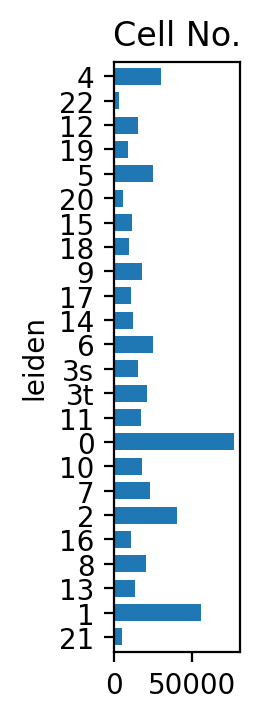

In [28]:
fig,ax=plt.subplots(figsize=(1.4,3.7),dpi=200)
df_p.groupby('leiden').count().loc[categories_order[::-1]].iloc[:,1].plot(kind='barh',title='Cell No.',ax=ax,width=0.7)
plt.tight_layout()
fig.savefig(f'{codedir}/{s_date}/barplot_{s_sample}_{n_neighbors}neighbors_{len(marker_genes)}markers_leiden{resolution}_{s_type}.png')

In [29]:
'''
d_group = {'00-13520-8C': 'epithelial_rich', '00-8939-2D': 'epithelial_rich', '01-16333-3D': 'stroma_rich', '01-20792-3H': 'stroma_rich',
 '01-22975-1E': 'stroma_rich', '02-5218-4K': 'epithelial_rich', '03-7604-1P': 'epithelial_rich', '90-526-2M': 'epithelial_rich',
 '90-8392-1A': 'stroma_rich', '92-10570-2E': 'epithelial_rich', '92-16604-B': 'stroma_rich', '92-20731-A': 'stroma_rich',
 '95-12547-3A': 'stroma_rich', '96-9792-1I': 'stroma_rich', '97-15244-1H': 'epithelial_rich', '98-15913-C': 'epithelial_rich',
 '99-23192-1B': 'epithelial_rich', '99-6921-F': 'epithelial_rich', 'JP-TMA2-1_scene01': 'epithelial_rich', 'JP-TMA2-1_scene02': 'epithelial_rich',
 'JP-TMA2-1_scene03': 'epithelial_rich', 'JP-TMA2-1_scene04': 'epithelial_rich', 'JP-TMA2-1_scene05': 'stroma_rich', 'JP-TMA2-1_scene06': 'epithelial_rich',
 'JP-TMA2-1_scene07': 'epithelial_rich', 'JP-TMA2-1_scene09': 'stroma_rich', 'JP-TMA2-1_scene10': 'stroma_rich', 'JP-TMA2-1_scene11': 'stroma_rich',
 'JP-TMA2-1_scene12': 'epithelial_rich', 'JP-TMA2-1_scene13': 'epithelial_rich', 'JP-TMA2-1_scene14': 'epithelial_rich', 'JP-TMA2-1_scene15': 'stroma_rich',
 'JP-TMA2-1_scene16': 'epithelial_rich', 'JP-TMA2-1_scene17': 'epithelial_rich', 'JP-TMA2-1_scene18': 'epithelial_rich', 'JP-TMA2-1_scene19': 'stroma_rich',
 'JP-TMA2-1_scene20': 'epithelial_rich', 'JP-TMA2-1_scene21': 'epithelial_rich', 'JP-TMA2-1_scene22': 'epithelial_rich', 'JP-TMA2-1_scene23': 'epithelial_rich',
 'JP-TMA2-1_scene24': 'epithelial_rich', 'JP-TMA2-1_scene25': 'epithelial_rich', 'JP-TMA2-1_scene26': 'epithelial_rich', 'JP-TMA2-1_scene27': 'epithelial_rich',
 'JP-TMA2-1_scene28': 'stroma_rich', 'JP-TMA2-1_scene29': 'stroma_rich', 'JP-TMA2-1_scene30': 'stroma_rich', 'JP-TMA2-1_scene31': 'stroma_rich',
 'JP-TMA2-1_scene32': 'epithelial_rich', 'JP-TMA2-1_scene33': 'epithelial_rich', 'JP-TMA2-1_scene34': 'epithelial_rich', 'JP-TMA2-1_scene35': 'stroma_rich',
 'JP-TMA2-1_scene36': 'epithelial_rich', 'JP-TMA2-1_scene37': 'epithelial_rich', 'JP-TMA2-1_scene38': 'epithelial_rich', 'JP-TMA2-1_scene39': 'stroma_rich',
 'JP-TMA2-1_scene40': 'stroma_rich', 'JP-TMA2-1_scene41': 'stroma_rich', 'JP-TMA2-1_scene42': 'epithelial_rich'}
 '''

"\nd_group = {'00-13520-8C': 'epithelial_rich', '00-8939-2D': 'epithelial_rich', '01-16333-3D': 'stroma_rich', '01-20792-3H': 'stroma_rich',\n '01-22975-1E': 'stroma_rich', '02-5218-4K': 'epithelial_rich', '03-7604-1P': 'epithelial_rich', '90-526-2M': 'epithelial_rich',\n '90-8392-1A': 'stroma_rich', '92-10570-2E': 'epithelial_rich', '92-16604-B': 'stroma_rich', '92-20731-A': 'stroma_rich',\n '95-12547-3A': 'stroma_rich', '96-9792-1I': 'stroma_rich', '97-15244-1H': 'epithelial_rich', '98-15913-C': 'epithelial_rich',\n '99-23192-1B': 'epithelial_rich', '99-6921-F': 'epithelial_rich', 'JP-TMA2-1_scene01': 'epithelial_rich', 'JP-TMA2-1_scene02': 'epithelial_rich',\n 'JP-TMA2-1_scene03': 'epithelial_rich', 'JP-TMA2-1_scene04': 'epithelial_rich', 'JP-TMA2-1_scene05': 'stroma_rich', 'JP-TMA2-1_scene06': 'epithelial_rich',\n 'JP-TMA2-1_scene07': 'epithelial_rich', 'JP-TMA2-1_scene09': 'stroma_rich', 'JP-TMA2-1_scene10': 'stroma_rich', 'JP-TMA2-1_scene11': 'stroma_rich',\n 'JP-TMA2-1_scene12':

In [33]:

df_p['slide'] = [item.split('_cell')[0] for item in df_p.index]
df_p['Patient'] = df_p.slide.map(dict(zip(df_cyc_a.index,df_cyc_a.Accession)))
'''
df_p['Group'] = df_p.Patient.map(d_group)

se_plot = df_p[df_p.Group!='not_tumor'].groupby(['leiden','Group']).count().loc[categories_order[::-1]].iloc[:,1]
se_plot_frac = se_plot/df_p[df_p.Group!='not_tumor'].groupby(['Group']).count().iloc[:,1]
fig,ax=plt.subplots(figsize=(2.5,5),dpi=200)
sns.barplot(data=se_plot_frac.reset_index(),y='leiden',x='CD44',hue='Group',orient='h',order=categories_order,ax=ax,hue_order=['stroma_rich','epithelial_rich'])
ax.set_xlabel('Fraction of Cells')
ax.legend(bbox_to_anchor=(0.3,1.01))
fig.savefig(f'{codedir}/{s_date}/barplot_{n_neighbors}neighbors_{len(marker_genes)}markers_leiden{resolution}_bygroup.png')
'''

"\ndf_p['Group'] = df_p.Patient.map(d_group)\n\nse_plot = df_p[df_p.Group!='not_tumor'].groupby(['leiden','Group']).count().loc[categories_order[::-1]].iloc[:,1]\nse_plot_frac = se_plot/df_p[df_p.Group!='not_tumor'].groupby(['Group']).count().iloc[:,1]\nfig,ax=plt.subplots(figsize=(2.5,5),dpi=200)\nsns.barplot(data=se_plot_frac.reset_index(),y='leiden',x='CD44',hue='Group',orient='h',order=categories_order,ax=ax,hue_order=['stroma_rich','epithelial_rich'])\nax.set_xlabel('Fraction of Cells')\nax.legend(bbox_to_anchor=(0.3,1.01))\nfig.savefig(f'{codedir}/{s_date}/barplot_{n_neighbors}neighbors_{len(marker_genes)}markers_leiden{resolution}_bygroup.png')\n"

## add celltypes

/home/exacloud/gscratch/Chin_Lab/engje/bin/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'leidencelltype3' as categorical


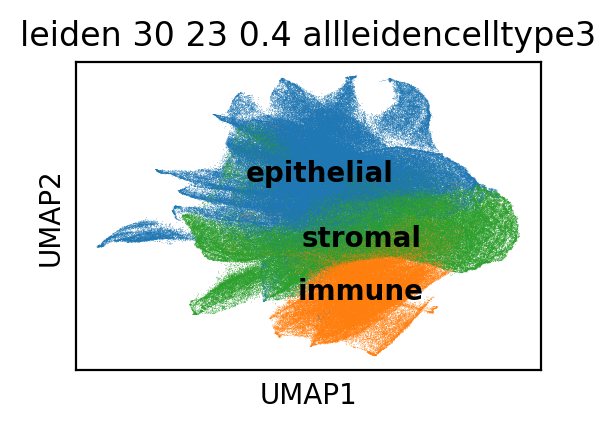

In [34]:
df_p.loc[df_p.leiden.isin(tum_clust),'leidencelltype3'] = 'epithelial'
df_p.loc[df_p.leiden.isin(str_clust),'leidencelltype3'] = 'stromal'
df_p.loc[df_p.leiden.isin(fb_clust),'leidencelltype3'] = 'stromal'
df_p.loc[df_p.leiden.isin(endo_clust),'leidencelltype3'] = 'stromal'
df_p.loc[df_p.leiden.isin(imm_clust),'leidencelltype3'] = 'immune'
adata.obs['leidencelltype3'] = df_p.leidencelltype3
fig,ax = plt.subplots(figsize=(3,2),dpi=200)
figname=f'leiden_{n_neighbors}_{n_markers}_{resolution}_{s_type}leidencelltype3.png'
sc.pl.umap(adata, color='leidencelltype3',ax=ax,save=figname,title=figname.split('.png')[0].replace('_',' '),legend_loc='on data')

/home/exacloud/gscratch/Chin_Lab/engje/bin/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'leidencelltype5' as categorical


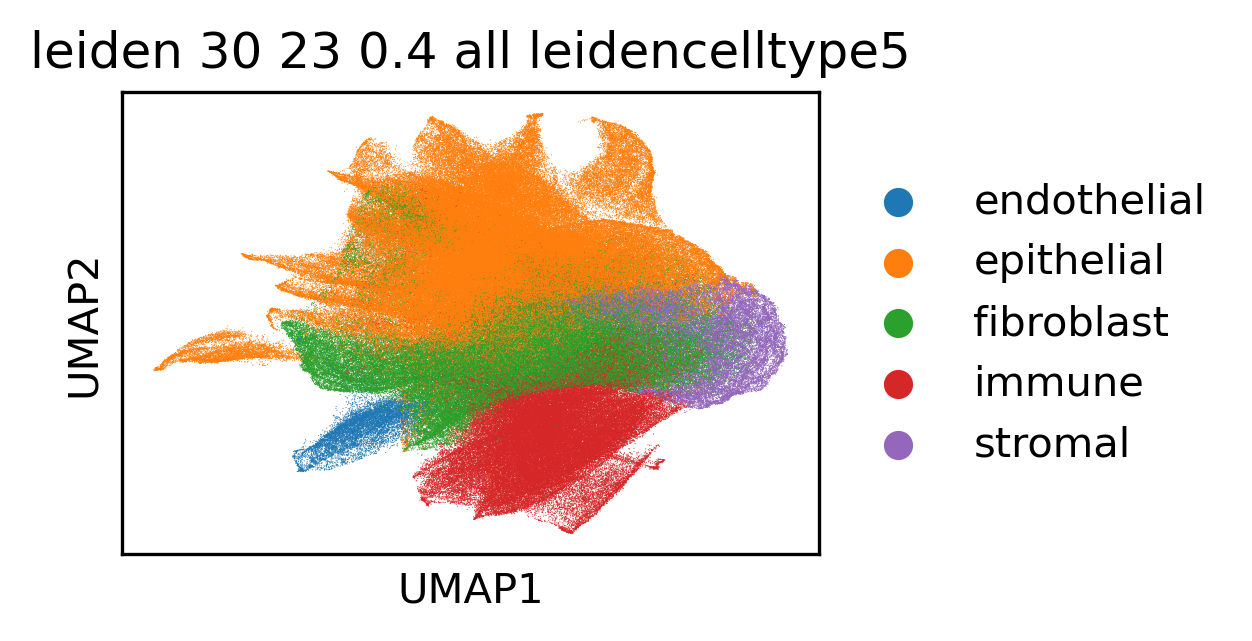

In [44]:
df_p.loc[df_p.leiden.isin(tum_clust),'leidencelltype5'] = 'epithelial'
df_p.loc[df_p.leiden.isin(str_clust),'leidencelltype5'] = 'stromal'
df_p.loc[df_p.leiden.isin(fb_clust),'leidencelltype5'] = 'fibroblast'
df_p.loc[df_p.leiden.isin(endo_clust),'leidencelltype5'] = 'endothelial'
df_p.loc[df_p.leiden.isin(imm_clust),'leidencelltype5'] = 'immune'
adata.obs['leidencelltype5'] = df_p.leidencelltype5
fig,ax = plt.subplots(figsize=(3,2),dpi=300)
figname=f'leiden_{n_neighbors}_{n_markers}_{resolution}_{s_type}_leidencelltype5.pdf'
sc.pl.umap(adata, color='leidencelltype5',ax=ax,save=figname,title=figname.split('.pdf')[0].replace('_',' '))

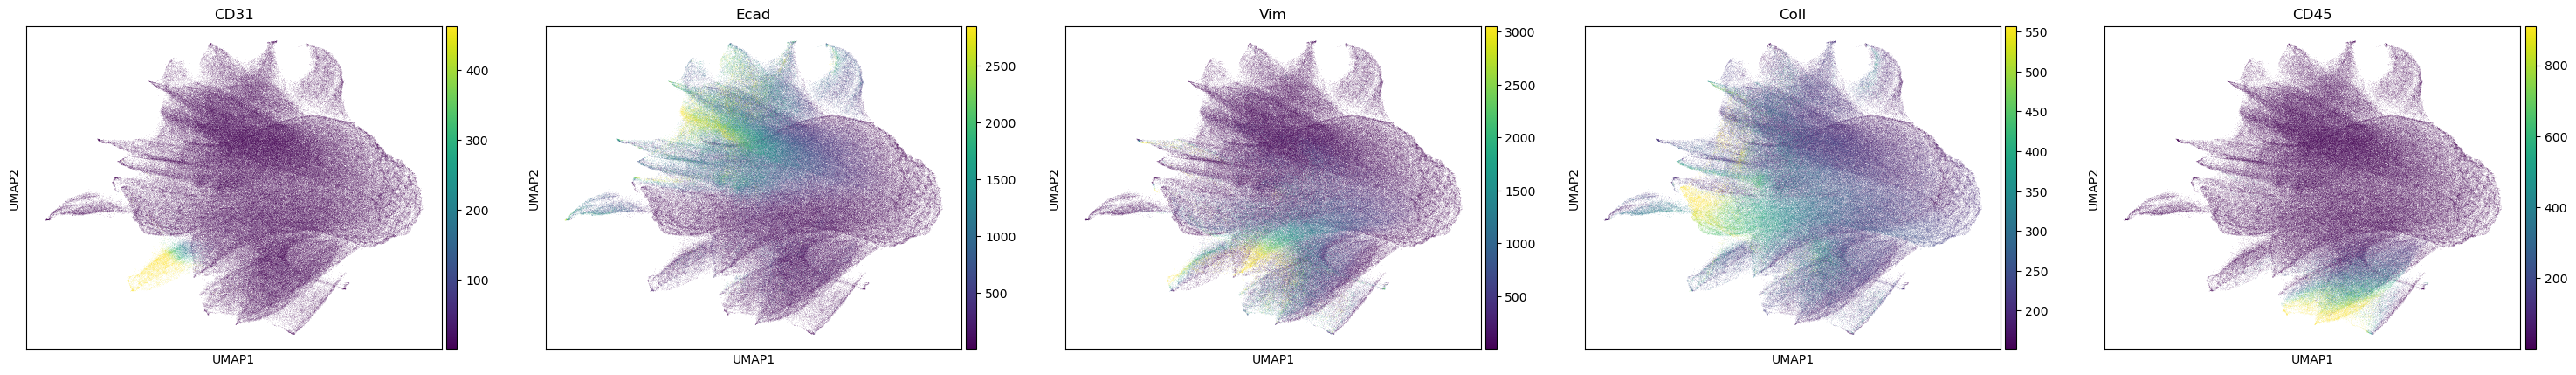

In [36]:
#visulaize
ls_col = ['CD31','Ecad','Vim','ColI','CD45']
figname = f"Umap_markers_{n_neighbors}neighbors_{len(ls_col)}markers_{s_type}.png"
title=figname.split('.png')[0].replace('_',' ')
sc.pl.umap(adata, color=ls_col,vmin='p1.5',vmax='p99',ncols=5,save=figname)

In [37]:
#df_p.groupby('slide').leidencelltype5.value_counts(normalize=True).unstack().sort_values(by='epithelial')[25:40]

/tmp/ipykernel_10299/3759163623.py:2: FutureWarning: Passing 'suffixes' which cause duplicate columns {'DAPI_Yc', 'DAPI_Xc'} in the result is deprecated and will raise a MergeError in a future version.
  df_p = df_p.merge(df_man.loc[:,['DAPI_X','DAPI_Y']],left_index=True,right_index=True,suffixes=('c',''))


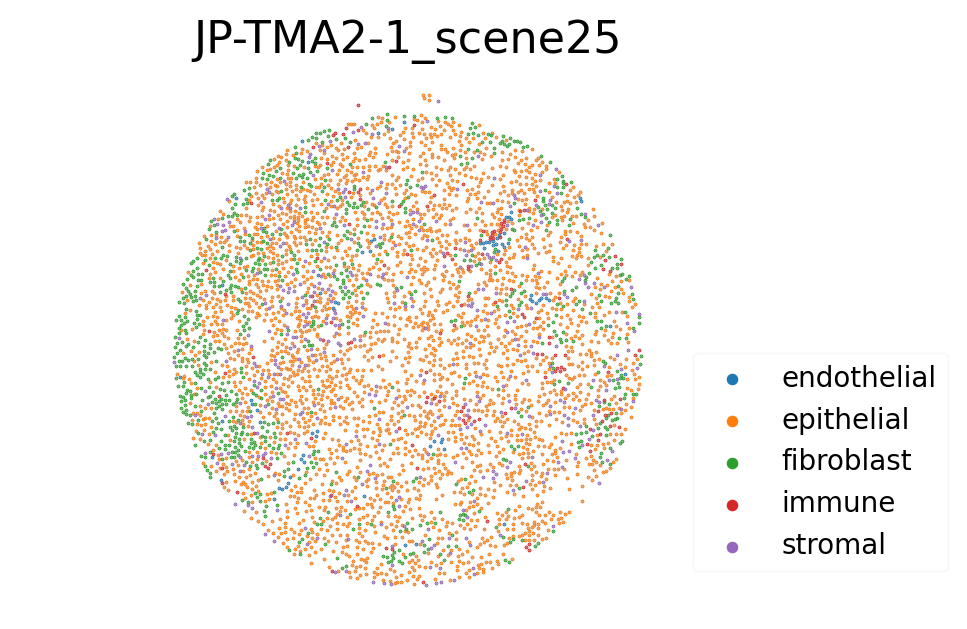

In [40]:
#plot all groups spatially  - manual
df_p = df_p.merge(df_man.loc[:,['DAPI_X','DAPI_Y']],left_index=True,right_index=True,suffixes=('c',''))
from mplex_image import analyze
s_cell = 'leidencelltype5'
df_p['slide'] = [item.split('_cell')[0] for item in df_p.index]
df_pos = analyze.celltype_to_bool(df_p,s_cell)
df_pos.columns = [str(item) for item in df_pos.columns]
for s_slide in sorted(set(df_p.slide)):
    s_slide = 'JP-TMA2-1_scene25'#'JP-TMA1-1_scene034'
    fig,ax = plt.subplots(figsize=(5,3.5),dpi=200)
    #plot negative cells
    df_scene =df_p[(df_p.slide==s_slide)]
    ax.scatter(data=df_scene,x='DAPI_X',y='DAPI_Y',color='silver',s=0.1,label=f'')
    #for idxs, s_color_int in enumerate(range(len(df_pos.columns))):
    for idxs, s_color in enumerate(df_pos.columns):
        #print(s_color)
        #s_color = str(s_color_int)
        if len(df_p[(df_p.slide==s_slide) & (df_pos.loc[:,s_color])])>=1:
            #plot positive cells
            ax.scatter(data=df_p[(df_p.slide==s_slide) & (df_pos.loc[:,s_color])],x='DAPI_X',y='DAPI_Y',
                                                                        label=f'{s_color}',s=0.1,color=mpl.cm.tab10.colors[idxs])
        #break
    ax.set_title(f"{s_slide}", fontsize=16)
    ax.axis('equal')
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for spines in ['left','right','top','bottom']:
        ax.spines[spines].set_visible(False)

    #break
    plt.legend(markerscale=10,framealpha=.1,bbox_to_anchor=(.85,.5)) 
    fig.savefig(f'{codedir}/figures/{s_slide}_gated_{s_cell}_scatterplot.pdf')
    break

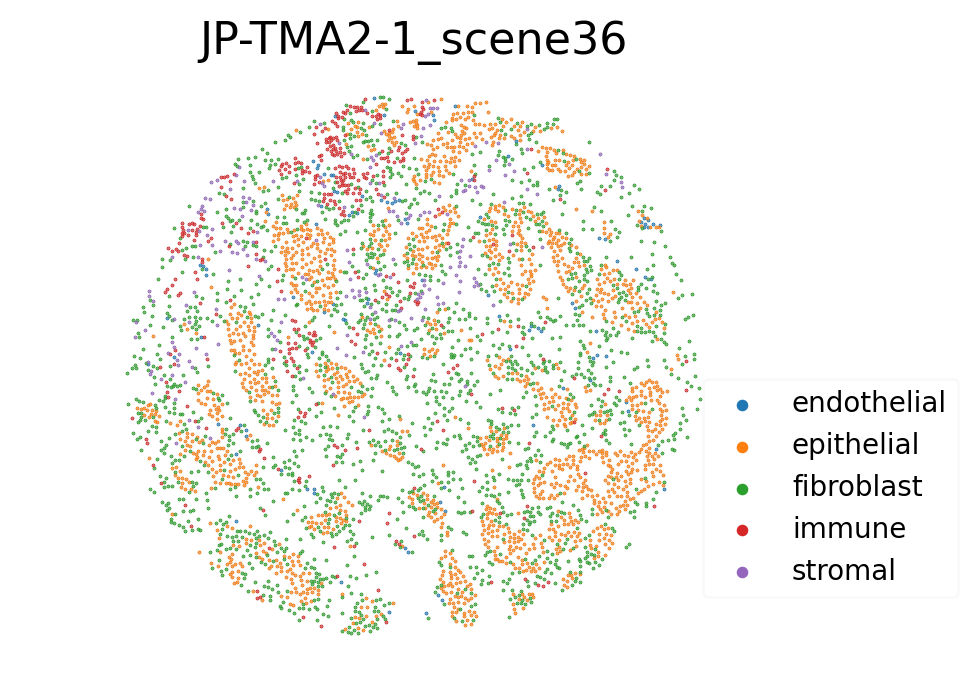

In [43]:
for s_slide in sorted(set(df_p.slide)):
    s_slide = 'JP-TMA2-1_scene36'#'JP-TMA1-1_scene034'
    fig,ax = plt.subplots(figsize=(5,3.5),dpi=200)
    #plot negative cells
    df_scene =df_p[(df_p.slide==s_slide)]
    ax.scatter(data=df_scene,x='DAPI_X',y='DAPI_Y',color='silver',s=0.1,label=f'')
    #for idxs, s_color_int in enumerate(range(len(df_pos.columns))):
    for idxs, s_color in enumerate(df_pos.columns):
        #print(s_color)
        #s_color = str(s_color_int)
        if len(df_p[(df_p.slide==s_slide) & (df_pos.loc[:,s_color])])>=1:
            #plot positive cells
            ax.scatter(data=df_p[(df_p.slide==s_slide) & (df_pos.loc[:,s_color])],x='DAPI_X',y='DAPI_Y',
                                                                        label=f'{s_color}',s=0.1,color=mpl.cm.tab10.colors[idxs])
        #break
    ax.set_title(f"{s_slide}", fontsize=16)
    ax.axis('equal')
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for spines in ['left','right','top','bottom']:
        ax.spines[spines].set_visible(False)
    #break
    plt.legend(markerscale=10,framealpha=.1,bbox_to_anchor=(.85,.5)) 
    plt.tight_layout()
    fig.savefig(f'{codedir}/figures/{s_slide}_gated_{s_cell}_scatterplot.pdf')
    break

In [ ]:
df_p.loc[df_p.leiden.isin(tum_clust),'leidencelltype4'] = 'epithelial'
df_p.loc[df_p.leiden.isin(str_clust),'leidencelltype4'] = 'stromal'
df_p.loc[df_p.leiden.isin(fb_clust),'leidencelltype4'] = 'stromal'
df_p.loc[df_p.leiden.isin(endo_clust),'leidencelltype4'] = 'endothelial'
df_p.loc[df_p.leiden.isin(imm_clust),'leidencelltype4'] = 'immune'
adata.obs['leidencelltype4'] = df_p.leidencelltype4
fig,ax = plt.subplots(figsize=(3,2),dpi=200)
figname=f'leiden_{n_neighbors}_{n_markers}_{resolution}_{s_type}_leidencelltype4.png'
sc.pl.umap(adata, color='leidencelltype4',ax=ax,save=figname,title=figname.split('.png')[0].replace('_',' '),legend_loc='on data')

In [ ]:
df_p['celltype'] = df_man.loc[df_p.index,'celltype'].replace({'tumor':'epithelial'})
adata.obs['celltype'] = df_p.celltype
fig,ax = plt.subplots(figsize=(3,2),dpi=200)
figname=f'leiden_{n_neighbors}_{n_markers}_{resolution}_{s_type}celltype.png'
sc.pl.umap(adata, color='celltype',ax=ax,save=figname,title=figname.split('.png')[0].replace('_',' '),legend_loc='on data')

In [ ]:
df_p['gatedcelltype3'] = df_man.loc[df_p.index,'celltype'].replace({'tumor':'epithelial','endothelial':'stromal'})
adata.obs['gatedcelltype3'] = df_p.gatedcelltype3
fig,ax = plt.subplots(figsize=(3,2),dpi=200)
figname=f'leiden_{n_neighbors}_{n_markers}_{resolution}_{s_type}gatedcelltype3.png'
sc.pl.umap(adata, color='gatedcelltype3',ax=ax,save=figname,title=figname.split('.png')[0].replace('_',' '),legend_loc='on data')

In [ ]:
#viz
np.quantile(df_p.ColI,.75)
adata.obs['test'] = pd.Series(adata.obs.index.isin(df_p[(df_p.ColI>3)].index)).replace({True:1,False:0}).values
sc.pl.umap(adata, color='test',title='ColI')
adata.obs['test'] = pd.Series(adata.obs.index.isin(df_p[(df_p.Vim>1)].index)).replace({True:1,False:0}).values
sc.pl.umap(adata, color='test',title='Vim')
adata.obs['test'] = pd.Series(adata.obs.index.isin(df_p[((df_p.Vim>1) | (df_p.ColI>4)) & (df_p.celltype=='stromal')].index)).replace({True:1,False:0}).values
sc.pl.umap(adata, color='test',title='Vim ColI')

In [ ]:
df_p['gatedcelltype5'] = df_man.loc[df_p.index,'celltype'].replace({'tumor':'epithelial'})
df_p.loc[((df_p.Vim>.8) | (df_p.ColI>3)) & (df_p.celltype=='stromal'),'gatedcelltype5'] = 'fibroblast'
adata.obs['gatedcelltype5'] = df_p.gatedcelltype5

fig,ax = plt.subplots(figsize=(3,2),dpi=200)
figname=f'leiden_{n_neighbors}_{n_markers}_{resolution}_{s_type}_gatedcelltype5.png'
sc.pl.umap(adata, color='gatedcelltype5',ax=ax,save=figname,title=figname.split('.png')[0].replace('_',' '))

In [ ]:
pd.DataFrame(df_p.groupby('gatedcelltype5').count().CD31/len(df_p)) #FB 15% in clusters 7, 8, 12

In [ ]:
df_test = df_p[df_p.slide_scene.str.contains('JP-TMA2')]
pd.DataFrame(df_test.groupby('gatedcelltype5').count().CD31/len(df_test))

In [ ]:
pd.DataFrame(df_p.groupby('leidencelltype5').count().CD31/len(df_p))

In [ ]:
import sklearn
labels = sorted(df_p.gatedcelltype5.unique())
confusion_matrix = sklearn.metrics.confusion_matrix(df_p.gatedcelltype5,df_p.leidencelltype5,labels=labels)
#accuracy
i_acc = sklearn.metrics.accuracy_score(df_p.gatedcelltype5,df_p.leidencelltype5)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix,display_labels=labels)
fig, ax = plt.subplots(figsize = (5,5))
disp.plot(xticks_rotation='vertical',ax=ax) 
ax.set_ylabel('Gating Celltype')
ax.set_xlabel(' Clustering Celltype')
ax.set_title(f'Gating vs Clustering \n accuracy = {i_acc:.2}')
plt.tight_layout()
fig.savefig(f'{codedir}/{s_date}/Confusion_matrix_leiden{resolution}_5cells.png',dpi=300)
#4
labels = sorted(df_p.celltype.unique())
confusion_matrix = sklearn.metrics.confusion_matrix(df_p.celltype,df_p.leidencelltype4,labels=labels)
#accuracy
i_acc = sklearn.metrics.accuracy_score(df_p.celltype,df_p.leidencelltype4)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix,display_labels=labels)
fig, ax = plt.subplots(figsize = (5,5),dpi=300)
disp.plot(xticks_rotation='vertical',ax=ax) 
ax.set_ylabel('Gating Celltype')
ax.set_xlabel('Clustering Celltype')
ax.set_title(f'CycIF Gating vs Clustering \n accuracy = {i_acc:.2}')
plt.tight_layout()
fig.savefig(f'{codedir}/{s_date}/Confusion_matrix_leiden{resolution}_4cells.png',dpi=300)
#3
labels = sorted(df_p.gatedcelltype3.unique())
confusion_matrix = sklearn.metrics.confusion_matrix(df_p.gatedcelltype3,df_p.leidencelltype3,labels=labels)
#accuracy
i_acc = sklearn.metrics.accuracy_score(df_p.gatedcelltype3,df_p.leidencelltype3)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix,display_labels=labels)
fig, ax = plt.subplots(figsize = (5,5))
disp.plot(xticks_rotation='vertical',ax=ax) 
ax.set_ylabel('Gating Celltype')
ax.set_xlabel(' Clustering Celltype')
ax.set_title(f'Gating vs Clustering \n accuracy = {i_acc:.2}')
plt.tight_layout()
fig.savefig(f'{codedir}/{s_date}/Confusion_matrix_leiden{resolution}_3cells.png',dpi=300)

In [ ]:
df_p.leiden.nunique()

In [ ]:
#save good one '20211207_JP-TMA1_LeidenClustering_neighbors15_resolution0.4_markers30_TNBC.csv'
#incl TMA2 '20211221_JP-TMAs_LeidenClustering_neighbors30_resolution0.3_markers30_TNBC.csv'
#s_out = f'20211221_JP-TMAs_LeidenClustering_neighbors{n_neighbors}_resolution{resolution}_markers{n_markers}_{s_type}.csv'
#s_out = f'20220118_JP-TMAs_LeidenClustering_neighbors{n_neighbors}_resolution{resolution}_markers{n_markers}_{s_type}.csv'
#s_out = f'20220317_JP-TMAs_LeidenClustering_neighbors{n_neighbors}_resolution{resolution}_markers{n_markers}_{s_type}.csv'
s_out = f'20220408_JP-TMAs_LeidenClustering_neighbors{n_neighbors}_resolution{resolution}_markers{n_markers}_{s_type}.csv'
df_out = df_p#.merge(df_man.loc[:,['DAPI_X','DAPI_Y']],left_index=True,right_index=True)
if not os.path.exists(s_out):
    print('saving csv')
    df_out.to_csv(s_out)

In [ ]:
df = df_p.groupby('slide_scene').mean()

In [ ]:
df['subtype'] = df.index.map(df_cyc_a.ID)

In [ ]:
df = df[df.subtype!='Normal Breast']

In [ ]:
df.columns

## old

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
#signiicance
props = {'connectionstyle':'bar','arrowstyle':'-','shrinkA':50,'shrinkB':50,'linewidth':1}
                #
         

fig, ax = plt.subplots(figsize=(5,3),dpi=200)
s_group = 'subtype'
s_marker = 'CD44'# 'fibroblast'#'stromal'#'epithelial'#'endothelial'#
# multiple compar
m_comp = pairwise_tukeyhsd(endog=df.loc[:,s_marker].fillna(0), groups=df.loc[:,s_group], alpha=0.1)
df_test = pd.DataFrame.from_records(m_comp.summary().data,coerce_float=True)
df_test.columns=df_test.loc[0].astype('str')
df_test.drop(0,inplace=True)
df_test =df_test.apply(pd.to_numeric, errors='ignore')
ls_order = df_test.group1.append(df_test.group2).unique()

#plot
sns.boxplot(data=df,x=s_group,y=s_marker,showfliers=False,ax=ax,order=ls_order)
sns.stripplot(data=df,x=s_group,y=s_marker,palette='dark',ax=ax,order=ls_order)

#statistic, pvalue = group_median_diff(df_p,s_group='celltype',s_marker=s_marker)
# perform multiple pairwise comparison (Tukey HSD)
#ax.set_title(f'Epithelial subtype versus {s_marker}\n {s_subtype} p={pvalue:.4f}')
ax.set_ylabel(f'{s_marker}')
text =f"*p = {df_test.loc[s_index,'p-adj']:.1}"
y_lim = ax.get_ylim()[1]
y_lim_min = ax.get_ylim()[0]
y_diff = y_lim-y_lim_min
for count, s_index in enumerate(df_test[df_test.reject].index):
    one = df_test.loc[s_index,'group1']
    two = df_test.loc[s_index,'group2']
    x_one = np.argwhere(ls_order == one)[0][0]
    x_two = np.argwhere(ls_order == two)[0][0]
    ax.annotate(text, xy=(np.mean([x_one,x_two]),y_lim - (y_diff+count)/5))
    ax.annotate('', xy=(x_one,y_lim - (y_diff+count)/2), xytext=(x_two,y_lim - (y_diff+count)/2), arrowprops=props)
plt.tight_layout()


In [ ]:
y_diff/5

## Summarize Tissue Variables <a name="tissue"></a>

per patient means


[contents](#contents)

In [ ]:
#leiden cell types (fraction)
n_neighbors=30
resolution= 0.4 #0.4
n_markers=22
s_type='2sub'  #'TNBC'
s_subtype = s_type
s_sample = '20220317_JP-TMAs'#'20220204_JP-TMAs' #'20220118_JP-TMAs'#'20211221_JP-TMAs' #'20211207_JP-TMA1'
df_lei = pd.read_csv(f'{s_sample}_LeidenClustering_neighbors{n_neighbors}_resolution{resolution}_markers{n_markers}_{s_type}.csv',index_col=0)
df_lei['slide_scene'] = [item.split('_cell')[0] for item in df_lei.index]
df_lei['Patient'] = df_lei.slide_scene.map(dict(zip(df_cyc_a.index,df_cyc_a.Accession)))
df_lei['leidencelltype2'] = df_lei.leidencelltype3.replace({'tumor':'epithelial','endothelial':'stromal','immune':'stromal'})
df_lei['celltype1'] = 'all'
df_lei['countme'] = True

In [ ]:
#leiden
for s_celltype in ['leidencelltype2','celltype1']: #'celltype3','celltype',
    for s_cell in df_lei.loc[:,s_celltype].unique():
        df_cell = df_lei.loc[df_lei.loc[:,s_celltype]==s_cell]
        df_prop = viz.prop_positive(df_cell,s_cell='leiden',s_grouper='Patient')
        s_out = f'results_{s_sample}_LeidenClustering_{n_neighbors}_{n_markers}_{resolution}_byPatient_by{s_celltype}_in{s_cell}_{s_type}.csv'
        df_prop.fillna(0).to_csv(s_out)
        print(s_out)

In [ ]:
#gated celltypes (fraction)

#s_sample = s_sample.replace('_s','')# = '20220114_BaselTMA'
s_grouper='Patient'
ls_cell = ['leidencelltype5','leidencelltype3','leidencelltype4','gatedcelltype3','gatedcelltype5','celltype']#,'celltype'
for s_cell in ls_cell:
    df_prop = viz.prop_positive(df_lei,s_cell=s_cell,s_grouper=s_grouper)
    s_out = f'results_{s_sample}_GatedCellTypes_by{s_grouper}_by{s_cell}_{s_subtype}.csv'
    print(s_out)
    df_prop.to_csv(f'{codedir}/{s_out}')
    break

## survival analysis <a name="surv"></a>


- single variable

- subtypes

[contents](#contents)


In [ ]:
import lifelines
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test
from lifelines import CoxPHFitter
import warnings

df_surv_cyc = pd.read_csv(f'{codedir}/data/cycIF_clinical_outcome.csv',index_col=0)
#os.mkdir('Survival_Plots')

In [ ]:
os.chdir(codedir)

In [ ]:
#example file names 'results_20211207_JP-TMA1_BGSubtractedMeanIntensity_byPatient_bycelltype3_inimmune_TNBC.csv',
#'results_20211207_JP-TMA1_GatedCellTypes_M1M2_byPatient_bycelltype_TNBC.csv',
#'results_20211207_JP-TMA1_LeidenClustering_30_33_0.4_byPatient_bycelltype1_inall_ER+.csv']
#results_20220204_JP-TMAs_LeidenClustering_30_22_0.4_byPatient_byleidencelltype2_instromal_2sub.csv

#preprocess.dchange_fname({'_byTumorDiffPlus_M2':'_byTumorDiffPlusM2'},b_test=False)
#s_sample = '20211207_JP-TMA1'
#s_sample = '20211221_JP-TMAs' #use this
s_sample = '20220204_JP-TMAs'#'20220118_JP-TMAs' #combine 1 and 17

df_file = pd.DataFrame()
for s_file in os.listdir():
    if s_file.find(f'results_{s_sample}_BGSubtractedMeanIntensity_byPatient') > -1:
        continue
        s_type = 'BGSubtractedMeanIntensity'
        s_subtype = s_file.split('.csv')[0].split('_')[-1]
        s_partition = s_file.split('.csv')[0].split('_')[-3].split('by')[1]
        s_cell = s_file.split('.csv')[0].split('_')[-2].split('in')[1]       
    elif s_file.find(f'results_{s_sample}_GatedCellTypes_M1M2_byPatient') > -1:
        continue
        s_type = 'GatedCellTypes_M1M2'
        s_subtype = s_file.split('.csv')[0].split('_')[-1]
        s_partition = 'gating'
        s_cell = s_file.split('.csv')[0].split('_')[-2].split('by')[1]
    elif s_file.find(f'results_{s_sample}_GatedCellTypes') > -1:
        s_type = 'GatedCellTypes'
        s_subtype = s_file.split('.csv')[0].split('_')[-1]
        s_partition = 'gating'
        s_cell = s_file.split('.csv')[0].split('_')[-2].split('by')[1]
    elif s_file.find(f'results_{s_sample}_LeidenClustering_') > -1:
        #df = pd.read_csv(s_file)
        s_type = 'LeidenClustering'
        s_subtype = s_file.split('.csv')[0].split('_')[-1]
        s_partition = s_file.split('.csv')[0].split('_')[-3].split('by')[1]
        s_cell = s_file.split('.csv')[0].split('_')[-2].split('in')[1]   
    else:
        continue
    df_file.loc[s_file,'subtype'] = s_subtype
    df_file.loc[s_file,'type'] = s_type
    df_file.loc[s_file,'partition'] = s_partition
    df_file.loc[s_file,'cell'] = s_cell
    #break
    

In [ ]:
df_file

In [ ]:
#leiden clusters vs survival 30 ER+, 18 TNBC
for s_index in df_file.index:
    print(s_index)
    df_all=pd.read_csv(s_index,index_col=0)
    df_all = df_all.loc[:,df_all.dtypes=='float64'].fillna(0)
    #break
    df_all['subtype'] = df_all.index.map(dict(zip(df_cyc_a.Accession,df_cyc_a.ID)))
    s_type = df_file.loc[s_index,'type'] 
    s_partition = df_file.loc[s_index,'partition'] 
    if s_partition == 'gating':
        continue
    s_cell =df_file.loc[s_index,'cell'] 
    df_all.loc[:,'durations'] = df_all.index.map(dict(zip(df_surv_cyc.index,df_surv_cyc.Survival_time)))
    df_all.loc[:,'event_observed'] = df_all.index.map(dict(zip(df_surv_cyc.index,df_surv_cyc.Survival)))
    for s_subtype in ['ER+','TNBC']:
        print(s_subtype)
        df = df_all[df_all.subtype==s_subtype]
        df = df.dropna()
        for s_col in df.columns.drop(['durations','event_observed','subtype']):
            b_low = df.loc[:,s_col] <= df.loc[:,s_col].median()
            if df.loc[:,s_col].median() == 0:
                continue
            df.loc[b_low,'abundance'] = 'low'
            df.loc[~b_low,'abundance'] = 'high'
            kmf = KaplanMeierFitter()
            results = multivariate_logrank_test(event_durations=df.durations, groups=df.abundance, event_observed=df.event_observed)
            if results.summary.p[0] < 0.1:
                print(s_col)
                fig, ax = plt.subplots(figsize=(3,3),dpi=300)
                for s_group in ['high','low']:
                    df_abun = df[df.abundance==s_group]
                    durations = df_abun.durations
                    event_observed = df_abun.event_observed
                    kmf.fit(durations, event_observed,label=s_group)
                    kmf.plot(ax=ax,ci_show=False)
                s_title1 = f'{s_subtype} {s_type} {s_partition}'
                s_title2 = f'{s_cell} {s_col}'
                ax.set_title(f'{s_title1}\n{s_title2}\np={results.summary.p[0]:.2}',fontsize=10)
                ax.legend(loc='upper right')
                plt.tight_layout()
                fig.savefig(f"{codedir}/data/Survival_Plots/KM_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}.png",dpi=300)
            cph = CoxPHFitter(penalizer=0.1)
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                try:
                    cph.fit(df.loc[:,[s_col,'durations','event_observed']], duration_col='durations', event_col='event_observed')
                    if cph.summary.p[0] < 0.1:
                        print(s_col)
                        fig, ax = plt.subplots(figsize=(2.5,2),dpi=300)
                        cph.plot(ax=ax)
                        s_title1 = f'{s_subtype} {s_type} {s_partition}'
                        s_title2 = f'{s_cell} {s_col}'
                        ax.set_title(f'{s_title1}\n{s_title2}\np={cph.summary.p[0]:.2}',fontsize=10)
                        plt.tight_layout()
                        fig.savefig(f"{codedir}/data/Survival_Plots/CPH_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}.png",dpi=300)
                except:
                    print(f'skipped {s_col}')   
        #break

    #break

In [ ]:
#old
'''
for s_index in df_file.index:
    df=pd.read_csv(s_index,index_col=0)
    df = df.loc[:,df.dtypes=='float64'].fillna(0)
    s_subtype = df_file.loc[s_index,'subtype'] 
    s_type = df_file.loc[s_index,'type'] 
    s_partition = df_file.loc[s_index,'partition'] 
    s_cell =df_file.loc[s_index,'cell'] 
    df.loc[:,'durations'] = df.index.map(dict(zip(df_surv_cyc.index,df_surv_cyc.Survival_time)))
    df.loc[:,'event_observed'] = df.index.map(dict(zip(df_surv_cyc.index,df_surv_cyc.Survival_time)))
    #break
    df = df.dropna()
    for s_col in df.columns.drop(['durations','event_observed']):
        b_low = df.loc[:,s_col] <= df.loc[:,s_col].median()
        if df.loc[:,s_col].median() == 0:
            continue
        df.loc[b_low,'abundance'] = 'low'
        df.loc[~b_low,'abundance'] = 'high'
        kmf = KaplanMeierFitter()
        results = multivariate_logrank_test(event_durations=df.durations, groups=df.abundance, event_observed=df.event_observed)
        if results.summary.p[0] < 0.05:
            print(s_col)
            fig, ax = plt.subplots(figsize=(3,3),dpi=300)
            for s_group in ['high','low']:
                df_abun = df[df.abundance==s_group]
                durations = df_abun.durations
                event_observed = df_abun.event_observed
                kmf.fit(durations, event_observed,label=s_group)
                kmf.plot(ax=ax,ci_show=False)
            s_title1 = f'{s_subtype} {s_type} {s_partition}'
            s_title2 = f'{s_cell} {s_col}'
            ax.set_title(f'{s_title1}\n{s_title2}\np={results.summary.p[0]:.2}',fontsize=10)
            ax.legend(loc='upper right')
            plt.tight_layout()
            fig.savefig(f"./Survival_Plots/KM_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}.png",dpi=300)
        cph = CoxPHFitter(penalizer=0.1)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            try:
                cph.fit(df.loc[:,[s_col,'durations','event_observed']], duration_col='durations', event_col='event_observed')
                if cph.summary.p[0] < 0.05:
                    fig, ax = plt.subplots(figsize=(2.5,2),dpi=300)
                    cph.plot(ax=ax)
                    s_title1 = f'{s_subtype} {s_type} {s_partition}'
                    s_title2 = f'{s_cell} {s_col}'
                    ax.set_title(f'{s_title1}\n{s_title2}\np={cph.summary.p[0]:.2}',fontsize=10)
                    plt.tight_layout()
                    fig.savefig(f"./Survival_Plots/CPH_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}.png",dpi=300)
            except:
                print(f'skipped {s_col}')
    #break
'''

In [ ]:
df_file.to_csv(f'{codedir}/20220204_cycIF_results_files.csv')

## survival analysis <a name="subt"></a>

- subtypes

ER Subtyping: Tumor diff plus, non tumor, celltype, BG subtracted all and celltype 2, leiden, tumor prolif

TN Subtyping: Tumor diff plus, non tumor, celltype, BG subtracted all and celltype 2, leiden, tumor signal



[contents](#contents)

In [ ]:
import lifelines
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test
from lifelines import CoxPHFitter
import warnings

df_surv_cyc = pd.read_csv(f'{codedir}/data/cycIF_clinical_outcome.csv',index_col=0)
#os.mkdir('Survival_Plots')

In [ ]:
#s_subtype = 'TNBC'
#s_type = 'BGSubtractedMeanIntensity'# 'GatedCellTypes_M1M2'# 'LeidenClustering' #
#df_file[(df_file.subtype==s_subtype) & (df_file.type== s_type)]

In [ ]:
ls_subt = [#'leiden'
    #'results_20211221_JP-TMAs_LeidenClustering_30_30_0.3_byPatient_bycelltype2_instromal_TNBC.csv',
    'results_20211221_JP-TMAs_LeidenClustering_30_30_0.3_byPatient_bycelltype1_inall_TNBC.csv',
    #'results_20211221_JP-TMAs_LeidenClustering_30_30_0.3_byPatient_bycelltype2_inepithelial_TNBC.csv',
    #intensity
    #'results_20211207_JP-TMA1_BGSubtractedMeanIntensity_byPatient_bycelltype1_inall_TNBC.csv',
    #'results_20211207_JP-TMA1_BGSubtractedMeanIntensity_byPatient_bycelltype2_inepithelial_TNBC.csv',
    #'results_20211207_JP-TMA1_BGSubtractedMeanIntensity_byPatient_bycelltype2_instromal_TNBC.csv',
    #gating
    #'results_20211207_JP-TMA1_GatedCellTypes_M1M2_byPatient_byTumorDiffPlusM1M2_TNBC.csv',
    #'results_20211207_JP-TMA1_GatedCellTypes_M1M2_byPatient_byNonTumor_TNBC.csv',
    'results_20211207_JP-TMA1_GatedCellTypes_M1M2_byPatient_bycelltype3_TNBC.csv',#this is crazy predictive
    'results_20211207_JP-TMA1_GatedCellTypes_M1M2_byPatient_byTumorSignal_TNBC.csv']

ls_subt = ['results_20220118_JP-TMAs_LeidenClustering_30_22_0.4_byPatient_bycelltype1_inall_2sub.csv',
           #'results_20220118_JP-TMAs_LeidenClustering_30_22_0.4_byPatient_byleidencelltype2_instromal_2sub.csv',
           #'results_20220118_JP-TMAs_LeidenClustering_30_22_0.4_byPatient_byleidencelltype2_inepithelial_2sub.csv'
       'results_20220118_JP-TMAs_GatedCellTypes_byPatient_bycelltype_2sub.csv',
       #'results_20220118_JP-TMAs_GatedCellTypes_byPatient_byleidencelltype3_2sub.csv',
       ]

In [ ]:
for s_index in ls_subt:
    df = pd.read_csv(f'{codedir}/{s_index}',index_col=0)
    s_subtype = df_file.loc[s_index,'subtype'] 
    s_type = df_file.loc[s_index,'type'] 
    s_partition = df_file.loc[s_index,'partition'] 
    s_cell =df_file.loc[s_index,'cell'] 
    break

In [ ]:
if s_type == 'LeidenClustering':
    d_celltypes = {'4': 'CD8 T cell',
'23': 'CD20 B cell',
'5': 'CD4 T cell',
'22': 'Luminal hi t.',
'1': 'Luminal ER+ t.',
'17': 'Ecad hi ER+ t.',
'11': 'Basal t.',
'12': 'Vim++ str.',
'19': 'Endothelial',
'9': 'Macrophage',
'7': 'ColI++ str.',
'2s': 'CD44+ str.',
'2t': 'CD44+ t.',
'15': 'Myoepithelial',
'14': 'Large t.',
'13': 'NOS str.',
'8': 'Vim+ ColI+ str.',
'0': 'Luminal t.',
'10': 'Vim+ t.',
'16': 'Ecad- t.',
'3': 'poorly diff t.',
'20': 'EGFR hi t. ',
'6': 'Proliferating t.',}
    df = df.rename(d_celltypes,axis=1)




In [ ]:
ls_col = df.columns[(~df.columns.str.contains('DAPI')) & (~df.columns.str.contains('R5Q')) & (df.dtypes=='float64')].tolist()
ls_col = df.loc[:,ls_col].sum().sort_values(ascending=False)[0:11].index.tolist()
ls_col = df.columns
#umap
for n_neighbors in [4]: 
    results_file = f'{s_date}/results_{s_subtype}_{s_type}_{s_partition}_{s_cell}_{n_neighbors}neighbors_{len(ls_col)}markers.h5ad'
    if not os.path.exists(f'{codedir}/{results_file}'):
        print('making adata')
        adata = sc.AnnData(df.loc[:,ls_col].fillna(0))
        adata.raw = adata
        #reduce dimensionality
        sc.tl.pca(adata, svd_solver='auto')
        if s_type == 'LeidenClustering':
            print('scaling')
            sc.pp.scale(adata, zero_center=False, max_value=20)
        print('calc umap')
        # calculate neighbors 
        sc.pp.neighbors(adata, n_neighbors=n_neighbors) 
        sc.tl.umap(adata)
        adata.write(f'{codedir}/{results_file}')
    else:
        print('loading umap')
        adata = sc.read_h5ad(f'{codedir}/{results_file}')
    #color by markers   
    figname = f"Umap_markers_{s_subtype}_{s_type}_{s_partition}_{s_cell}_{n_neighbors}neigh.png"
    title=figname.split('.png')[0].replace('_',' ')
    sc.pl.umap(adata, color=ls_col,vmin='p1.5',vmax='p99.5',ncols=4,save=figname,size=250)
    #subtype
    adata.obs['Subtype'] = adata.obs.index.map(dict(zip(df_cyc_a.Accession,df_cyc_a.ID)))
    figname = f"Umap_Subtype_{s_subtype}_{s_type}_{s_partition}_{s_cell}_{n_neighbors}neigh.png"
    title=figname.split('.png')[0].replace('_',' ')
    sc.pl.umap(adata, color='Subtype',vmin='p1.5',vmax='p99.5',ncols=4,save=figname,size=250)
    break

In [ ]:
#leiden
for resolution in [0.3]: #0.3,
    results_file = f'{s_date}/results_{s_subtype}_{s_type}_{s_partition}_{s_cell}_{n_neighbors}neighbors_{len(ls_col)}markers_leiden{resolution}.h5ad'
    sc.tl.leiden(adata,resolution=resolution)
    fig,ax = plt.subplots(figsize=(2.5,2),dpi=200)
    figname=f'leiden_{s_subtype}_{s_type}_{s_partition}_{s_cell}_{n_neighbors}_{resolution}.png'
    sc.pl.umap(adata, color='leiden',ax=ax,title=figname.split('.png')[0].replace('_',' '),wspace=.25,save=figname,size=40)
    break

In [ ]:
for s_subtype in ['TNBC','ER+']:
    df_p = adata.to_df()
    ls_index = df_cyc_a[df_cyc_a.ID==s_subtype].Accession.unique()
    df_p['leiden'] = adata.obs['leiden']
    df_p = df_p.loc[ls_index]
    df_st = df_p.merge(df_surv_cyc.loc[:,['Survival','Survival_time']],left_index=True,right_index=True)
    T = df_st['Survival_time']     ## time to event
    E = df_st['Survival']      ## event occurred or censored
    groups = df_st.loc[:,'leiden']  
    kmf1 = KaplanMeierFitter() ## instantiate the class to create an object
    fig, ax = plt.subplots(figsize=(3,3),dpi=200)
    for s_group in sorted(groups.unique()):
        i1 = (groups == s_group)
        kmf1.fit(T[i1], E[i1], label=s_group)    ## fit thedata
        kmf1.plot(ax=ax,ci_show=False)
        #print(kmf1.median_survival_time_)
    results = multivariate_logrank_test(event_durations=T, groups=groups, event_observed=E)
    ax.set_title(f'{s_subtype} {s_cell} res={resolution} \n neigh={n_neighbors} p={results.summary.p[0]:.2}')
    ax.legend(loc='upper right')
    plt.tight_layout()
    if results.summary.p[0] < 0.05:
        fig.savefig(f'{codedir}/data/Survival_Plots/KM_{s_subtype}_{s_type}_{s_partition}_{s_cell}_{n_neighbors}_{resolution}.png',dpi=200)
        #more plots
        d_a = dict(zip(adata.obs.index,adata.obs.leiden))
        d_color = dict(zip(sorted(adata.obs.leiden.unique()),sns.color_palette()[0:len(adata.obs.leiden.unique())]))
        row_colors = df_p.index.map(d_a).map(d_color)
        g = sns.clustermap(df_p.loc[:,ls_col].dropna(),figsize=(7,5),cmap='viridis',
                row_colors=row_colors,method='ward')
        for label in d_color.keys():
            g.ax_row_dendrogram.bar(0, 0, color=d_color[label],
                                label=label, linewidth=0)
        g.ax_row_dendrogram.legend(loc="right", ncol=1)
        g.savefig(f'{codedir}/{s_date}/clustermap_patients_{s_sample}_{s_type}_{s_partition}_{s_cell}_{s_type}_{n_neighbors}_{resolution}.png',dpi=200)
        #subtypes
        d_replace = {}
        df_plot = df_p.dropna().groupby('leiden').mean()
        df_plot.index.name = f'leiden {resolution}'
        g = sns.clustermap(df_plot.dropna().T,z_score=1,figsize=(3,6),cmap='viridis',
                           vmin=-2,vmax=2,method='ward')
        g.fig.suptitle(f'leiden {resolution}',x=.9) 
        g.savefig(f'{codedir}/{s_date}/clustermap_subtypes_{s_sample}_{s_type}_{s_partition}_{s_cell}_{s_type}_{n_neighbors}_{resolution}.png',dpi=200)
        marker_genes = df_plot.dropna().T.iloc[:,g.dendrogram_col.reordered_ind].columns.tolist()
        categories_order = df_plot.dropna().T.iloc[g.dendrogram_row.reordered_ind,:].index.tolist()
        #barplot
        fig,ax=plt.subplots(figsize=(2.5,3),dpi=200)
        df_p.groupby('leiden').count().loc[marker_genes[::-1]].iloc[:,1].plot(kind='barh',title='Patient Count',ax=ax)
        plt.tight_layout()
        fig.savefig(f'./{s_date}/barplot_subtyping_{s_sample}_{s_sample}_{s_type}_{s_partition}_{s_cell}_{s_type}_{n_neighbors}_{resolution}.png')
    #break
    #CPH    
    df_dummy = pd.get_dummies(df_st.loc[:,['Survival_time','Survival','leiden']])
    df_dummy = df_dummy.loc[:,df_dummy.sum() != 0]
    cph = CoxPHFitter(penalizer=0.1)  ## Instantiate the class to create a cph object
    cph.fit(df_dummy, 'Survival_time', event_col='Survival')
    fig, ax = plt.subplots(figsize=(3,3),dpi=300)
    cph.plot(ax=ax)
    ax.set_title(f'CPH: {s_subtype} {s_type} {s_cell}')
    plt.tight_layout()
    fig.savefig(f'{codedir}/data/Survival_Plots/CoxPH_{s_subtype}_{s_type}_{s_partition}_{s_cell}_{n_neighbors}_{resolution}.png',dpi=200)
    

In [ ]:
        fig.savefig(f'{codedir}/data/Survival_Plots/KM_{s_subtype}_{s_type}_{s_partition}_{s_cell}_{n_neighbors}_{resolution}.png',dpi=200)
        #more plots
        d_a = dict(zip(adata.obs.index,adata.obs.leiden))
        d_color = dict(zip(sorted(adata.obs.leiden.unique()),sns.color_palette()[0:len(adata.obs.leiden.unique())]))
        row_colors = df_p.index.map(d_a).map(d_color)
        g = sns.clustermap(df_p.loc[:,ls_col].dropna(),figsize=(7,5),cmap='viridis',
                row_colors=row_colors,method='ward')
        for label in d_color.keys():
            g.ax_row_dendrogram.bar(0, 0, color=d_color[label],
                                label=label, linewidth=0)
        g.ax_row_dendrogram.legend(loc="right", ncol=1)
        g.savefig(f'{codedir}/{s_date}/clustermap_patients_{s_sample}_{s_type}_{s_partition}_{s_cell}_{s_type}_{n_neighbors}_{resolution}.png',dpi=200)
        #subtypes
        d_replace = {}
        df_plot = df_p.dropna().groupby('leiden').mean()
        df_plot.index.name = f'leiden {resolution}'
        g = sns.clustermap(df_plot.dropna().T,z_score=1,figsize=(3,6),cmap='viridis',
                           vmin=-2,vmax=2,method='ward')
        g.fig.suptitle(f'leiden {resolution}',x=.9) 
        g.savefig(f'{codedir}/{s_date}/clustermap_subtypes_{s_sample}_{s_type}_{s_partition}_{s_cell}_{s_type}_{n_neighbors}_{resolution}.png',dpi=200)
        marker_genes = df_plot.dropna().T.iloc[:,g.dendrogram_col.reordered_ind].columns.tolist()
        categories_order = df_plot.dropna().T.iloc[g.dendrogram_row.reordered_ind,:].index.tolist()
        #barplot
        fig,ax=plt.subplots(figsize=(2.5,3),dpi=200)
        df_p.groupby('leiden').count().loc[marker_genes[::-1]].iloc[:,1].plot(kind='barh',title='Patient Count',ax=ax)
        plt.tight_layout()
        fig.savefig(f'./{s_date}/barplot_subtyping_{s_sample}_{s_sample}_{s_type}_{s_partition}_{s_cell}_{s_type}_{n_neighbors}_{resolution}.png')


In [ ]:
        fig.savefig(f'{codedir}/data/Survival_Plots/KM_{s_subtype}_{s_type}_{s_partition}_{s_cell}_{n_neighbors}_{resolution}.png',dpi=200)
        #more plots
        d_a = dict(zip(adata.obs.index,adata.obs.leiden))
        d_color = dict(zip(sorted(adata.obs.leiden.unique()),sns.color_palette()[0:len(adata.obs.leiden.unique())]))
        row_colors = df_p.index.map(d_a).map(d_color)
        g = sns.clustermap(df_p.loc[:,ls_col].dropna(),figsize=(5,5),cmap='viridis',
                row_colors=row_colors,method='ward')
        for label in d_color.keys():
            g.ax_row_dendrogram.bar(0, 0, color=d_color[label],
                                label=label, linewidth=0)
        g.ax_row_dendrogram.legend(loc="right", ncol=1)
        g.savefig(f'{codedir}/{s_date}/clustermap_patients_{s_sample}_{s_type}_{s_partition}_{s_cell}_{s_type}_{n_neighbors}_{resolution}.png',dpi=200)
        #subtypes
        d_replace = {}
        df_plot = df_p.dropna().groupby('leiden').mean()
        df_plot.index.name = f'leiden {resolution}'
        g = sns.clustermap(df_plot.dropna(),z_score=1,figsize=(5,3),cmap='viridis',
                           vmin=-2,vmax=2,method='ward')
        g.fig.suptitle(f'leiden {resolution}',x=.9) 
        g.savefig(f'{codedir}/{s_date}/clustermap_subtypes_{s_sample}_{s_type}_{s_partition}_{s_cell}_{s_type}_{n_neighbors}_{resolution}.png',dpi=200)
        marker_genes = df_p.groupby('leiden').mean().iloc[:,g.dendrogram_col.reordered_ind].columns.tolist()
        categories_order = df_p.groupby('leiden').mean().iloc[g.dendrogram_row.reordered_ind,:].index.tolist()
        #barplot
        fig,ax=plt.subplots(figsize=(2.5,3),dpi=200)
        df_p.groupby('leiden').count().loc[categories_order[::-1]].iloc[:,1].plot(kind='barh',title='Patient Count',ax=ax)
        plt.tight_layout()
        fig.savefig(f'./{s_date}/barplot_subtyping_{s_sample}_{s_sample}_{s_type}_{s_partition}_{s_cell}_{s_type}_{n_neighbors}_{resolution}.png')
        

## survival analysis <a name="subtIMC"></a>

- IMC and cyclic

- load 3 separate leiden clustering defining celltypes

- annotate with similar cell type names

- save as CombinedCelltypes for spatial analysis.


[contents](#contents)

In [ ]:
import lifelines
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test
from lifelines import CoxPHFitter
import warnings
from scipy.stats import entropy

d_cyc_sub2 = {'JP-TMA2-1_scene01': 'TNBC', 'JP-TMA2-1_scene02': 'TNBC', 'JP-TMA2-1_scene03': 'TNBC', 'JP-TMA2-1_scene04': 'TNBC',
 'JP-TMA2-1_scene05': 'TNBC', 'JP-TMA2-1_scene06': 'TNBC', 'JP-TMA2-1_scene07': 'TNBC', 'JP-TMA2-1_scene08': 'HER2+',
 'JP-TMA2-1_scene09': 'TNBC', 'JP-TMA2-1_scene10': 'TNBC', 'JP-TMA2-1_scene11': 'TNBC', 'JP-TMA2-1_scene12': 'TNBC',
 'JP-TMA2-1_scene13': 'TNBC', 'JP-TMA2-1_scene14': 'TNBC', 'JP-TMA2-1_scene15': 'TNBC', 'JP-TMA2-1_scene16': 'TNBC',
 'JP-TMA2-1_scene17': 'TNBC', 'JP-TMA2-1_scene18': 'TNBC', 'JP-TMA2-1_scene19': 'TNBC', 'JP-TMA2-1_scene20': 'TNBC',
 'JP-TMA2-1_scene21': 'TNBC', 'JP-TMA2-1_scene22': 'TNBC', 'JP-TMA2-1_scene23': 'TNBC', 'JP-TMA2-1_scene24': 'TNBC',
 'JP-TMA2-1_scene25': 'TNBC', 'JP-TMA2-1_scene26': 'TNBC', 'JP-TMA2-1_scene27': 'TNBC', 'JP-TMA2-1_scene28': 'TNBC',
 'JP-TMA2-1_scene29': 'TNBC', 'JP-TMA2-1_scene30': 'TNBC', 'JP-TMA2-1_scene31': 'TNBC', 'JP-TMA2-1_scene32': 'TNBC',
 'JP-TMA2-1_scene33': 'TNBC', 'JP-TMA2-1_scene34': 'TNBC', 'JP-TMA2-1_scene35': 'TNBC', 'JP-TMA2-1_scene36': 'TNBC',
 'JP-TMA2-1_scene37': 'TNBC', 'JP-TMA2-1_scene38': 'TNBC', 'JP-TMA2-1_scene39': 'TNBC', 'JP-TMA2-1_scene40': 'TNBC',
 'JP-TMA2-1_scene41': 'TNBC', 'JP-TMA2-1_scene42': 'TNBC',}

In [ ]:
#annotation
imcdir = '/home/groups/graylab_share/OMERO.rdsStore/engje/Data/IMC_Data_publication'
df_surv_cyc = pd.read_csv(f'{codedir}/data/cycIF_clinical_outcome.csv',index_col=0)
#os.mkdir('Survival_Plots_Both')
df_a = pd.read_csv(f'{imcdir}/BaselTMA/Basel_PatientMetadata.csv')
df_imc_a = pd.DataFrame(data=pd.Series(data=dict(zip(df_a.PID,df_a.clinical_type))),columns=['subtype'])
df_imc_a['subtype'] = df_imc_a.subtype.replace({'TripleNeg':'TNBC','HR+HER2-':'ER+'})
df_imc_a['Survival_time'] = df_imc_a.index.map(dict(zip(df_a.PID,df_a.OSmonth)))/12*365
df_imc_a['Survival'] = df_imc_a.index.map(dict(zip(df_a.PID,df_a.Patientstatus.str.contains('death'))))
df_imc_a['Survival'] = df_imc_a.Survival.replace({True:1,False:0})
#
d_sub_both = dict(zip(df_cyc_a.Accession,df_cyc_a.ID))
d_sub_both.update(d_cyc_sub2)
df_surv_cyc['subtype'] = df_surv_cyc.index.map(d_sub_both)
#
df_surv = df_surv_cyc.append(df_imc_a)

In [ ]:
#results data

df_imc = pd.read_csv(f'{imcdir}/20220204_IMC_results_files.csv',index_col=0)
df_imc['platform'] = 'IMC'
df_cycif = pd.read_csv(f'{codedir}/20220204_cycIF_results_files.csv',index_col=0)
df_cycif['platform'] = 'cycIF'
df_file = df_cycif.append(df_imc)

In [ ]:
#match celltypes
''' old
d_celltype_IMC = {'19':'Luminal hi t.', '9': 'Myoepithelial', '9b': 'Basal t.',
 '15':  'Luminal ER+ t.',#'PgR+ t.',
 '7': 'Luminal ER+ t.', '11': 'Luminal t.',#'Ecad hi t.',
 '6': 'Luminal t.', '23': 'EGFR hi t.', '10': 'Proliferating t.', '21': 'Vim+ t.', '16': 'CD44+ t.', '2': 'CD3 T cell', '17': 'CD20 B cell',
 '3': 'ECM++ str.',#'FN++ str.',
 '5': 'Large t.', '0': 'NOS str.', '20': 'Ecad- t.', '8': 'Vim++ str.', '1': 'poorly diff t.', '12': 'CD44+ str.', '4': 'NOS str.',#'Sm. NOS str.',
 '14': 'Endothelial', '18': 'Macrophage'}
d_celltype_cycif = {'4': 'CD3 T cell', #'CD8 T cell',
 '23': 'CD20 B cell', '5': 'CD3 T cell', #'CD4 T cell',
 '22': 'Luminal hi t.', '1': 'Luminal ER+ t.',
 '17':  'Luminal ER+ t.',#'Ecad hi ER+ t.',
 '11': 'Basal t.', '12': 'Vim++ str.', '19': 'Endothelial', '9': 'Macrophage',
 '7': 'ECM++ str.',#'ColI++ str.',
 '2s': 'CD44+ str.', '2t': 'CD44+ t.', '15': 'Myoepithelial', '14': 'Large t.', '13': 'NOS str.',
 '8': 'NOS str.',#'Vim+ ECM+ str.',#'Vim+ ColI+ str.',
 '0': 'Luminal t.', '10': 'Vim+ t.', '16': 'Ecad- t.', '3': 'poorly diff t.', '20': 'EGFR hi t.', '6': 'Proliferating t.'}
'''
d_celltype_cycif = {'1': 'Luminal ER+ t.', 
'11': 'Basal t.',
'6': 'Proliferating t.',
'0': 'Luminal t.',
'20': 'EGFR hi t.',# (n=3) 
'4': 'CD3 T cell',#'CD8 T cell',
'23': 'CD20 B cell',
'5': 'CD3 T cell',#'CD4 T cell',
'12':'Vim++ str.', #'Vim++ str.',
'19': 'Endothelial',
'15': 'Myoepithelial',
'9': 'Macrophage',
'7': 'ColI+ str.',#'ECM str.',#'ColI++ str.',
'2s': 'CD44+ str.',
'2t': 'CD44+ t.',
'13': 'Quies. str.',#'NOS str.',
'8': 'Vim+ str.',#'Vim+ ColI+ str.',
'10': 'Vim+ t.',
'3': 'CK lo. t.',
}
d_celltype_IMC = {'6': 'CD3 T cell',
'6b': 'CD20 B cell',
'9': 'Endothelial',
'18': 'FN++ str.',#'Vim++ str.',#vim+
'13': 'Macrophage',
'0': 'CK lo. t.',
'4': 'Vim+ str.',#'Vim+ str.',
'1': 'FN+ str.',
'2': 'Quies. str.',#'FN lo. str.',
'22': 'CD44+ t.',
'3': 'Luminal t.',
'7': 'Luminal ER+ t.',
'11': 'Myoepithelial',
'11b': 'Basal t.',
'12': 'Proliferating t.',
'23': 'EGFR hi t.',
}

In [ ]:
#old d_celltype_zur = {'6': 'Luminal ER+ t.', '11': 'Luminal ER+ t.', #PgR+ t.'4': 'CD3 T cell','17': 'CD20 B cell',
#'14': 'FN++ str.',#'ECM++ str.',#SMA+'1': 'FN+ str.','2': 'Vim+ str.','8': 'Macrophage',
#'21': 'Endothelial','5': 'Myoepithelial','19': 'Basal t.','20': 'EGFR hi t.', '15': 'Proliferating t.','12': 'Proliferating t.',# Basal Proliferating t.
#'22': 'CD44+ t.','10': 'FN+ str.','13': #'poorly diff t.','0': 'Luminal ER+ t.', #Luminal lo. ER+ t.'16': 'PgR+ Ecad- t.' #'Luminal ER+ t.',#'Ecad- t.', #
d_celltype_zur = {'10': 'Luminal ER+ t.',#'Luminal ER+ PR+ t.', 
'8': 'Luminal ER+ t.', 
'19': 'Luminal ER+ t.', 
'7': 'Luminal ER+ t.', 
'15': 'CD20 B cell',
'9': 'Macrophage',
'2': 'Endothelial',
'3': 'CD3 T cell',
'12': 'Basal t.',
'18': 'EGFR hi t.',
'11': 'Proliferating t.',#'Basal prolif',
'13': 'Proliferating t.',#'Lum prolif',
'4': 'Vim+ str.',
'0': 'FN+ str.',
'5': 'Quies. str.',
'20': 'CD44+ t.',
'16': 'CK lo. t.',
'1': 'Luminal ER+ t.',
'14': 'Luminal ER+ t.',#'Luminal PgR+ t.',
'17': 'FN++ str.',
'6': 'Myoepithelial',
                 }




In [ ]:
#zurich
df_lei = pd.read_csv(f'{imcdir}/data/20220201_ZTMA_LeidenClusteringGating_neighbors30_resolution0.6_markers21_2sub.csv',index_col=0)
df_lei['leidencelltype2'] = df_lei.leidencelltype3.replace({'tumor':'epithelial','endothelial':'stromal','immune':'stromal','str.':'stromal','imm.':'stromal'})
#df_lei['gated_celltype3'] = df_lei.celltype3.replace({'tumor':'epithelial','endothelial':'stromal','fibroblast':'stromal','str.':'stromal','imm.':'immune'})
df_lei['celltype1'] = 'all'
df_lei['countme'] = True
df_lei['leiden'] = df_lei.leiden.astype('str').replace(d_celltype_zur)
df_lei['subtype'] = df_lei.subtype.replace({'TripleNeg':'TNBC','HR+HER2-':'ER+'})
print(len(df_lei))
print(df_lei.loc[:,['DAPI_X','DAPI_Y']].median())
#s_out = f'{codedir}/data/20220203_ZurichTMA_CombinedCelltypes.csv'
#if not os.path.exists(s_out):
#    print('saving csv')
#    df_lei.to_csv(s_out)

In [ ]:
#['Z' + item for item in df_lei.index]

In [ ]:
#load and rename original dataframes
#leiden cell types (cyclic)
df_lei_both = pd.DataFrame()
#append zurich
df_lei_both = df_lei_both.append(df_lei)
df_lei = pd.read_csv(f'{codedir}/data/20220204_JP-TMAs_LeidenClustering_neighbors30_resolution0.4_markers22_2sub.csv',index_col=0) #20220118_JP-TMAs_LeidenClustering_neighbors30_resolution0.4_markers22_2sub.csv
df_lei['slide_scene'] = [item.split('_cell')[0] for item in df_lei.index]
df_lei['Patient'] = df_lei.slide_scene.map(dict(zip(df_cyc_a.index,df_cyc_a.Accession)))
df_lei['subtype'] = df_lei.slide_scene.map(dict(zip(df_cyc_a.index,df_cyc_a.ID)))
df_lei['leidencelltype2'] = df_lei.leidencelltype3.replace({'tumor':'epithelial','endothelial':'stromal','immune':'stromal'})
df_lei['celltype1'] = 'all'
df_lei['countme'] = True
df_lei['gatedcelltype3'] = df_lei.celltype.replace({'endothelial':'stromal'})
df_lei['leiden'] = df_lei.leiden.replace(d_celltype_cycif)
#rename columns
df_lei = df_lei.rename({'aSMA':'SMA'},axis=1)
#rescale
df_lei.loc[:,['DAPI_X','DAPI_Y']] = df_lei.loc[:,['DAPI_X','DAPI_Y']]*.325
df_lei_both = df_lei_both.append(df_lei)
print(len(df_lei))
print(df_lei.loc[:,['DAPI_X','DAPI_Y']].median())
#se_cyc = set(df_lei.leiden.replace(d_celltype_cycif).unique())
#se_imc = set(df_lei.leiden.replace(d_celltype_IMC))
#len(se_cyc.intersection(se_imc)) #20 shared cell types
#427797 + 494723 #922520
#len(se_cyc.intersection(se_imc)) #20 shared cell types
#leiden cell types (IMC)
df_lei = pd.read_csv(f'{imcdir}/data/20220204_BaselTMA_LeidenClusteringGating_neighbors30_resolution0.6_markers21_2sub.csv',index_col=0) #20220114_BaselTMA_s_LeidenClusteringGating_neighbors30_resolution0.6_markers21_2sub.csv
df_lei.rename({'celltype3':'leidencelltype3'},axis=1,inplace=True)
df_lei['leidencelltype2'] = df_lei.leidencelltype3.replace({'tumor':'epithelial','endothelial':'stromal','immune':'stromal','str.':'stromal','imm.':'stromal'})
#df_lei['gated_celltype3'] = df_lei.celltype3.replace({'tumor':'epithelial','endothelial':'stromal','fibroblast':'stromal','str.':'stromal','imm.':'immune'})
df_lei['celltype1'] = 'all'
df_lei['countme'] = True
df_lei['leiden'] = df_lei.leiden.astype('str').replace(d_celltype_IMC)
df_lei['subtype'] = df_lei.subtype.replace({'TripleNeg':'TNBC','HR+HER2-':'ER+'})
df_lei_both = df_lei_both.append(df_lei)
print(len(df_lei))
print(df_lei.loc[:,['DAPI_X','DAPI_Y']].median())
#save combined
print(df_lei_both.isna().sum())
s_out = f'{codedir}/data/20220207_JP-TMAs_IMC-TMAs_CombinedCelltypes.csv' #20220204_JP-TMAs_BaselTMA_CombinedCelltypes.csv
if not os.path.exists(s_out):
    print('saving csv')
    df_lei_both.to_csv(s_out)

In [ ]:
df_file

In [ ]:
#cluster basel and cyclic for survival subtypes
n_neighbors = 8

#cluster for subtypes
for s_cell in ['all','celltype','epithelial','leidencelltype3','leidencelltype4']:
    s_cell = 'epithelial'#'all'# 'stromal'#'leidencelltype5'#
    df_load = df_file[df_file.cell==s_cell]
    df = pd.DataFrame()
    for s_plat in sorted(set(df_file.platform)):
        s_index = df_load[df_load.platform == s_plat].index[0]
        if s_plat == 'IMC':
            df_plat = pd.read_csv(f'{imcdir}/{s_index}',index_col=0)
            df_plat = df_plat.rename({'str.':'stromal','imm.':'immune'},axis=1)
            d_celltypes = d_celltype_IMC
        else:
            df_plat = pd.read_csv(f'{codedir}/{s_index}',index_col=0)
            d_celltypes = d_celltype_cycif          
        df_plat = df_plat.fillna(0)
        if df_load.loc[s_index,'type'] == 'LeidenClustering':
            df_plat = df_plat.rename(d_celltypes,axis=1)
            for s_marker in df_plat.columns[df_plat.columns.duplicated()]:
                df_plat.loc[:,df_plat.columns==s_marker]
                se_sum = df_plat.loc[:,df_plat.columns==s_marker].sum(axis=1)
                df_plat = df_plat.drop(s_marker,axis=1)
                df_plat[s_marker] = se_sum
        df_plat['platform'] = s_plat
        #break
        df = df.append(df_plat)
    s_subtype = df_file.loc[s_index,'subtype'] 
    s_type = df_file.loc[s_index,'type'] 
    s_partition = df_file.loc[s_index,'partition'] 
    s_cell =df_file.loc[s_index,'cell'] 
    #subtyping adata
    if s_cell == 'celltype':
        ls_col = df.columns[df.dtypes=='float64']
    #elif s_cell == 'epithelial':
    #    ls_col = df.columns[df.dtypes=='float64'][df.loc[:,df.columns[df.dtypes=='float64']].sum()/len(df) > 0.05]
    elif s_cell == 'all':
        ls_col = df.columns[df.dtypes=='float64'][df.loc[:,df.columns[df.dtypes=='float64']].sum()/len(df) > 0.03]
    else:
        ls_col = df.columns[df.dtypes=='float64']
    print('making adata')
    adata = sc.AnnData(df.loc[:,ls_col].fillna(0))
    adata.raw = adata
    #reduce dimensionality
    sc.tl.pca(adata, svd_solver='auto')
    print('scaling')
    sc.pp.scale(adata, zero_center=False, max_value=20)
    print('calc umap')
    # calculate neighbors 
    sc.pp.neighbors(adata, n_neighbors=n_neighbors) 
    sc.tl.umap(adata)
    #color by markers   
    figname = f"Umapboth_markers_{s_subtype}_{s_type}_{s_partition}_{s_cell}_{n_neighbors}neigh.png"
    title=figname.split('.png')[0].replace('_',' ')
    sc.pl.umap(adata, color=ls_col,vmin='p1.5',vmax='p99.5',ncols=4,save=figname,size=250)
    #subtype
    adata.obs['Platform'] = df.platform
    figname = f"Umapboth_Platform_{s_subtype}_{s_type}_{s_partition}_{s_cell}_{n_neighbors}neigh.png"
    title=figname.split('.png')[0].replace('_',' ')
    sc.pl.umap(adata, color='Platform',vmin='p1.5',vmax='p99.5',ncols=4,save=figname,size=250)
    adata.obs['subtype'] = adata.obs.index.astype('str').map(dict(zip(df_surv.index.astype('str'),df_surv.subtype)))
    adata.obs['subtype'] = adata.obs['subtype'].fillna('TNBC')
    figname = f"Umapboth_subtype_{s_subtype}_{s_type}_{s_partition}_{s_cell}_{n_neighbors}neigh.png"
    title=figname.split('.png')[0].replace('_',' ')
    sc.pl.umap(adata, color='subtype',vmin='p1.5',vmax='p99.5',ncols=4,save=figname,size=250)
    break

In [ ]:
resolution = 0.2
sc.tl.leiden(adata,resolution=resolution)
fig,ax = plt.subplots(figsize=(2.5,2),dpi=200)
figname=f'both_{s_subtype}_{s_partition}_{s_cell}_{n_neighbors}_{resolution}.png'
sc.pl.umap(adata, color='leiden',ax=ax,title=figname.split('.png')[0].replace('_',' '),wspace=.25,save=figname,size=40)

In [ ]:
fig,ax = plt.subplots()
sns.scatterplot(x='Luminal t.', y='Luminal ER+ t.', style='Platform', hue='Subtype',data=df_p,ax=ax)
ax.axhline(0.03)
fig,ax=plt.subplots()
df_p.loc[((df_p.loc[:,'Luminal ER+ t.'] < 0.03) & (df_p.Subtype=='ER+'))].Platform.value_counts().plot(kind='bar',ax=ax)
ax.set_title('ER+ samples without ER')
ls_drop = df_p.loc[((df_p.loc[:,'Luminal ER+ t.'] < 0.03) & (df_p.Subtype=='ER+'))].index

In [ ]:
for s_subtype in ['ER+','TNBC']:
    df_p = pd.DataFrame(data=adata.raw.X, index=adata.obs.index, columns=adata.var.index) #adata.to_df()
    if s_cell == 'all':
        df_p = df_p.drop(ls_drop)
    df_p['Subtype'] = adata.obs.subtype
    df_p['leiden'] = adata.obs.leiden
    df_p['Platform'] = adata.obs.Platform
    df_p['Survival'] = df_p.index.map(dict(zip(df_surv.index,df_surv.Survival)))
    df_p['Survival_time'] = df_p.index.map(dict(zip(df_surv.index,df_surv.Survival_time)))
    df_st = df_p[(df_p.Subtype==s_subtype)].dropna()
    s_plat = 'Both'
    T = df_st['Survival_time']     ## time to event
    E = df_st['Survival']      ## event occurred or censored
    groups = df_st.loc[:,'leiden'] 
    if s_subtype=='ER+':
        if s_cell == 'epithelial':
            print('')
            #groups = groups.replace({'0':'LumER','1':'LumER','2':'Prolif.','3':'PoorDiff.','4':'LowTum'})
    kmf1 = KaplanMeierFitter() ## instantiate the class to create an object
    fig, ax = plt.subplots(figsize=(3,3),dpi=200)
    for s_group in sorted(groups.unique()):
        i1 = (groups == s_group)
        kmf1.fit(T[i1], E[i1], label=s_group)    ## fit thedata
        kmf1.plot(ax=ax,ci_show=False)
        print(f'{s_group}: {kmf1.median_survival_time_} n={sum(groups==s_group)}')
    results = multivariate_logrank_test(event_durations=T, groups=groups, event_observed=E)
    ax.set_title(f'{s_subtype} {s_plat} {s_cell} res={resolution} \n neigh={n_neighbors} p={results.summary.p[0]:.1}')
    ax.legend(loc='upper right')
    ax.set_ylim(-0.05,1.05)
    plt.tight_layout()
    fig.savefig(f'{codedir}/Survival_Plots_Both/KM_{s_subtype}_{s_plat}_{s_type}_{s_partition}_{s_cell}_{n_neighbors}_{resolution}.png',dpi=200)
    #CPH
    df_dummy = pd.get_dummies(df_st.loc[:,['Survival_time','Survival','leiden']])
    df_dummy = df_dummy.loc[:,df_dummy.sum() != 0]
    cph = CoxPHFitter(penalizer=0.1)  ## Instantiate the class to create a cph object
    cph.fit(df_dummy, 'Survival_time', event_col='Survival')
    fig, ax = plt.subplots(figsize=(3,3),dpi=300)
    cph.plot(ax=ax)
    ax.set_title(f'CPH: {s_subtype} {s_plat} {s_cell}')
    plt.tight_layout()
    fig.savefig(f'{codedir}/Survival_Plots_Both/CoxPH_{s_subtype}_{s_plat}_{s_type}_{s_partition}_{s_cell}_{n_neighbors}_{resolution}.png',dpi=200)
    #break

In [ ]:
for s_subtype in ['ER+','TNBC']:
    df_p = pd.DataFrame(data=adata.raw.X, index=adata.obs.index, columns=adata.var.index) #
    if s_cell =='celltype':
        df_p = adata.to_df()
    if s_cell == 'all':
        df_p = df_p.drop(ls_drop)
    df_p['Subtype'] = adata.obs.subtype
    df_p['leiden'] = adata.obs.leiden
    df_p['Platform'] = adata.obs.Platform
    df_p['Survival'] = df_p.index.map(dict(zip(df_surv.index,df_surv.Survival)))
    df_p['Survival_time'] = df_p.index.map(dict(zip(df_surv.index,df_surv.Survival_time)))
    for s_plat in df_p.Platform.unique():
        ls_groups = sorted(df_p[(df_p.Subtype==s_subtype)].dropna().leiden.unique())
        df_st = df_p[(df_p.Platform==s_plat) & (df_p.Subtype==s_subtype)].dropna()
        ls_col = df.columns[df.dtypes=='float64']
        df_st['entropy'] = entropy(df.loc[df_st.index,ls_col].fillna(0),axis=1,base=2)
        T = df_st['Survival_time']     ## time to event
        E = df_st['Survival']      ## event occurred or censored
        groups = df_st.loc[:,'leiden']  
        if s_subtype=='ER+':
            if s_cell == 'epithelial':
                groups = groups.replace({'0':'LumER','1':'LumER','2':'Prolif.','3':'PoorDiff.','4':'LowTum'})
        kmf1 = KaplanMeierFitter() ## instantiate the class to create an object
        fig, ax = plt.subplots(figsize=(3,3),dpi=200)
        for idx,s_group in enumerate(ls_groups):
            i1 = (groups == s_group)
            if i1.sum() == 0:
                continue
            kmf1.fit(T[i1], E[i1], label=s_group)    ## fit thedata
            kmf1.plot(ax=ax,ci_show=False,c=f'C{idx}') #,show_censors=True
            #print(kmf1.median_survival_time_)
        results = multivariate_logrank_test(event_durations=T, groups=groups, event_observed=E)
        ax.set_title(f'{s_subtype} {s_plat} {s_cell} res={resolution} \n neigh={n_neighbors} p={results.summary.p[0]:.2}')
        ax.legend(loc='upper right')
        ax.set_ylim(-0.05,1.05)
        plt.tight_layout()
        fig.savefig(f'{codedir}/Survival_Plots_Both/KM_{s_subtype}_{s_plat}_{s_type}_{s_partition}_{s_cell}_{n_neighbors}_{resolution}.png',dpi=200)
        if s_subtype=='ER+':
            if s_cell == 'all':
                print('selecting')
                #groups = groups.replace({'0':'LumER','1':'LumER','2':'Prolif.','3':'PoorDiff.','4':'LowTum'})
                ls_select = ['2','4']#['LumER','Prolif.'] #['2','0','1']
                ls_index = groups[groups.isin(ls_select)].index
                kmf1 = KaplanMeierFitter() ## instantiate the class to create an object
                fig, ax = plt.subplots(figsize=(3,3),dpi=200)
                for idx,s_group in enumerate(ls_groups): #'0',
                    if pd.Series(ls_select).isin([s_group]).any():
                        i1 = (groups == s_group)
                        kmf1.fit(T[i1], E[i1], label=s_group)    ## fit thedata
                        kmf1.plot(ax=ax,ci_show=False,color = f'C{idx}')
                    #print(kmf1.median_survival_time_)
                results = multivariate_logrank_test(event_durations=T.loc[ls_index], groups=groups.loc[ls_index], event_observed=E.loc[ls_index])
                ax.set_title(f'{s_subtype} {s_plat} {s_cell} res={resolution} \n neigh={n_neighbors} p={results.summary.p[0]:.1}')
                ax.legend(loc='upper right')
                ax.set_ylim(-0.05,1.05)
                plt.tight_layout()
                fig.savefig(f'{codedir}/Survival_Plots_Both/KM_select_{s_subtype}_{s_plat}_{s_type}_{s_partition}_{s_cell}_{n_neighbors}_{resolution}.png',dpi=200)
                #CPH
        #CPH
        df_dummy = pd.get_dummies(df_st.loc[:,['Survival_time','Survival','leiden']])
        df_dummy = df_dummy.loc[:,df_dummy.sum() != 0]
        cph = CoxPHFitter(penalizer=0.1)  ## Instantiate the class to create a cph object
        cph.fit(df_dummy, 'Survival_time', event_col='Survival')
        fig, ax = plt.subplots(figsize=(3,3),dpi=300)
        cph.plot(ax=ax)
        ax.set_title(f'CPH: {s_subtype} {s_plat} {s_cell}')
        plt.tight_layout()
        fig.savefig(f'{codedir}/Survival_Plots_Both/CoxPH_{s_subtype}_{s_plat}_{s_type}_{s_partition}_{s_cell}_{n_neighbors}_{resolution}.png',dpi=200)
        #######3 Entropy
        s_col = 'entropy'
        sf_st = df.loc[:,ls_col].merge(df_st.loc[:,['Subtype','Platform','Survival','Survival_time','entropy']],left_index=True,right_index=True)
        b_low = df_st.loc[:,s_col] <= df_st.loc[:,s_col].median()
        if df_st.loc[:,s_col].median() == 0:
                continue
        df_st.loc[b_low,'abundance'] = 'low'
        df_st.loc[~b_low,'abundance'] = 'high'
        kmf = KaplanMeierFitter()
        results = multivariate_logrank_test(event_durations=df_st.Survival_time, groups=df_st.abundance, event_observed=df_st.Survival)
        print(f'entropy {results.summary.p[0]}')
        if results.summary.p[0] < 0.2:
            print(s_col)
            fig, ax = plt.subplots(figsize=(3,3),dpi=300)
            for s_group in ['high','low']:
                    df_abun = df_st[df_st.abundance==s_group]
                    durations = df_abun.Survival_time
                    event_observed = df_abun.Survival
                    kmf.fit(durations, event_observed,label=s_group)
                    kmf.plot(ax=ax,ci_show=False)
            s_title1 = f'{s_subtype} {s_plat}'
            s_title2 = f'{s_cell} {s_col}'
            ax.set_title(f'{s_title1}\n{s_title2}\np={results.summary.p[0]:.2}',fontsize=10)
            ax.legend(loc='upper right')
            plt.tight_layout()
            fig.savefig(f"{codedir}/data/Survival_Plots/KM_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}.png",dpi=300)
            cph = CoxPHFitter(penalizer=0.1)
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                try:
                    cph.fit(df_st.loc[:,[s_col,'Survival','Survival_time']], duration_col='Survival_time', event_col='Survival')
                    if cph.summary.p[0] < 0.1:
                        print(s_col)
                        fig, ax = plt.subplots(figsize=(2.5,2),dpi=300)
                        cph.plot(ax=ax)
                        s_title1 = f'{s_subtype} {s_plat}'
                        s_title2 = f'{s_cell} {s_col}'
                        ax.set_title(f'{s_title1}\n{s_title2}\np={cph.summary.p[0]:.2}',fontsize=10)
                        plt.tight_layout()
                        fig.savefig(f"{codedir}/data/Survival_Plots/CPH_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}.png",dpi=300)
                except:
                    print(f'skipped {s_col}')   
        #break
    #break

In [ ]:
#df_a = df_a.drop_duplicates(subset='PID',keep='first')

In [ ]:
#df_a[df_a.PID.isin(df_p[(df_p.leiden=='0') & (df_p.Platform=='IMC') & (df_p.Subtype=='ER+')].index)].groupby('HR').count()
#df_p[(df_p.leiden=='0') & (df_p.Platform=='IMC') & (df_p.Subtype=='ER+')].sort_values('Luminal t.',ascending=False)[0:1]

In [ ]:
#df_a[df_a.PID.isin(df_p[(df_p.leiden=='1') & (df_p.Platform=='IMC') & (df_p.Subtype=='ER+')].index)].groupby('HR').count()
#df_p[(df_p.leiden=='1') & (df_p.Platform=='IMC') & (df_p.Subtype=='ER+')]

In [ ]:
#df_p[(df_p.leiden=='1') & (df_p.Platform=='IMC') & (df_p.Subtype=='TNBC')]

In [ ]:
#df_a[df_a.PID.isin(df_p[(df_p.leiden=='2') & (df_p.Platform=='IMC')& (df_p.Subtype=='ER+')].index)].groupby('HR').count()
#df_a[df_a.PID.isin(df_p[(df_p.leiden=='0') & (df_p.Platform=='IMC') & (df_p.Subtype=='ER+')].index)].groupby('HR').count()
#df_p[(df_p.leiden=='3') & (df_p.Platform=='IMC') & (df_p.Subtype=='ER+')].sort_values('poorly diff t.',ascending=False)[0:15]

In [ ]:
#df_a[df_a.PID.isin(df_p[(df_p.leiden=='3') & (df_p.Platform=='IMC')& (df_p.Subtype=='ER+')].index)].groupby('HR').count()

In [ ]:
#df_a[df_a.PID.isin(df_p[(df_p.leiden=='4') & (df_p.Platform=='IMC')& (df_p.Subtype=='ER+')].index)].groupby('HR').count()

In [ ]:
#more plots
#color by platform/leiden
from matplotlib.pyplot import gcf
d_color = dict(zip(sorted(adata.obs.leiden.unique()),sns.color_palette()[0:len(adata.obs.leiden.unique())]))
d_color_p = {'cycIF':'gold','IMC':'darkblue'}
network_colors = df_p.leiden.astype('str').map(d_color)#pd.Series(network_labels, index=networks.columns).map(network_lut)
node_colors  = df_p.Platform.astype('str').map(d_color_p)
network_node_colors = pd.DataFrame(node_colors).join(pd.DataFrame(network_colors))

g = sns.clustermap(df_p.loc[:,ls_col].dropna(),figsize=(7,6),cmap='viridis',
        row_colors=network_node_colors,method='ward',dendrogram_ratio=0.16)
for label,color in d_color_p.items():
    g.ax_col_dendrogram.bar(0, 0, color=color,label=label, linewidth=0)
l1 = g.ax_col_dendrogram.legend(loc="right", ncol=1,bbox_to_anchor=(0.12, 0.7),bbox_transform=gcf().transFigure)
for label,color in d_color.items():
    g.ax_row_dendrogram.bar(0, 0, color=color,label=label, linewidth=0)
l2 = g.ax_row_dendrogram.legend(loc="right", ncol=1,bbox_to_anchor=(0.1, 0.5),bbox_transform=gcf().transFigure)
g.savefig(f'{codedir}/Survival_Plots_Both/clustermap_PlatformandSubtype_{s_sample}_{s_type}_{s_partition}_{s_cell}_{s_type}_{n_neighbors}_{resolution}.png',dpi=200)

#subtypes' mean
d_replace = {}
df_plot = df_p.loc[:,ls_col.tolist()+['leiden']].dropna().groupby('leiden').mean()
df_plot.index.name = f'leiden {resolution}'
g = sns.clustermap(df_plot.dropna().T,z_score=1,figsize=(4,3),cmap='viridis',vmin=-2,vmax=2,method='ward')
g.fig.suptitle(f'leiden {resolution}',x=.9) 
g.savefig(f'{codedir}/Survival_Plots_Both/clustermap_subtypes_{s_sample}_{s_type}_{s_partition}_{s_cell}_{s_type}_{n_neighbors}_{resolution}.png',dpi=200)
marker_genes = df_plot.dropna().T.iloc[:,g.dendrogram_col.reordered_ind].columns.tolist()
categories_order = df_plot.dropna().T.iloc[g.dendrogram_row.reordered_ind,:].index.tolist()
#barplot
fig,ax=plt.subplots(figsize=(2.5,2.5),dpi=200)
df_p.groupby(['leiden','Platform']).count().iloc[:,0].unstack().loc[marker_genes].plot(kind='barh',title='Patient Count',ax=ax)
plt.tight_layout()
fig.savefig(f'./Survival_Plots_Both/barplot_subtyping_{s_sample}_{s_type}_{s_partition}_{s_cell}_{s_type}_{n_neighbors}_{resolution}.png')


## spatial <a name="neigh"></a>

- neighborhoods


[contents](#contents)

In [ ]:
df_b = pd.read_csv(f'{imcdir}/BaselTMA/Basel_PatientMetadata.csv')
df_b['PID'] = [item.split('_')[2] for item in df_b.core]
#no survival data for zurich
df_z = pd.read_csv(f'{imcdir}/ZurichTMA/Zuri_PatientMetadata.csv',index_col=0)
df_z['PID'] = ['Z'+item.split('_')[2] for item in df_z.core]
#combine
df_bz = df_b.append(df_z)

In [ ]:
#load intensity data
df_norm_all = pd.DataFrame()
#cyclic
d_replace = {'Basal like Cells':'TNBC', 'Claudin-Low Cells':'TNBC', 'Colon Cancer':'other', #'ER+',
 'HER2 Cells':'HER2+', #'HER2+',
 'Luminal A Cells':'ER+', 'Luminal B Cells':'ER+',
 #'Normal Breast', #'Normal Tonsil',
 'Pancreas':'other', 'Smooth muscle':'other',
 #'TNBC','other'
            }
s_sample = '20220118_JP-TMAs'
df_norm  = pd.read_csv(f'{codedir}/data/{s_sample}_BGSubtractedMeanIntensity.csv',index_col=0)
df_norm['slide_scene'] = [item.split('_cell')[0] for item in df_norm.index]
df_norm['subtype'] = df_norm.slide_scene.map(d_cyc_sub).fillna('other').replace(d_replace)
df_norm['TMA'] = [item.split('_')[0] for item in df_norm.index]
df_norm['Patient'] = df_norm.slide_scene.map(dict(zip(df_cyc_a.index,df_cyc_a.Accession)))
df_norm['Platform'] = 'cycIF'
df_norm_all = df_norm_all.append(df_norm)

#basel/zurich
s_sample = '20220201_IMC-TMAs'
df_norm = pd.read_csv(f'{imcdir}/data/{s_sample}_MeanIntensity.csv',index_col=0)
#rename columns
d_rename = {'CD20_cytoplasm': 'CD20', 'CD31vWF_cytoplasm': 'CD31', 'CD3_cytoplasm': 'CD3', 'CD44_cytoplasm': 'CD44',
 'CD45_cytoplasm': 'CD45', 'CD68_cytoplasm': 'CD68', 'CAIX_cytoplasm': 'CAIX', 'CK19_cytoplasm': 'CK19',
 'CK5_cytoplasm': 'CK5', 'CK7_cytoplasm': 'CK7', 'CK8_cytoplasm': 'CK8', 'DAPI1_nuclei': 'DAPI1',
 'EGFR_cytoplasm': 'EGFR', 'Ecad_cytoplasm': 'Ecad', 'EpCAM_cytoplasm': 'EpCAM', 'Erk12_nuclei': 'Erk12',
 'FN_cytoplasm': 'FN', 'GATA3_nuclei': 'GATA3', 'HH3_nuclei': 'HH3', 'CK14_cytoplasm': 'CK14',
 'Ki67_nuclei': 'Ki67', 'PgR_nuclei': 'PgR', #'RabbitIgGHL_cell': 'RbtIgG',
            'S6_cytoplasm': 'S6', 'ER_nuclei': 'ER',
 'SMA_cytoplasm': 'SMA', 'Slug_nuclei': 'Slug', 'Sox9_nuclei': 'Sox9', 'Twist_nuclei': 'Twist',
 'Vim_cytoplasm': 'Vim', 'area_nuclei': 'area', 'bCatenin_nuclei': 'bCatenin', 'cMyc_nuclei': 'cMyc',
 'HER2_cytoplasm': 'HER2', 'CC3cPARP_nuclei': 'CC3_cPARP', 'eccentricity_nuclei': 'eccentricity', 'mTOR_cytoplasm': 'mTOR',
 'p53_nuclei': 'p53', 'panCK_cytoplasm': 'panCK', #'slide_scene': 'slide', #'DAPI_Y': 'DAPI', #'DAPI_X': 'DAPI',
 'core': 'core'}
df_norm.rename(d_rename,axis=1,inplace=True)
df_norm['Platform'] = 'IMC'
#add annotation
df_norm['subtype'] = df_norm.core.map(dict(zip(df_bz.core,df_bz.clinical_type)))
df_norm['subtype'] = df_norm.subtype.replace({'TripleNeg':'TNBC','HR+HER2-':'ER+'})
df_norm['Patient'] = df_norm.core.map(dict(zip(df_bz.core,df_bz.PID)))
df_norm['TMA'] = [item.split('TMA')[0][0] for item in df_norm.core.fillna(' TMA')]
df_norm =df_norm.dropna()
df_norm_all = df_norm_all.append(df_norm)

In [ ]:
df_norm_all.isna().sum().sort_values()[20:40]

In [ ]:
#RUN 
#load and rename original dataframes
#leiden cell types (cyclic)
df_lei_both = pd.DataFrame()
df_lei = pd.read_csv(f'{codedir}/data/20220118_JP-TMAs_LeidenClustering_neighbors30_resolution0.4_markers22_2sub.csv',index_col=0)
df_lei['slide_scene'] = [item.split('_cell')[0] for item in df_lei.index]
df_lei['Patient'] = df_lei.slide_scene.map(dict(zip(df_cyc_a.index,df_cyc_a.Accession)))
df_lei['subtype'] = df_lei.slide_scene.map(dict(zip(df_cyc_a.index,df_cyc_a.ID)))
df_lei['leidencelltype2'] = df_lei.leidencelltype3.replace({'tumor':'epithelial','endothelial':'stromal','immune':'stromal'})
df_lei['celltype1'] = 'all'
df_lei['countme'] = True
df_lei['Platform'] = 'cycIF'
df_lei['gatedcelltype3'] = df_lei.celltype.replace({'endothelial':'stromal'})
df_lei['leiden'] = df_lei.leiden.replace(d_celltype_cycif)
df_lei = df_lei.rename({'aSMA':'SMA'},axis=1)
#dont rescale
#df_lei.loc[:,['DAPI_X','DAPI_Y']] = df_lei.loc[:,['DAPI_X','DAPI_Y']]*.325
df_lei_both = df_lei_both.append(df_lei)
print(len(df_lei))
print(df_lei.loc[:,['DAPI_X','DAPI_Y']].median())
#se_cyc = set(df_lei.leiden.replace(d_celltype_cycif).unique())
#se_imc = set(df_lei.leiden.replace(d_celltype_IMC))
#len(se_cyc.intersection(se_imc)) #20 shared cell types
#427797 + 494723 #922520
#len(se_cyc.intersection(se_imc)) #20 shared cell types
#leiden cell types (IMC)

df_lei = pd.read_csv(f'{imcdir}/data/20220114_BaselTMA_s_LeidenClusteringGating_neighbors30_resolution0.6_markers21_2sub.csv',index_col=0)
df_lei.rename({'celltype3':'leidencelltype3'},axis=1,inplace=True)
df_lei['leidencelltype2'] = df_lei.leidencelltype3.replace({'tumor':'epithelial','endothelial':'stromal','immune':'stromal','str.':'stromal','imm.':'stromal'})
#df_lei['gated_celltype3'] = df_lei.celltype3.replace({'tumor':'epithelial','endothelial':'stromal','fibroblast':'stromal','str.':'stromal','imm.':'immune'})
df_lei['celltype1'] = 'all'
df_lei['countme'] = True
df_lei['Platform'] = 'IMC'
df_lei.Patient = df_lei.Patient.astype('int').astype('str')
df_lei['leiden'] = df_lei.leiden.astype('str').replace(d_celltype_IMC)
df_lei['subtype'] = df_lei.subtype.replace({'TripleNeg':'TNBC','HR+HER2-':'ER+'})
df_lei_both = df_lei_both.append(df_lei)
print(len(df_lei))
print(df_lei.loc[:,['DAPI_X','DAPI_Y']].median())
#save combined
print(df_lei_both.isna().sum())
'''
s_out = f'{codedir}/data/20220125_JP-TMAs_BaselTMA_CombinedCelltypes.csv'
if not os.path.exists(s_out):
    print('saving csv')
    df_lei_both.to_csv(s_out)
'''

## nieghborhoods

intratrumoral vs immunehotspot

redo with new neigborhoods

In [ ]:
from mplex_image import features
import importlib
importlib.reload(features)
from skimage import io
from matplotlib.colors import LogNorm
from scipy import stats

In [ ]:
s_celltype = 'gatedcelltype5' #'leidencelltype5'#
nbr_r = 50
counts_df = pd.read_csv(f'{codedir}/data/20220125_JP-TMAs_BaselTMA_CombinedCelltypes_{s_celltype}_NeighborhoodCounts_r{nbr_r}.csv',index_col=0)

In [ ]:
#df  has immune neighborhoods: annotate
df =counts_df.merge(df_lei_both.loc[:,[s_celltype,'subtype','Patient','Platform']],left_index=True,right_index=True)

In [ ]:
#df_neigh - neighbors to celltypes
df_neigh = df.loc[:,['endothelial','epithelial','immune','stromal']].stack().reset_index().rename({'level_0':'cellindex','level_1':'neighbor',0:'count'},axis=1)
df['cellindex'] = df.index
df_neigh = df_neigh.merge(df.loc[:,[s_celltype,'subtype','Platform','Patient','cellindex']],how='left',on='cellindex')

In [ ]:
for s_cell in df_neigh.loc[:,s_celltype].unique():
    s_cell = 'immune' #'epithelial'#
    df_cell = df_neigh[df_neigh.loc[:,s_celltype]==s_cell]
    g = sns.catplot(data=df_cell, y='count',x='neighbor',hue='subtype',kind='box',row='Platform',
                    height=3,aspect=2,showfliers=False)
    g.fig.suptitle(s_cell,y=1.01)
    break

In [ ]:
df['intratumor'] =  ( (df.epithelial > df.immune))
df['immune_hotspot'] =   ((df.immune > 5) & (df.epithelial < df.immune)) #
for s_cell in df.loc[:,s_celltype].unique():
    #g=sns.relplot(data=df.loc[df.loc[:,s_celltype]==s_cell],x='immune',y='epithelial',s=3,kind='scatter',
    #            hue='intratumor',row='Platform',col='subtype',alpha=0.5)
    #g.fig.suptitle(s_cell,y=1.01)
    g=sns.relplot(data=df.loc[df.loc[:,s_celltype]==s_cell],x='immune',y='epithelial',s=3,kind='scatter',
                hue='immune_hotspot',row='Platform',col='subtype',alpha=0.5)
    g.fig.suptitle(s_cell,y=1.01)

In [ ]:
#all cells
sns.relplot(data=df,x='immune',y='epithelial',s=3,kind='scatter',
                hue='intratumor',row='Platform',col='subtype',alpha=0.5)
sns.relplot(data=df,x='immune',y='epithelial',s=3,kind='scatter',
                hue='immune_hotspot',row='Platform',col='subtype',alpha=0.5)

In [ ]:
#simplify: 5 cell types to 5 cell types neighbors
#nothing interesting here
#immune neighbors are good ... but immune is just good!
for s_cell_surd in df.loc[:,s_celltype].unique():
    df_im = df.loc[df.loc[:,s_celltype]==s_cell_surd]
    for s_cell_neigh in df.loc[:,s_celltype].unique():
        s_col = s_cell_neigh
        df_it = df_im.loc[:,[s_cell_neigh,'Patient']].groupby('Patient').mean()
        df_p.index = df_p.index.astype('str')
        df_it= df_it.merge(df_p.loc[:,['Subtype','Platform','Survival','Survival_time']],left_index=True,right_index=True)
        for s_subtype in ['ER+','TNBC']:
            for s_platform in ['IMC','cycIF']:
                df_all = df_it.loc[df_it.Platform==s_platform]
                dff = df_all[df_all.Subtype==s_subtype]
                dff = dff.dropna()
                b_low = dff.loc[:,s_col] <= dff.loc[:,s_col].median()
                if dff.loc[:,s_col].median() == 0:
                    b_low = dff.loc[:,s_col] == 0
                dff.loc[b_low,'abundance'] = 'low'
                dff.loc[~b_low,'abundance'] = 'high'
                kmf = KaplanMeierFitter()
                results = multivariate_logrank_test(event_durations=dff.Survival_time,
                                                    groups=dff.abundance, event_observed=dff.Survival)
                print(f'{s_cell_surd} {s_col} {s_platform} {s_subtype}')
                if results.summary.p[0] < 0.1:
                    fig, ax = plt.subplots(figsize=(2,2.5),dpi=300)
                    for s_group in ['high','low']:
                        df_abun = dff[dff.abundance==s_group]
                        durations = df_abun.Survival_time
                        event_observed = df_abun.Survival
                        kmf.fit(durations, event_observed,label=s_group)
                        kmf.plot(ax=ax,ci_show=False)
                    s_title1 = f'{s_subtype} {s_platform}'
                    s_title2 = f'{s_cell_surd} {s_col}'
                    ax.set_title(f'{s_title1}\n{s_title2}\np={results.summary.p[0]:.2}',fontsize=10)
                    ax.legend(loc='upper right')
                    plt.tight_layout()
                    fig.savefig(f"{codedir}/data/Survival_Plots/KM_intratumoral_{s_celltype}_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}.png",dpi=300)
        
    

In [ ]:
#leiden clusters vs survival 30 ER+, 18 TNBC
# so i found that if all cells have more tumor neigbors than immune neigbors (poor prognosis)
#versus all cells have more immune neighbors (>5) is good prognosis
s_col = 'intratumor'#'immune_hotspot'#
for s_cell_surd in df.loc[:,s_celltype].unique():
    df_im = df.loc[df.loc[:,s_celltype]==s_cell_surd]
    if s_col == 'intratumor':
        df_it = pd.DataFrame(df_im.groupby('Patient').intratumor.sum()/df_im.groupby('Patient').intratumor.count())
    elif s_col == 'immune_hotspot':
        df_it = pd.DataFrame(df_im.groupby('Patient').immune_hotspot.sum()/df_im.groupby('Patient').immune_hotspot.count())
    df_p.index = df_p.index.astype('str')
    df_it= df_it.merge(df_p.loc[:,['Subtype','Platform','Survival','Survival_time']],left_index=True,right_index=True)
    for s_platform in ['IMC','cycIF']:
        df_all = df_it.loc[df_it.Platform==s_platform]
        for s_subtype in ['ER+','TNBC']:
            #print(s_subtype)
            dff = df_all[df_all.Subtype==s_subtype]
            dff = dff.dropna()
            b_low = dff.loc[:,s_col] <= dff.loc[:,s_col].median()
            if dff.loc[:,s_col].median() == 0:
                b_low = dff.loc[:,s_col] == 0
            dff.loc[b_low,'abundance'] = 'low'
            dff.loc[~b_low,'abundance'] = 'high'
            kmf = KaplanMeierFitter()
            results = multivariate_logrank_test(event_durations=dff.Survival_time,
                                                groups=dff.abundance, event_observed=dff.Survival)

            print(f'{s_cell_surd} {s_col} {s_platform} {s_subtype}')
            for s_abun in ['high','low']:
                df_norm_all.loc[((df_norm_all.Platform==s_platform)&(df_norm_all.subtype==s_subtype))&(df_norm_all.Patient.isin(dff[dff.abundance==s_abun].index)),f'{s_col}_abundance'] = s_abun
            fig, ax = plt.subplots(figsize=(3,3),dpi=300)
            for s_group in ['high','low']:
                df_abun = dff[dff.abundance==s_group]
                durations = df_abun.Survival_time
                event_observed = df_abun.Survival
                kmf.fit(durations, event_observed,label=s_group)
                kmf.plot(ax=ax,ci_show=False)
            s_title1 = f'{s_subtype} {s_platform}'
            s_title2 = f'{s_cell_surd} {s_col}'
            ax.set_title(f'{s_title1}\n{s_title2}\np={results.summary.p[0]:.2}',fontsize=10)
            ax.legend(loc='upper right')
            plt.tight_layout()
            if results.summary.p[0] < 0.1:
                fig.savefig(f"{codedir}/data/Survival_Plots/KM_intratumoral_{s_celltype}_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}.png",dpi=300)
            else:
                plt.close(fig)
            #break
        #break
    #break

In [ ]:
#error here?
df_result = df_norm_all.loc[~df_norm_all.intratumor_abundance.isna(),['Patient','intratumor_abundance','immune_hotspot_abundance','Platform','subtype']].groupby('Patient').first()
for s_platform in ['IMC','cycIF']:
    for s_subtype in ['ER+','TNBC']:
        df_corr = df_result[((df_result.Platform==s_platform) & (df_result.subtype==s_subtype))]
        confusion_matrix = pd.crosstab(df_corr.intratumor_abundance,df_corr.immune_hotspot_abundance)
        fig,ax = plt.subplots(dpi=400,figsize=(3,3))
        sns.heatmap(confusion_matrix, annot=True,ax=ax,cbar_kws={'label':'No. Pts.'},cmap='viridis')
        chi2, pvalue, dof, expected  = stats.chi2_contingency(confusion_matrix)
        print(pvalue)
        ax.set_title(f"Intratumor vs. Hotspot Immune\n{s_subtype} {s_platform}\n(p = {pvalue:.4f})")
        plt.tight_layout()
        fig.savefig(f'{codedir}/{s_date}/Chi_square_intratumor_vs_hotspot_{s_subtype}_{s_platform}.png')
    

In [ ]:
sns.heatmap(expected,annot=True,cmap='viridis')

In [ ]:
#clustering - not used
counts_df = pd.read_csv('./data/20220118_JP-TMAs_LeidenClustering_neighbors30_resolution0.4_markers22_2sub_NeighborhoodCounts.csv',index_col=0)
print('counts dataframe loaded')
s_type='neighborhoods'
n_markers = 22
n_neighbors = 30
s_sample = '20220118_JP-TMAs'
for resolution in [0.4,0.2,0.3]:
    results_file = f'./data/{s_sample}_NeighborhoodClustering_{n_neighbors}neighbors_{n_markers}celltypes_leiden{resolution}_full.h5ad'   
    adata = sc.read_h5ad(results_file)
    counts_df['leiden'] = adata.obs.leiden.astype('str')
    ls_index = counts_df.groupby('leiden').count()[counts_df.groupby('leiden').count().loc[:,'0']<200].index.to_list()
    counts_df.loc[counts_df.leiden.isin(ls_index),'leiden'] = 'small'
    adata.obs['leiden_'] = counts_df.loc[:,'leiden'].astype('str')
    figname = f'UmapLeidenNeighborhoods_{n_neighbors}_{resolution}_full.png'
    adata.uns['leiden_colors'] = mpl.cm.tab20b.colors + mpl.cm.tab20c.colors
    fig = sc.pl.umap(adata, color='leiden_',save=figname,title=f'Leiden Neighborhoods {n_neighbors} {resolution}',color_map='gist_ncar') #
    break

### neighborhoods of leiden celltypes

neighborhhod clusters

not predictive

In [ ]:
s_sample = '20220125_JP-TMAs_BaselTMA_gatedcelltype5'
nbr_r = 50
for k in [6, 9, 8, 7, 5,6,9]:
    df_k = pd.read_csv(f'{codedir}/data/{s_sample}_Kmeans_{k}_r{nbr_r}.csv',index_col=0)
    counts_df[f'K{k}'] = df_k.loc[:,str(k)]
    df_plot = counts_df.loc[:,['endothelial', 'immune', 'stromal', 'epithelial','fibroblast',f'K{k}']].groupby(f'K{k}').mean()
    g = sns.clustermap(df_plot,figsize=(6,5),cmap='bwr',z_score=1,
                           vmin=-2,vmax=2)
    g.savefig(f'figures/clustermap_neighborhood_{nbr_r}_{k}.png',dpi=200)
    categories_order = df_plot.iloc[g.dendrogram_row.reordered_ind,:].index.tolist()
    break

In [ ]:
df_plot = counts_df.merge(df_lei_both.loc[:,['leiden','subtype','Platform','Patient']],left_index=True,right_index=True)
#df_plot['leiden_neigh'] = df_plot.leiden + '_' + df_plot.K6.astype('str')
df_neigh_surv = (df_plot.groupby([f'K{k}','Patient']).count().endothelial/df_plot.groupby(['Patient']).count().endothelial).reset_index()
df_neigh_surv['subtype'] = df_neigh_surv.Patient.map(dict(zip(df_lei_both.Patient,df_lei_both.subtype)))
df_neigh_surv['Platform'] = df_neigh_surv.Patient.map(dict(zip(df_lei_both.Patient,df_lei_both.Platform)))
df_neigh_surv['Survival_time'] = df_neigh_surv.Patient.map(dict(zip(df_surv.index.astype('str'),df_surv.Survival_time)))
df_neigh_surv['Survival'] = df_neigh_surv.Patient.map(dict(zip(df_surv.index.astype('str'),df_surv.Survival)))

In [ ]:
#leiden clusters vs survival 30 ER+, 18 TNBC
#nope 
for s_platform in ['IMC','cycIF']:
    df_all = df_neigh_surv.loc[df_neigh_surv.Platform==s_platform]
    for s_subtype in ['ER+','TNBC']:
        print(s_subtype)
        df_sub = df_all[df_all.subtype==s_subtype]
        for s_k in df_sub.loc[:,f'K{k}'].unique(): #['intratumor']: #, #df.columns.drop(['durations','event_observed','subtype']):
            s_col = 'endothelial'
            dff = df_sub[df_sub.loc[:,f'K{k}']==s_k]
            dff=dff.dropna()
            b_low = dff.loc[:,s_col] <= dff.loc[:,s_col].median()
            if len(dff) == 0:
                print('skipping')
                continue
            if dff.loc[:,s_col].median() == 0:
                b_low = dff.loc[:,s_col] == 0
            dff.loc[b_low,'abundance'] = 'low'
            dff.loc[~b_low,'abundance'] = 'high'
            kmf = KaplanMeierFitter()
            results = multivariate_logrank_test(event_durations=dff.Survival_time,
                                                groups=dff.abundance, event_observed=dff.Survival)
            if results.p_value < 0.1:
                fig, ax = plt.subplots(figsize=(3,3),dpi=300)
                for s_group in ['high','low']:
                    df_abun = dff[dff.abundance==s_group]
                    durations = df_abun.Survival_time
                    event_observed = df_abun.Survival
                    kmf.fit(durations, event_observed,label=s_group)
                    kmf.plot(ax=ax,ci_show=False)
                s_title1 = f'{s_subtype} {s_platform}'
                s_title2 = f'neighborhood {s_k}'
                ax.set_title(f'{s_title1}\n{s_title2}\np={results.summary.p[0]:.2}',fontsize=10)
                ax.legend(loc='upper right')
                plt.tight_layout()
                fig.savefig(f"{codedir}/data/Survival_Plots/KM_kmeans{s_k}_{s_celltype}_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}.png",dpi=300)


In [ ]:
for s_cell in ls_cells:
    g = sns.catplot(data=df_plot[df_plot.leiden==s_cell],y='K6',hue='subtype',row='Platform',kind='count',orient='horizontal')
    g.fig.suptitle(s_cell,y=.95)
    #break

In [ ]:
ls_cells =['NOS str.', 'CD44+ str.', 'Vim++ str.', 'Vim+ t.', 'Large t.',
       'Luminal t.', 'Proliferating t.', 'Ecad- t.', 'poorly diff t.',
       'Basal t.', 'Endothelial', 'CD3 T cell', 'EGFR hi t.',
       'Macrophage', 'Luminal ER+ t.', 'Myoepithelial', 'CD44+ t.',
       'Luminal hi t.', 'ECM++ str.', 'CD20 B cell']

In [ ]:
for s_cell in ls_cells:
    print(s_cell)
    ls_index = df_lei_both.loc[df_lei_both.leiden==s_cell].index
    print(counts_df.loc[ls_index].mean())
    #break

In [ ]:
df_plot = counts_df.merge(df_lei_both.loc[:,['leiden','subtype','Platform']],left_index=True,right_index=True)

In [ ]:
#luminal ER or Ki67 versus neigbors
for s_cell in ['epithelial','immune','endothelial','stromal','fibroblast']:
    sns.catplot(data=df_plot,x=s_cell,y='leiden',hue='subtype',col='Platform',kind='box',orient='horizontal',showfliers=False)

### neighborhood enrichment <a name="sqpy"></a>

- permutation test in squidpy


[contents](#contents)


In [ ]:
#zurich
df_sq_z = pd.read_csv(f'20220203_ZurichTMA_neighborhood_enrichment_50_leiden.csv')
df_sq_z = df_sq_z.rename({'Unnamed: 0':'slide_scene','Unnamed: 1':'center_cell'},axis=1)
df_sq_z['Patient'] = [item.split('_')[0] for item in df_sq_z.slide_scene]
df_z = pd.read_csv(f'{imcdir}/ZurichTMA/Zuri_PatientMetadata.csv',index_col=0)
#print(df_z.OSmonth.isna().sum())
df_z['PID'] = [item.split('_')[2] for item in df_z.core]
df_sq_z['ID'] = df_sq_z.Patient.map(dict(zip(df_z.PID,df_z.clinical_type))).replace({'TripleNeg':'TNBC','HR+HER2-':'ER+'})
df_sq_z['Platform'] = 'IMC'
df_sq_z.reset_index(inplace=True)
df_sq_z =df_sq_z.drop('index',axis=1)

In [ ]:
s_sample = 'ZTMA'
i_rad = 50
ls_sub = ['ER+','TNBC']
ls_cell = df_sq_z.loc[:,(df_sq_z.dtypes=='float64')].columns
ls_cell = ['CD3 T cell', 'Endothelial', 'FN+ str.', 'FN++ SMA+ str.',
       'Luminal ER+ t.', 'Myoepithelial', 'Proliferating t.', 'Vim++ str.',
       #'CD44+ t.', 'Ecad- t.',  'poorly diff t.', 'CD20 B cell', 'EGFR hi t.', 'Basal t.'
      'Macrophage',]
for s_center in ['Luminal ER+ t.','Basal t.','Proliferating t.','poorly diff t.']:
    for s_subtype in ls_sub:
        for s_platform in ['IMC']:
            df_sub = df_sq_z[(df_sq_z.ID==s_subtype) & (df_sq_z.Platform==s_platform)] #
            df_same = df_sub.loc[(df_sub.center_cell==s_center),df_sub.loc[df_sub.center_cell==s_center,ls_cell].median().sort_values(ascending=False).index]
            if s_subtype == 'TNBC':
                df_same = df_same.rename({'Luminal ER+ t.':'Luminal t.'},axis=1)
                s_center = s_center.replace('Luminal ER+ t.','Luminal t.')
            fig, ax = plt.subplots(figsize = (3,4.5),dpi=200)
            sns.boxplot(data=df_same,showfliers=False,palette='muted', orient='h',ax=ax)
            sns.stripplot(data=df_same, palette='dark', orient='h',ax=ax,s=2)
            ax.axvline(x=0, ymin=0, ymax=1,ls='--',color='black')
            ax.set_title(f'Neighborhood Enrichment\n{s_center}\n in {s_subtype} {s_platform}')
            ax.set_xlim(-55,55)
            fig.savefig(f'{s_date}/boxplots/Boxplot_{s_sample}_{s_center}_{i_rad}_{s_subtype}_{s_platform}.png')

In [ ]:
ls_drop = ['JP-TMA1-1_scene001','JP-TMA1-1_scene009','JP-TMA1-1_scene015','JP-TMA1-1_scene023','JP-TMA1-1_scene025',
          'JP-TMA1-1_scene026','JP-TMA1-1_scene030','JP-TMA1-1_scene042','JP-TMA1-1_scene046','JP-TMA1-1_scene050',
          'JP-TMA1-1_scene051','JP-TMA1-1_scene053','JP-TMA1-1_scene072','JP-TMA1-1_scene073','JP-TMA1-1_scene078',
          'JP-TMA1-1_scene085','JP-TMA1-1_scene089','JP-TMA1-1_scene090','JP-TMA1-1_scene091','JP-TMA1-1_scene092',
          'JP-TMA1-1_scene094','JP-TMA1-1_scene118','JP-TMA1-1_scene126','JP-TMA2-1_scene16']
print(len(ls_drop))
#print(len(df_sq[df_sq.slide_scene.isin(ls_drop)].slide_scene.unique()))

In [ ]:
#basel
i_rad = 50
#df_sq = pd.read_csv(f'20220125_JP-TMAs_neighborhood_enrichment_{i_rad}_leiden.csv')
#df_sq = df_sq.append(pd.read_csv(f'20220125_BaselTMA_neighborhood_enrichment_{i_rad}_leiden.csv'))
df_sq_b = pd.read_csv(f'20220125_BaselTMA_neighborhood_enrichment_{i_rad}_leiden.csv')
df_sq_b = df_sq_b.rename({'Unnamed: 0':'slide_scene','Unnamed: 1':'center_cell'},axis=1)
df_sq_b['Patient'] = [item.split('_')[0] for item in df_sq_b.slide_scene]
df_b = pd.read_csv(f'{imcdir}/BaselTMA/Basel_PatientMetadata.csv')
df_b['PID'] = [item.split('_')[2] for item in df_b.core]
df_sq_b['ID'] = df_sq_b.Patient.map(dict(zip(df_b.PID,df_b.clinical_type))).replace({'TripleNeg':'TNBC','HR+HER2-':'ER+'})
df_sq_b['Platform'] = 'IMC'


if not os.path.exists(f'{s_date}/boxplots'):
    os.mkdir(f'{s_date}/boxplots')
#annot
'''
d_patient = dict(zip([item.split('_cell')[0] for item in df_lei_both.index],df_lei_both.Patient))
df_sq['Patient'] = df_sq.slide_scene.map(d_patient)
df_sq['ID'] = df_sq.Patient.map(dict(zip(df_lei_both.Patient,df_lei_both.subtype)))
df_sq['Platform'] = df_sq.slide_scene.map(dict(zip([item.split('_cell')[0] for item in df_lei_both.index],df_lei_both.Platform)))
df_sq = df_sq[~df_sq.slide_scene.isin(ls_drop)]
df_sq.reset_index(inplace=True)
df_sq =df_sq.drop('index',axis=1)
'''
#cyclic
df_sq = pd.read_csv(f'20220125_JP-TMAs_neighborhood_enrichment_{i_rad}_leiden.csv')
df_sq = df_sq.rename({'Unnamed: 0':'slide_scene','Unnamed: 1':'center_cell'},axis=1)
df_sq['Platform'] = 'cycIF'
df_sq['Patient'] = df_sq.slide_scene.map(dict(zip(df_cyc_a.index,df_cyc_a.Accession)))
df_sq['ID'] = df_sq.Patient.map(dict(zip(df_cyc_a.Accession,df_cyc_a.ID)))
df_sq = df_sq[~df_sq.slide_scene.isin(ls_drop)]
df_sq.reset_index(inplace=True)
df_sq =df_sq.drop('index',axis=1)
df_sq = df_sq.append(df_sq_b).append(df_sq_z)

In [ ]:
s_sample = 'both'
i_rad = 50
ls_sub = ['ER+','TNBC']
ls_cell = df_sq.loc[:,(df_sq.dtypes=='float64')].columns
ls_cell = ['CD3 T cell','Basal t.', #'CD44+ str.', #'CD44+ t.', 'EGFR hi t.',
      'Luminal ER+ t.', 'Endothelial', #'Large t.', 'Ecad- t.', 'Luminal hi t.', 'Luminal t.','Vim+ t.', 'poorly diff t.',
        'Macrophage', 'Myoepithelial',
       'NOS str.', 'Proliferating t.',  'Vim++ str.',#'CD20 B cell'
       'ECM++ str.', ]
for s_center in ['Luminal ER+ t.','Basal t.','Proliferating t.','poorly diff t.']:
    for s_subtype in ls_sub:
        for s_platform in ['IMC','cycIF']:
            df_sub = df_sq[(df_sq.ID==s_subtype) & (df_sq.Platform==s_platform)] #
            df_same = df_sub.loc[(df_sub.center_cell==s_center),df_sub.loc[df_sub.center_cell==s_center,ls_cell].median().sort_values(ascending=False).index]
            if s_subtype == 'TNBC':
                df_same = df_same.rename({'Luminal ER+ t.':'Luminal t.'},axis=1)
                s_center = s_center.replace('Luminal ER+ t.','Luminal t.')
            fig, ax = plt.subplots(figsize = (3,4.5),dpi=200)
            sns.boxplot(data=df_same,showfliers=False,palette='muted', orient='h',ax=ax)
            sns.stripplot(data=df_same, palette='dark', orient='h',ax=ax,s=2)
            ax.axvline(x=0, ymin=0, ymax=1,ls='--',color='black')
            ax.set_xlim(-55,55)
            ax.set_title(f'Neighborhood Enrichment\n{s_center}\n in {s_subtype} {s_platform}')
            fig.savefig(f'{s_date}/boxplots/Boxplot_{s_sample}_{s_center}_{i_rad}_{s_subtype}_{s_platform}.png')

In [ ]:
df_sq.groupby(['slide_scene','center_cell']).mean().unstack()

In [ ]:
#too many interactions
ls_cell = df_sq.loc[:,(df_sq.dtypes=='float64')].columns
d_color = dict(zip(df_sq.slide_scene,df_sq.ID.map({'TNBC':'C0','ER+':'C1'})))
row_colors = df_sq.groupby(['slide_scene','center_cell']).mean().unstack().index.map(d_color)

sns.clustermap(df_sq.groupby(['slide_scene','center_cell']).mean().loc[:,ls_cell].unstack().fillna(0),
               #z_score=0,
               cmap='bwr',center=0,row_colors=row_colors,method='ward')


In [ ]:
#diff states
ls_sub = ['ER+','TNBC']
d_diff = {#'Luminal ER+ t.':'poorly diff t.',
          #'Luminal ER+ t.':'Luminal t.',
          #'Luminal ER+ t.':'Large t.',
         #'Proliferating t.':'Luminal t.',
         #'Proliferating t.':'poorly diff t.',
        #'Proliferating t.':'Luminal ER+ t.',
          #'Proliferating t.':'Basal t.',
        #'Proliferating t.':'Large t.',
        #'Luminal t.':'Basal t.',
         'Luminal t.':'poorly diff t.',
         }
df_patient = pd.DataFrame.from_dict(dict(zip(df_lei_both.Patient,df_lei_both.subtype)),orient='index',columns=['ID'])
ls_cell = df_sq.loc[:,(df_sq.dtypes=='float64')].columns
ls_cell = [ 'CD3 T cell', 'CD44+ str.','Endothelial', #'Large t.', 'Luminal ER+ t.', 'Luminal hi t.', 'Luminal t.',
       'Macrophage', 'Myoepithelial', 'NOS str.', #'Proliferating t.', 'Vim+ t.','poorly diff t.', 
       'Vim++ str.', 'ECM++ str.', 'CD20 B cell',] 
for s_cell in ls_cell:
    for key, item in d_diff.items():
        for s_subtype in ls_sub:
            #s_subtype = 'both'
            for s_platform in ['cycIF','IMC']:
                df_sub = df_sq[(df_sq.ID==s_subtype) & (df_sq.Platform==s_platform)] #
                df_same = df_sub.loc[((df_sub.center_cell==key) | (df_sub.center_cell == item)),['center_cell',s_cell]]
                fig, ax = plt.subplots(figsize = (3.6,3.2),dpi=200)
                sns.boxplot(data=df_same, x='center_cell',y=s_cell,showfliers=False, ax=ax,order=[key, item])
                sns.stripplot(data=df_same, x='center_cell',y=s_cell,palette='dark',ax=ax,order=[key, item])
                a = df_same.loc[df_same.center_cell.isin([key]),s_cell].values
                b = df_same.loc[df_same.center_cell.isin([item]),s_cell].values
                statistic, pvalue = scipy.stats.ttest_ind(a, b)
                ax.set_ylim(-45,20)
                ax.set_ylabel('Z-score\n neigborhood enrichment',fontsize=12)
                if pvalue < 0.05:
                        ax.set_title(f'{s_subtype} {s_platform} {s_cell.replace("_"," ")}*\np={pvalue:.2}',fontsize=14)
                        plt.tight_layout()
                        fig.savefig(f'{s_date}/boxplots/Boxplot_{s_cell}_{key}-{item}_{i_rad}_{s_subtype}_{s_platform}.png')

                else:
                        ax.set_title(f'{s_subtype} {s_cell}')
                        plt.close(fig)
                #break


In [ ]:
##
lut ={'ER+':'C1','TNBC':'C0'}
#subtype
df_patient = pd.DataFrame.from_dict(dict(zip(df_lei_both.Patient,df_lei_both.subtype)),orient='index',columns=['ID'])
ls_cell = df_sq.loc[:,(df_sq.dtypes=='float64')].columns.tolist()
for s_cell in ls_cell:
    #print(s_platform)
    #df_plot = df_sq.loc[((df_sq.center_cell==s_cell)&(df_sq.ID.isin(ls_sub))&(df_sq.Platform==s_platform)),(df_sq.dtypes=='float64')].fillna(0).replace([np.inf, -np.inf], np.nan).dropna()
    #row_colors = df_sq.loc[((df_sq.center_cell==s_cell) &(df_sq.Platform==s_platform)) ,'ID'].map(lut)
    df_plot = df_sq.loc[((df_sq.center_cell==s_cell)&(df_sq.ID.isin(ls_sub))),ls_cell + ['Platform']].fillna(0).replace([np.inf, -np.inf], np.nan).dropna()
    #g = sns.clustermap(df_plot,row_colors=row_colors,cmap='viridis')
    #g.fig.suptitle(s_cell,x=0.5,y=.9,fontsize='x-large')
    #plt.close()
    for s_cell_target in ls_cell:
        for s_platform in ['cycIF','IMC']:
            #print(s_platform)
            df_same = df_plot.merge(df_sq.loc[df_sq.Platform==s_platform,['ID']],left_index=True,right_index=True,how='left').loc[:,[s_cell_target,'ID']]
            if len(df_same) == 0:
                continue
            fig, ax = plt.subplots(figsize = (3.2,3.2),dpi=200)
            sns.boxplot(data=df_same, x='ID',y=s_cell_target,showfliers=False, ax=ax,order=['TNBC','ER+'])
            sns.stripplot(data=df_same, x='ID',y=s_cell_target,palette='dark',ax=ax,order=['TNBC','ER+'])
            a = df_same.loc[df_same.ID.isin(['ER+']),s_cell_target].values
            b = df_same.loc[df_same.ID.isin(['TNBC']),s_cell_target].values
            #z = df_same.loc[df_same.ID.isin(['HER2+']),s_cell].values
            #statistic, pvalue = scipy.stats.f_oneway(x,y,z)
            statistic, pvalue = scipy.stats.ttest_ind(a, b)
            if pvalue < 0.05:
                ax.set_ylabel(f'Z-score')
                ax.set_title(f'{s_cell} to {s_cell_target} \n{s_platform} p={pvalue:.2}')
                plt.tight_layout()
                fig.savefig(f'{s_date}/boxplots/Boxplot_{s_cell}-{s_cell_target}_{i_rad}_{s_platform}.png')
            else:
                    plt.close(fig)
        continue
    #break
#df_patient.to_csv(f'result_neighborhood_enrichment_by_patient_{i_rad}_{s_celltype}.csv')

In [ ]:
## load up the 5 cell type (proliferation?)


In [ ]:
#are the z-scores prognostic?

## distances <a name="dist"></a>

- neighborhoods


[contents](#contents)

In [ ]:
#neighbor distance
# collagen detection
'''
# ColI, ColIV
d_thresh =  {'SMT101Bx2-5-Scene-001':[3.8,18],
 'SMT101Bx2-5-Scene-002':[3.8,18],
 'SMT101Bx3-Scene-004': [9,7],
 'SMT101Bx4-3-Scene-001': [15,4],
 'SMT101Bx4-3-Scene-002': [6,4]
 }
from mplex_image import features
import importlib
importlib.reload(features)
from skimage import io
from matplotlib.colors import LogNorm
df_thresh = pd.read_csv('/home/groups/graylab_share/OMERO.rdsStore/engje/Data/20201105_SMT101/101paper_data/thresh_JE_SMT101.csv',index_col=0)
for s_sample in ls_sample:
    df_xy = pd.read_csv(f'{segdir}/features_{s_sample}_CentroidXY.csv',index_col=0)
    os.chdir(f'{subdir}/{s_sample}')
    df_img = mpimage.parse_org()
    for idxs, s_marker in enumerate(['CD31','PDPN','Vim','aSMA','CD68','ColI','ColIV']):
        df_marker = df_img[(df_img.marker==s_marker) & (df_img.scene=='SMT101Bx3-Scene-004')]
        df_dist = pd.DataFrame()
        for idx, s_index in enumerate(df_marker.index):
            img = io.imread(s_index)
            s_scene = df_marker.loc[s_index,'scene']
            print(s_scene)
            #i_thresh = d_thresh[s_scene][idxs]*256
            i_thresh = df_thresh.loc[s_scene.replace('-Scene-','_scene'),s_marker]*256
            mask = img > i_thresh
            fig, ax = plt.subplots()
            ax.imshow(mask)
            fig.savefig(f'{qcdir}/mask_{s_scene}_{s_marker}.png',dpi=200)
            mask_out,shrunk_mask,maskdist,distances = features.mask_border(~mask,type='inner',pixel_distance= 50)
            fig, ax = plt.subplots()
            ax.imshow(distances.clip(min=0.01), norm=LogNorm(vmin=0.01, vmax=2000))
            fig.savefig(f'{qcdir}/mask_{s_scene}_{s_marker}_distances.png',dpi=200)
            df_scene = features.cell_distances(df_xy,s_scene,distances)
            df_dist = df_dist.append(df_scene)
        df_dist.rename({'pixel_dist':f'{s_marker}_dist'},axis=1,inplace=True)
        df_xy = df_xy.merge(df_dist.loc[:,f'{s_marker}_dist'],left_index=True,right_index=True,how='left')
    df_xy.to_csv(f'{segdir}/features_{s_sample}_MaskDistances.csv')
'''

In [ ]:
import scipy
def mask_border(mask,type='inner',pixel_distance = 50):
    '''
    for inner, distance transform from mask to background
    for outer, distance transform from back ground to mask
    returns a mask
    '''
    shrunk_mask = mask.copy()
    if type == 'inner':
        foreground = ~mask
        background = mask
    elif type == 'outer':
        foreground = ~mask
        background = mask
    distances, (i, j) = scipy.ndimage.distance_transform_edt(
                background, return_indices=True
            )
    maskdist = mask & (distances <= pixel_distance)
    shrunk_mask[maskdist] = shrunk_mask[i[maskdist], j[maskdist]]
    mask_out = np.logical_and(mask,np.logical_not(shrunk_mask))
    return(mask_out,shrunk_mask,maskdist,distances)

def cell_distances(df_scene,distances):
    '''
    load a binary mask of tissue, cell labels, and xy coord datafreame.
    return data frame of cells witin binary mask
    '''
    df_scene = df_scene.copy()
    df_scene['DAPI_Y'] = df_scene.DAPI_Y.astype('int64')
    df_scene['DAPI_X'] = df_scene.DAPI_X.astype('int64')
    df_scene['pixel_dist'] = distances[df_scene.DAPI_Y,df_scene.DAPI_X]
    return(df_scene)

In [ ]:
#mask will be positive cell centroids
df_result = pd.DataFrame()
for s_scene in sorted(set(df_lei.slide_scene)):
    print(s_scene)
    df_scene = df_lei[df_lei.slide_scene==s_scene]   
    df_result_scene=pd.DataFrame(index=df_scene.index)
    for s_cell in df_scene.leiden.unique():
        #print(s_cell)
        a_scene = np.zeros(shape=(round(df_scene.DAPI_Y.max()+1),round(df_scene.DAPI_X.max())+1),dtype='int')
        df_cell = df_scene[df_scene.leiden==s_cell]
        #print(len(df_cell))
        a_scene[round(df_cell.DAPI_Y).astype('int').values,round(df_cell.DAPI_X).astype('int').values] = 255
        mask = a_scene > 200
        distances, (i, j) = scipy.ndimage.distance_transform_edt(~mask, return_indices=True)
        df_scene_dist = cell_distances(df_scene.loc[:,['DAPI_X','DAPI_Y']],distances)
        df_result_scene[f'{s_cell}_dist'] = df_scene_dist.pixel_dist
        #break
    df_result = df_result.append(df_result_scene)

In [ ]:
#df_result.to_csv(f'{codedir}/data/{s_sample}_PixelDistances.csv')

In [ ]:
fig,ax=plt.subplots()
ax.imshow(distances.clip(min=0.01),norm=LogNorm(vmin=0.01, vmax=3000))

In [ ]:
df_lei = pd.read_csv(f'{codedir}/data/20220118_JP-TMAs_LeidenClustering_neighbors30_resolution0.4_markers22_2sub.csv',index_col=0)
df_lei['slide_scene'] = [item.split('_cell')[0] for item in df_lei.index]
df_lei['Patient'] = df_lei.slide_scene.map(dict(zip(df_cyc_a.index,df_cyc_a.Accession)))
df_lei['subtype'] = df_lei.slide_scene.map(dict(zip(df_cyc_a.index,df_cyc_a.ID)))
df_lei['leidencelltype2'] = df_lei.leidencelltype3.replace({'tumor':'epithelial','endothelial':'stromal','immune':'stromal'})
df_lei['celltype1'] = 'all'
df_lei['countme'] = True
df_lei['Platform'] = 'cycIF'
df_lei['gatedcelltype3'] = df_lei.celltype.replace({'endothelial':'stromal'})
df_lei['leiden'] = df_lei.leiden.replace(d_celltype_cycif)
df_lei = df_lei.rename({'aSMA':'SMA'},axis=1)

In [ ]:
s_sample = '20220118_JP-TMAs_s'
df_dist = pd.read_csv(f'{codedir}/data/{s_sample}_PixelDistances.csv',index_col=0)

In [ ]:
df_dist.head()

In [ ]:
df_lei.head()

In [ ]:
from joypy import joyplot
s_subtype = 'ER+'
ls_er_index = df_lei[(df_lei.leiden=='Luminal ER+ t.') & (df_lei.subtype==s_subtype)].index
ls_pro_index = df_lei[(df_lei.leiden=='Proliferating t.')& (df_lei.subtype==s_subtype)].index

In [ ]:
#proliferating cell counts
ls_str = ['Vim++ str._dist','NOS str._dist', 'Macrophage_dist', 'Endothelial_dist',
        'CD3 T cell_dist', 'CD44+ str._dist', 
      'ECM++ str._dist', 'CD20 B cell_dist', ]
ls_tum = ['Vim+ t._dist', 'Ecad- t._dist', 'poorly diff t._dist', 'Basal t._dist','Large t._dist',
         'Myoepithelial_dist', #'Proliferating t._dist',
          'CD44+ t._dist', 'EGFR hi t._dist','Luminal ER+ t._dist',
          'Luminal t._dist', 'Luminal hi t._dist']
fig, ax = joyplot(data=df_dist.loc[ls_pro_index,df_dist.loc[ls_pro_index,ls_str].mean().sort_values().index],grid=True)
fig2, ax2 = joyplot(data=df_dist.loc[ls_pro_index,df_dist.loc[ls_pro_index,ls_tum].mean().sort_values().index],grid=True)

In [ ]:

#ER + cell counts
ls_str = ['NOS str._dist', 'Macrophage_dist', 'Endothelial_dist',
       'Vim++ str._dist', 'CD3 T cell_dist', 'CD44+ str._dist', 
      'ECM++ str._dist', 'CD20 B cell_dist', ]
ls_tum = ['Vim+ t._dist', 'Ecad- t._dist', 'poorly diff t._dist', 'Large t._dist','Basal t._dist',
         'Myoepithelial_dist', 'Proliferating t._dist','CD44+ t._dist', 'EGFR hi t._dist',#'Luminal ER+ t._dist',
          'Luminal t._dist', 'Luminal hi t._dist']
fig, ax = joyplot(data=df_dist.loc[ls_er_index,df_dist.loc[ls_er_index,ls_str].mean().sort_values().index],grid=True)
fig2, ax2 = joyplot(data=df_dist.loc[ls_er_index,df_dist.loc[ls_er_index,ls_tum].mean().sort_values().index],grid=True)

In [ ]:
#ER expression vs stromal
bins = pd.IntervalIndex.from_tuples([(75, 150), (150, 225), (225, 300), (300, 375), (375, 450), (450, 525), (525, 600)])

df_er = df_lei.loc[ls_er_index,['ER']]
for s_dist in ls_str:  #df_dist.columns:
    df_dist.loc[ls_er_index,s_dist]
    #se_q,bins = pd.qcut(x=df_dist.loc[ls_er_index,s_dist], q=20,retbins=True)
    se_q = pd.cut(df_dist.loc[ls_er_index,s_dist], bins)
    s_cell = s_dist.split('_dist')[0]
    df_er['Distance_Quartile'] = se_q
    df_er[f'{s_dist}_Quartile'] = se_q
    print(s_dist)
    df_er.groupby('Distance_Quartile').median().plot(title=s_dist)
    df_er.groupby('Distance_Quartile').mean().plot(title=s_dist)
    #plot
    fig,ax = joyplot(data=df_er.dropna(),by='Distance_Quartile',grid=True)
    ax[0].set_title(s_cell)
    #break

In [ ]:

ls_columns= ['Vim++ str._dist_Quartile', 'NOS str._dist_Quartile',
       'Macrophage_dist_Quartile', 'Endothelial_dist_Quartile',
       'CD3 T cell_dist_Quartile', 'CD44+ str._dist_Quartile',
       'ECM++ str._dist_Quartile', 'CD20 B cell_dist_Quartile']
#
df_er['slide_scene'] =[item.split('_cell')[0] for item in df_er.index]
for s_marker in ls_columns:
    df_plot = df_er.drop('Distance_Quartile',axis=1).groupby(['slide_scene',s_marker]).mean().reset_index()
    fig,ax=plt.subplots()
    sns.boxplot(data=df_plot,y='ER',x=s_marker,showfliers=False,ax=ax,palette='muted')
    sns.stripplot(data=df_plot,y='ER',x=s_marker,ax=ax,palette='dark')
    ax.set_title(s_marker)
    ax.set_ylim(0,5)
    #break

In [ ]:
#ER expression vs tumor
ls_tum = ['Vim+ t._dist', 'Ecad- t._dist', 'poorly diff t._dist', 'Basal t._dist','Large t._dist',
         'Myoepithelial_dist', 'Proliferating t._dist','CD44+ t._dist', #'EGFR hi t._dist',#'Luminal ER+ t._dist',
          'Luminal t._dist', 'Luminal hi t._dist']
df_er = df_lei.loc[ls_er_index,['ER']]
for s_dist in ls_tum:  #df_dist.columns:
    df_dist.loc[ls_er_index,s_dist]
    #se_q,bins = pd.qcut(x=df_dist.loc[ls_er_index,s_dist], q=15,retbins=True)
    se_q = pd.cut(df_dist.loc[ls_er_index,s_dist], bins)
    s_cell = s_dist.split('_dist')[0]
    df_er['Distance_Quartile'] = se_q
    df_er[f'{s_dist}_Quartile'] = se_q
    #plot
    fig,ax = joyplot(data=df_er.dropna(),by='Distance_Quartile',grid=True)
    ax[0].set_title(s_cell)
    #break

In [ ]:
ls_columns = ['Vim+ t._dist_Quartile',
       'Ecad- t._dist_Quartile', 'poorly diff t._dist_Quartile',
       'Basal t._dist_Quartile', 'Large t._dist_Quartile',
       'Myoepithelial_dist_Quartile', 'Proliferating t._dist_Quartile',
       'CD44+ t._dist_Quartile', 'Luminal t._dist_Quartile']
#
df_er['slide_scene'] =[item.split('_cell')[0] for item in df_er.index]
for s_marker in ls_columns:
    df_plot = df_er.drop('Distance_Quartile',axis=1).groupby(['slide_scene',s_marker]).mean().reset_index()
    fig,ax=plt.subplots()
    sns.boxplot(data=df_plot,y='ER',x=s_marker,showfliers=False,ax=ax,palette='muted')
    sns.stripplot(data=df_plot,y='ER',x=s_marker,ax=ax,palette='dark')
    ax.set_title(s_marker)
    ax.set_ylim(0,5)
    #break

In [ ]:
df_er = df_lei.loc[ls_pro_index,['Ki67']]
df_ki67 = df_er.copy()
ls_str = ['NOS str._dist', 'Macrophage_dist', 'Endothelial_dist',
       'Vim++ str._dist',
          'CD3 T cell_dist', 'CD44+ str._dist', 
      'ECM++ str._dist', 'CD20 B cell_dist',
         ]
for s_dist in ls_str:  #df_dist.columns:
    df_dist.loc[ls_pro_index,s_dist]
    #se_q,bins = pd.qcut(x=df_dist.loc[ls_pro_index,s_dist], q=20,retbins=True)
    se_q = pd.cut(df_dist.loc[ls_pro_index,s_dist], bins)
    s_cell = s_dist.split('_dist')[0]
    df_er['Distance_Quartile'] = se_q
    df_ki67[f'{s_dist}_Quartile'] = se_q
    #df_er.groupby('Distance_Quartile').median().plot(title=s_dist)
    #df_er.groupby('Distance_Quartile').mean().plot(title=s_dist)
    #plot
    fig,ax = joyplot(data=df_er.dropna(),by='Distance_Quartile',grid=True)
    ax[0].set_title(s_cell)
    #break

In [ ]:

ls_columns= ['Vim++ str._dist_Quartile', 'NOS str._dist_Quartile',
       'Macrophage_dist_Quartile', 'Endothelial_dist_Quartile',
       'CD3 T cell_dist_Quartile', 'CD44+ str._dist_Quartile',
       'ECM++ str._dist_Quartile', 'CD20 B cell_dist_Quartile']
#
df_ki67['slide_scene'] =[item.split('_cell')[0] for item in df_ki67.index]
for s_marker in ls_columns:
    df_plot = df_ki67.groupby(['slide_scene',s_marker]).mean().reset_index()
    fig,ax=plt.subplots()
    sns.boxplot(data=df_plot,y='Ki67',x=s_marker,showfliers=False,ax=ax,palette='muted')
    sns.stripplot(data=df_plot,y='Ki67',x=s_marker,ax=ax,palette='dark')
    ax.set_title(s_marker)
    ax.set_ylim(0,5)
    #break

In [ ]:
ls_tum = ['Vim+ t._dist', 'Ecad- t._dist', 'poorly diff t._dist', #'Basal t._dist',
          'Large t._dist',
         'Myoepithelial_dist',# 'Proliferating t._dist',
          'CD44+ t._dist', 'EGFR hi t._dist','Luminal ER+ t._dist',
          'Luminal t._dist', 'Luminal hi t._dist']
for s_dist in ls_tum:  #df_dist.columns:
    df_dist.loc[ls_pro_index,s_dist]
    #se_q,bins = pd.qcut(x=df_dist.loc[ls_pro_index,s_dist], q=15,retbins=True)
    se_q = pd.cut(df_dist.loc[ls_pro_index,s_dist], bins)
    s_cell = s_dist.split('_dist')[0]
    df_er['Distance_Quartile'] = se_q
    df_ki67[f'{s_dist}_Quartile'] = se_q
    #plot
    fig,ax = joyplot(data=df_er.dropna(),by='Distance_Quartile',grid=True)
    ax[0].set_title(s_cell)
    #break

In [ ]:
df_ki67.columns

In [ ]:

ls_columns= ['Vim+ t._dist_Quartile', 'Ecad- t._dist_Quartile',
       'poorly diff t._dist_Quartile', 'Large t._dist_Quartile',
       'Myoepithelial_dist_Quartile', 'CD44+ t._dist_Quartile',
       'EGFR hi t._dist_Quartile', 'Luminal ER+ t._dist_Quartile',
       'Luminal t._dist_Quartile', 'Luminal hi t._dist_Quartile']
#
df_ki67['slide_scene'] =[item.split('_cell')[0] for item in df_ki67.index]
for s_marker in ls_columns:
    df_plot = df_ki67.groupby(['slide_scene',s_marker]).mean().reset_index()
    fig,ax=plt.subplots()
    sns.boxplot(data=df_plot,y='Ki67',x=s_marker,showfliers=False,ax=ax,palette='muted')
    sns.stripplot(data=df_plot,y='Ki67',x=s_marker,ax=ax,palette='dark')
    ax.set_title(s_marker)
    ax.set_ylim(0,10)
    #break